In [10]:
import cv2  # Import OpenCV
import os
import shutil
from ultralytics import YOLO 
from datetime import datetime
import numpy as np
import tqdm

ModuleNotFoundError: No module named 'cv2'

In [ ]:
import torch

print("Is CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

Is CUDA available: False
CUDA device count: 0
CUDA device name: No CUDA device


In [ ]:
model = YOLO('yolov8m-seg.pt')

# Check if GPU is available and use it if possible
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

print(device)

mps


In [ ]:
class_names = model.names

# Print class IDs and names
for class_id, class_name in class_names.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Class ID: 0, Class Name: person
Class ID: 1, Class Name: bicycle
Class ID: 2, Class Name: car
Class ID: 3, Class Name: motorcycle
Class ID: 4, Class Name: airplane
Class ID: 5, Class Name: bus
Class ID: 6, Class Name: train
Class ID: 7, Class Name: truck
Class ID: 8, Class Name: boat
Class ID: 9, Class Name: traffic light
Class ID: 10, Class Name: fire hydrant
Class ID: 11, Class Name: stop sign
Class ID: 12, Class Name: parking meter
Class ID: 13, Class Name: bench
Class ID: 14, Class Name: bird
Class ID: 15, Class Name: cat
Class ID: 16, Class Name: dog
Class ID: 17, Class Name: horse
Class ID: 18, Class Name: sheep
Class ID: 19, Class Name: cow
Class ID: 20, Class Name: elephant
Class ID: 21, Class Name: bear
Class ID: 22, Class Name: zebra
Class ID: 23, Class Name: giraffe
Class ID: 24, Class Name: backpack
Class ID: 25, Class Name: umbrella
Class ID: 26, Class Name: handbag
Class ID: 27, Class Name: tie
Class ID: 28, Class Name: suitcase
Class ID: 29, Class Name: frisbee
Class ID:

In [ ]:
'''
if os.path.exists("coco_people"):
    shutil.rmtree("coco_people")
if os.path.exists("yolo_preds"):
    shutil.rmtree("yolo_preds")

os.makedirs("coco_people")
os.makedirs("yolo_preds")
'''

In [ ]:
test_images_dir = 'test2017'
output_dir = 'yolo_preds'  # To save annotated images in the same directory
laptop_output_dir = 'coco_people'

# Ensure output_dir exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
def resize_mask(mask, frame_shape):
    """
    Resize the mask to match the frame's shape.
    
    :param mask: The mask to resize.
    :param frame_shape: The shape of the frame.
    :return: Resized mask.
    """
    # Resize the mask to match the frame's dimensions
    return cv2.resize(mask, (frame_shape[1], frame_shape[0]), interpolation=cv2.INTER_NEAREST)





def segment_and_annotate_images(batch_size=32):
    # List all images in the testImages directory
    images = [img for img in os.listdir(test_images_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i in tqdm.tqdm(range(0, len(images), batch_size)):
        batch_images = images[i:i+batch_size]
        img_paths = [os.path.join(test_images_dir, img_name) for img_name in batch_images]
        frames = [cv2.imread(img_path) for img_path in img_paths]

        # Make predictions on the batch of frames
        preds = model.predict(img_paths, batch=batch_size)  # This should return a list of predictions

        for img_name, frame, pred in zip(batch_images, frames, preds):
            if img_name.startswith("annotated") or img_name.startswith("laptop"):
                continue
            img_path = os.path.join(test_images_dir, img_name)
            frame = cv2.imread(img_path)

            # Make predictions on the frame
            pred = model.predict(img_path)[0]  # Assume this returns a list of predictions with masks
            frame_with_overlay = pred.plot()
            # Here you would process your predictions and overlay them on the frame
            # For the sake of example, let's assume you have a function that does this:
            # frame_with_overlay = apply_predictions_to_frame(frame, pred)
            
            # Save the annotated image
            annotated_img_name = f"annotated_{img_name}"
            annotated_img_path = os.path.join(output_dir, annotated_img_name)
            cv2.imwrite(annotated_img_path, frame_with_overlay)
            
            #print(f"masks: {pred[0].masks}")

            #print(type(pred))
            #print(pred)
        
            # Now, segment out each laptop if the predictions include bounding boxes or masks for laptops
            laptopCount = 0
            laptop_class_id = 0
            for detection in pred:
                if detection.boxes and detection.masks:  # Ensure there are boxes and masks
                    for i, box in enumerate(detection.boxes):
                        #print(box.cls)
                        if box.cls.item() == laptop_class_id:  # Check if the detected class is a laptop
                            mask = detection.masks.data[i]  # Get the corresponding mask
                            resized_mask = resize_mask(mask.cpu().numpy(), frame.shape)

                            print(f"item: {box.cls.item()}")
                            mask_bool = resized_mask.astype(bool)

                            # Find bounds for cropping using the mask
                            rows = np.any(mask_bool, axis=1)
                            cols = np.any(mask_bool, axis=0)
                            rows_nonzero = np.where(rows)[0]
                            cols_nonzero = np.where(cols)[0]

                            if rows_nonzero.size and cols_nonzero.size:
                                y_min, y_max = rows_nonzero[[0, -1]]
                                x_min, x_max = cols_nonzero[[0, -1]]

                                bbox_area = (y_max - y_min + 1) * (x_max - x_min + 1)
                                # Calculate the area of the frame
                                frame_area = frame.shape[0] * frame.shape[1]
                                if bbox_area / frame_area <= 0.1:
                                    continue

                                # Crop the original image (frame) to these bounds
                                cropped_frame = frame[y_min:y_max+1, x_min:x_max+1]
                                cropped_mask_bool = mask_bool[y_min:y_max+1, x_min:x_max+1]

                                # Create an empty black image with the same shape as the cropped frame
                                laptop_img_cropped = np.zeros_like(cropped_frame)

                                # Copy the pixels of the cropped frame where the mask is True
                                laptop_img_cropped[cropped_mask_bool] = cropped_frame[cropped_mask_bool]
                            else:
                                continue

                            # laptop_img_cropped now contains the zoomed-in part of the image
                            # Save or process the laptop_img as needed
                            # For example, to save:
                            laptop_img_name = f"{laptopCount}_{img_name}"
                            laptopCount+=1
                            laptop_img_path = f"{laptop_output_dir}/{laptop_img_name}"
                            path_with_png = laptop_img_path[0:len(laptop_img_path)-3] + "png"
                            cv2.imwrite(path_with_png, laptop_img_cropped)
# Execute the function



# Process the images
segment_and_annotate_images()

  0%|          | 0/1271 [00:00<?, ?it/s]


0: 640x640 1 person, 1 skateboard, 64.0ms
1: 640x640 1 cat, 1 cup, 2 laptops, 1 mouse, 1 book, 64.0ms
2: 640x640 5 persons, 5 skiss, 64.0ms
3: 640x640 9 persons, 2 airplanes, 64.0ms
4: 640x640 1 person, 1 wine glass, 2 cups, 1 pizza, 1 dining table, 64.0ms
5: 640x640 2 persons, 1 sports ball, 2 baseball gloves, 64.0ms
6: 640x640 2 zebras, 64.0ms
7: 640x640 1 person, 1 skis, 64.0ms
8: 640x640 2 persons, 3 cups, 2 pizzas, 2 chairs, 1 potted plant, 64.0ms
9: 640x640 2 persons, 1 bench, 1 backpack, 1 handbag, 2 books, 64.0ms
10: 640x640 1 cat, 64.0ms
11: 640x640 1 car, 64.0ms
12: 640x640 9 persons, 1 baseball bat, 1 baseball glove, 7 chairs, 64.0ms
13: 640x640 2 persons, 3 umbrellas, 64.0ms
14: 640x640 1 cat, 64.0ms
15: 640x640 11 persons, 4 cars, 1 sports ball, 64.0ms
16: 640x640 1 person, 1 bed, 1 book, 64.0ms
17: 640x640 1 person, 64.0ms
18: 640x640 5 persons, 3 trains, 64.0ms
19: 640x640 1 potted plant, 1 vase, 64.0ms
20: 640x640 1 person, 1 tennis racket, 64.0ms
21: 640x640 1 person,

  0%|          | 1/1271 [00:22<8:00:47, 22.71s/it]

item: 0.0

0: 640x640 2 persons, 1 pizza, 1 dining table, 1 oven, 63.3ms
1: 640x640 3 persons, 1 baseball glove, 63.3ms
2: 640x640 2 horses, 63.3ms
3: 640x640 2 horses, 63.3ms
4: 640x640 1 dog, 63.3ms
5: 640x640 1 person, 1 skis, 63.3ms
6: 640x640 6 giraffes, 63.3ms
7: 640x640 2 persons, 1 sports ball, 1 teddy bear, 63.3ms
8: 640x640 1 airplane, 63.3ms
9: 640x640 1 person, 1 tie, 63.3ms
10: 640x640 1 person, 1 wine glass, 1 sandwich, 3 oranges, 2 dining tables, 63.3ms
11: 640x640 1 spoon, 1 bowl, 1 dining table, 63.3ms
12: 640x640 2 persons, 1 tv, 3 remotes, 63.3ms
13: 640x640 5 chairs, 1 couch, 1 bed, 1 dining table, 1 sink, 1 clock, 63.3ms
14: 640x640 3 chairs, 1 couch, 1 potted plant, 2 laptops, 1 remote, 5 books, 1 vase, 63.3ms
15: 640x640 8 persons, 2 kites, 63.3ms
16: 640x640 16 sheeps, 3 cows, 63.3ms
17: 640x640 11 persons, 1 bus, 63.3ms
18: 640x640 8 persons, 1 stop sign, 1 dog, 1 handbag, 1 tie, 63.3ms
19: 640x640 1 person, 3 cars, 1 traffic light, 1 parking meter, 63.3ms
20: 

  0%|          | 2/1271 [00:42<7:28:14, 21.19s/it]


0: 640x640 1 bottle, 1 cup, 1 pizza, 1 dining table, 67.5ms
1: 640x640 6 sheeps, 67.5ms
2: 640x640 1 cup, 1 bowl, 1 sandwich, 1 hot dog, 67.5ms
3: 640x640 4 zebras, 67.5ms
4: 640x640 1 dog, 67.5ms
5: 640x640 9 persons, 4 skiss, 67.5ms
6: 640x640 3 bottles, 3 cups, 3 ovens, 67.5ms
7: 640x640 3 persons, 1 umbrella, 1 surfboard, 67.5ms
8: 640x640 2 knifes, 1 spoon, 1 bowl, 1 broccoli, 1 carrot, 1 dining table, 67.5ms
9: 640x640 2 cars, 2 trucks, 67.5ms
10: 640x640 1 person, 1 skis, 67.5ms
11: 640x640 1 person, 1 tie, 1 cup, 67.5ms
12: 640x640 1 person, 1 skis, 67.5ms
13: 640x640 9 bananas, 1 refrigerator, 67.5ms
14: 640x640 2 persons, 1 cell phone, 67.5ms
15: 640x640 2 persons, 1 bottle, 1 cup, 2 bowls, 1 pizza, 2 chairs, 1 dining table, 67.5ms
16: 640x640 3 persons, 1 sports ball, 5 baseball gloves, 67.5ms
17: 640x640 1 person, 1 boat, 1 bird, 67.5ms
18: 640x640 3 persons, 4 cups, 5 spoons, 1 dining table, 1 vase, 67.5ms
19: 640x640 12 persons, 5 motorcycles, 1 sports ball, 67.5ms
20: 6

  0%|          | 3/1271 [00:59<6:39:21, 18.90s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 (no detections), 66.2ms
1: 640x640 4 persons, 2 chairs, 4 remotes, 66.2ms
2: 640x640 2 persons, 3 cars, 2 suitcases, 66.2ms
3: 640x640 1 knife, 1 bowl, 1 orange, 2 dining tables, 66.2ms
4: 640x640 13 persons, 1 horse, 1 umbrella, 66.2ms
5: 640x640 2 persons, 1 bed, 66.2ms
6: 640x640 1 surfboard, 66.2ms
7: 640x640 1 person, 1 bottle, 6 chairs, 1 couch, 3 dining tables, 1 remote, 66.2ms
8: 640x640 6 persons, 2 trains, 66.2ms
9: 640x640 1 laptop, 1 mouse, 1 keyboard, 66.2ms
10: 640x640 1 clock, 66.2ms
11: 640x640 1 bench, 66.2ms
12: 640x640 8 persons, 1 skis, 1 snowboard, 66.2ms
13: 640x640 12 persons, 1 bicycle, 1 bench, 1 backpack, 2 handbags, 1 tie, 2 chairs, 1 tv, 6 clocks, 66.2ms
14: 640x640 2 bears, 66.2ms
15: 640x640 2 persons, 66.2ms
16: 640x640 2 elephants, 66.2ms
17: 640x640 3 persons, 2 cars, 2 buss, 1 truck,

  0%|          | 4/1271 [01:10<5:40:35, 16.13s/it]


0: 640x640 1 airplane, 66.7ms
1: 640x640 2 zebras, 66.7ms
2: 640x640 1 person, 1 stop sign, 66.7ms
3: 640x640 1 person, 17 sheeps, 66.7ms
4: 640x640 2 persons, 4 kites, 66.7ms
5: 640x640 7 cars, 1 truck, 1 parking meter, 66.7ms
6: 640x640 5 persons, 1 boat, 66.7ms
7: 640x640 1 person, 1 kite, 66.7ms
8: 640x640 1 oven, 1 teddy bear, 66.7ms
9: 640x640 7 persons, 2 cars, 2 traffic lights, 1 handbag, 66.7ms
10: 640x640 1 refrigerator, 1 clock, 66.7ms
11: 640x640 2 persons, 1 elephant, 1 umbrella, 1 bowl, 66.7ms
12: 640x640 16 persons, 1 car, 1 frisbee, 66.7ms
13: 640x640 4 chairs, 3 dining tables, 1 book, 66.7ms
14: 640x640 1 cup, 2 sandwichs, 66.7ms
15: 640x640 (no detections), 66.7ms
16: 640x640 1 dog, 1 suitcase, 66.7ms
17: 640x640 1 person, 1 tennis racket, 66.7ms
18: 640x640 1 elephant, 2 zebras, 3 giraffes, 66.7ms
19: 640x640 1 pizza, 66.7ms
20: 640x640 3 dogs, 3 frisbees, 66.7ms
21: 640x640 1 person, 1 cup, 1 fork, 1 bowl, 1 sandwich, 66.7ms
22: 640x640 8 persons, 1 sports ball, 1 

  0%|          | 5/1271 [01:26<5:39:00, 16.07s/it]


0: 640x640 2 dogs, 1 cake, 66.1ms
1: 640x640 7 persons, 66.1ms
2: 640x640 3 trains, 66.1ms
3: 640x640 1 cow, 15 zebras, 66.1ms
4: 640x640 1 zebra, 66.1ms
5: 640x640 1 person, 1 skateboard, 66.1ms
6: 640x640 3 bananas, 66.1ms
7: 640x640 1 bowl, 9 broccolis, 66.1ms
8: 640x640 2 dogs, 66.1ms
9: 640x640 1 bird, 66.1ms
10: 640x640 2 bears, 66.1ms
11: 640x640 1 pizza, 66.1ms
12: 640x640 2 persons, 1 bowl, 6 bananas, 66.1ms
13: 640x640 1 person, 1 bench, 1 sports ball, 1 baseball bat, 1 tennis racket, 66.1ms
14: 640x640 2 persons, 1 skateboard, 66.1ms
15: 640x640 1 person, 1 tennis racket, 66.1ms
16: 640x640 1 sheep, 2 elephants, 66.1ms
17: 640x640 14 persons, 2 bicycles, 8 motorcycles, 1 bus, 66.1ms
18: 640x640 1 dog, 1 couch, 66.1ms
19: 640x640 8 persons, 3 cars, 1 handbag, 1 suitcase, 3 surfboards, 1 bottle, 66.1ms
20: 640x640 1 person, 1 frisbee, 66.1ms
21: 640x640 1 person, 2 umbrellas, 66.1ms
22: 640x640 4 persons, 1 tie, 1 knife, 1 cake, 66.1ms
23: 640x640 7 sheeps, 66.1ms
24: 640x640

  0%|          | 6/1271 [01:40<5:23:01, 15.32s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 bottle, 2 cups, 1 chair, 1 bed, 1 tv, 1 remote, 1 vase, 64.6ms
1: 640x640 2 persons, 1 cup, 1 spoon, 1 bowl, 1 laptop, 64.6ms
2: 640x640 3 persons, 4 bananas, 1 cake, 1 chair, 1 potted plant, 64.6ms
3: 640x640 1 person, 1 fire hydrant, 1 backpack, 64.6ms
4: 640x640 1 person, 1 surfboard, 64.6ms
5: 640x640 2 wine glasss, 1 cup, 1 knife, 1 pizza, 1 dining table, 64.6ms
6: 640x640 3 airplanes, 64.6ms
7: 640x640 1 person, 1 handbag, 1 kite, 64.6ms
8: 640x640 1 person, 1 surfboard, 64.6ms
9: 640x640 1 person, 1 dog, 1 horse, 64.6ms
10: 640x640 4 horses, 64.6ms
11: 640x640 2 giraffes, 64.6ms
12: 640x640 1 dog, 1 horse, 64.6ms
13: 640x640 2 oranges, 1 carrot, 1 chair, 1 dining table, 64.6ms
14: 640x640 19 persons, 1 bottle, 15 cups, 7 bowls, 8 chairs, 1 potted plant, 4 dining tables, 64.6ms
15: 640x640 3 persons, 2 cars, 1 motorcycle, 1 backpack, 64.6ms
16: 640x640 2 persons, 1 truck, 1 bench, 2 umbrellas, 64.

  1%|          | 7/1271 [01:55<5:19:59, 15.19s/it]


0: 640x640 1 person, 1 skis, 1 snowboard, 65.7ms
1: 640x640 2 persons, 1 motorcycle, 65.7ms
2: 640x640 1 person, 65.7ms
3: 640x640 1 laptop, 1 keyboard, 65.7ms
4: 640x640 2 birds, 65.7ms
5: 640x640 12 persons, 1 snowboard, 65.7ms
6: 640x640 2 bears, 65.7ms
7: 640x640 1 suitcase, 1 oven, 65.7ms
8: 640x640 1 person, 2 pizzas, 2 ovens, 65.7ms
9: 640x640 1 surfboard, 65.7ms
10: 640x640 9 persons, 1 remote, 65.7ms
11: 640x640 1 bottle, 1 sink, 65.7ms
12: 640x640 2 knifes, 1 bowl, 2 pizzas, 65.7ms
13: 640x640 15 persons, 2 baseball gloves, 65.7ms
14: 640x640 7 persons, 1 bus, 1 fire hydrant, 3 backpacks, 1 handbag, 65.7ms
15: 640x640 1 person, 1 knife, 4 bowls, 65.7ms
16: 640x640 1 bicycle, 1 parking meter, 65.7ms
17: 640x640 1 person, 1 tennis racket, 65.7ms
18: 640x640 1 zebra, 1 giraffe, 65.7ms
19: 640x640 3 oranges, 3 broccolis, 7 carrots, 65.7ms
20: 640x640 1 knife, 65.7ms
21: 640x640 6 broccolis, 65.7ms
22: 640x640 1 train, 65.7ms
23: 640x640 1 person, 1 surfboard, 65.7ms
24: 640x640 

  1%|          | 8/1271 [02:06<4:50:08, 13.78s/it]

item: 0.0

0: 640x640 1 person, 2 umbrellas, 1 handbag, 1 bottle, 3 chairs, 65.7ms
1: 640x640 2 persons, 5 airplanes, 65.7ms
2: 640x640 1 person, 1 surfboard, 65.7ms
3: 640x640 3 persons, 1 truck, 1 book, 65.7ms
4: 640x640 2 persons, 1 dog, 1 couch, 65.7ms
5: 640x640 5 persons, 4 buss, 1 handbag, 1 tie, 65.7ms
6: 640x640 1 fire hydrant, 65.7ms
7: 640x640 4 persons, 1 boat, 2 horses, 65.7ms
8: 640x640 1 bicycle, 3 cars, 1 fire hydrant, 1 bench, 65.7ms
9: 640x640 3 persons, 3 umbrellas, 3 handbags, 65.7ms
10: 640x640 1 person, 1 suitcase, 65.7ms
11: 640x640 (no detections), 65.7ms
12: 640x640 1 potted plant, 1 toilet, 2 sinks, 65.7ms
13: 640x640 2 persons, 3 benchs, 1 cell phone, 65.7ms
14: 640x640 1 person, 2 umbrellas, 65.7ms
15: 640x640 8 persons, 1 bus, 2 traffic lights, 1 handbag, 65.7ms
16: 640x640 1 person, 1 surfboard, 65.7ms
17: 640x640 2 persons, 1 laptop, 1 book, 65.7ms
18: 640x640 8 persons, 9 kites, 65.7ms
19: 640x640 1 person, 1 tie, 65.7ms
20: 640x640 13 persons, 2 bottles

  1%|          | 9/1271 [02:24<5:19:42, 15.20s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 boat, 3 umbrellas, 66.4ms
1: 640x640 1 person, 1 sports ball, 1 baseball bat, 66.4ms
2: 640x640 2 toilets, 66.4ms
3: 640x640 2 persons, 2 teddy bears, 66.4ms
4: 640x640 1 person, 1 surfboard, 66.4ms
5: 640x640 4 bottles, 2 cups, 1 chair, 2 laptops, 1 mouse, 1 keyboard, 66.4ms
6: 640x640 3 persons, 1 backpack, 66.4ms
7: 640x640 1 sink, 2 refrigerators, 66.4ms
8: 640x640 15 sheeps, 66.4ms
9: 640x640 6 cars, 2 traffic lights, 66.4ms
10: 640x640 1 bowl, 3 broccolis, 66.4ms
11: 640x640 1 boat, 66.4ms
12: 640x640 3 persons, 3 baseball gloves, 66.4ms
13: 640x640 10 persons, 1 suitcase, 1 skateboard, 1 chair, 66.4ms
14: 640x640 11 persons, 1 truck, 3 sheeps, 66.4ms
15: 640x640 2 bears, 66.4ms
16: 640x640 3 persons, 1 surfboard, 66.4ms
17: 640x640 1 person, 1 skateboard, 66.4ms
18: 640x640 8 donuts, 66.4ms
19: 640x640 3 persons, 1 sports ball, 1 baseball bat, 66.4ms
20: 640x640 1 dog, 1 frisbee, 66.4ms
21: 640x640 1 person, 2 cups,

  1%|          | 10/1271 [02:46<6:04:13, 17.33s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 4 persons, 1 bicycle, 2 trucks, 2 parking meters, 68.8ms
1: 640x640 10 persons, 1 boat, 1 frisbee, 68.8ms
2: 640x640 3 pizzas, 1 dining table, 68.8ms
3: 640x640 1 cup, 1 cake, 1 dining table, 68.8ms
4: 640x640 1 person, 4 dogs, 1 chair, 68.8ms
5: 640x640 7 persons, 2 benchs, 3 umbrellas, 4 ties, 1 teddy bear, 68.8ms
6: 640x640 3 spoons, 3 bowls, 6 bananas, 2 apples, 68.8ms
7: 640x640 1 clock, 68.8ms
8: 640x640 2 beds, 68.8ms
9: 640x640 7 persons, 1 chair, 1 couch, 68.8ms
10: 640x640 1 person, 1 surfboard, 68.8ms
11: 640x640 1 person, 4 bottles, 1 cup, 1 fork, 1 knife, 1 pizza, 1 chair, 2 dining tables, 68.8ms
12: 640x640 2 persons, 1 truck, 1 umbrella, 68.8ms
13: 640x640 1 person, 1 sandwich, 68.8ms
14: 640x640 4 persons, 1 sports ball, 1 baseball glove, 68.8ms
15: 640x640 1 bench, 68.8ms
16: 640x640 1 cup, 1 tv, 1 laptop, 2 mouses, 3 keyboards, 7 books, 68.8ms
17: 640x640 22 persons, 3 motorcyc

  1%|          | 11/1271 [03:03<6:01:34, 17.22s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 2 persons, 1 car, 1 bus, 5 chairs, 68.9ms
1: 640x640 1 person, 4 cars, 1 truck, 68.9ms
2: 640x640 1 fire hydrant, 68.9ms
3: 640x640 1 fork, 1 bowl, 1 cake, 1 dining table, 68.9ms
4: 640x640 1 cat, 68.9ms
5: 640x640 1 person, 1 chair, 1 laptop, 1 cell phone, 68.9ms
6: 640x640 2 zebras, 68.9ms
7: 640x640 1 tv, 1 mouse, 1 keyboard, 2 books, 68.9ms
8: 640x640 1 fire hydrant, 68.9ms
9: 640x640 1 toilet, 68.9ms
10: 640x640 2 cars, 1 truck, 68.9ms
11: 640x640 3 persons, 3 cars, 3 buss, 1 train, 3 traffic lights, 68.9ms
12: 640x640 3 elephants, 68.9ms
13: 640x640 4 horses, 68.9ms
14: 640x640 1 person, 1 suitcase, 2 bottles, 1 chair, 1 bed, 68.9ms
15: 640x640 3 cups, 1 fork, 1 knife, 1 sandwich, 2 hot dogs, 1 dining table, 68.9ms
16: 640x640 6 persons, 2 cups, 2 spoons, 3 bowls, 1 pizza, 1 chair, 68.9ms
17: 640x640 1 person, 4 bottles, 1 knife, 1 bowl, 1 dining table, 2 ovens, 1 refrigerator, 1 book, 68.9ms
18: 640x640 1 person, 1 giraffe, 68.

  1%|          | 12/1271 [03:12<5:09:20, 14.74s/it]

item: 0.0

0: 640x640 1 person, 1 bench, 1 bird, 4 potted plants, 70.2ms
1: 640x640 1 cup, 1 couch, 1 potted plant, 1 dining table, 2 tvs, 2 books, 70.2ms
2: 640x640 5 persons, 3 bottles, 3 wine glasss, 7 cups, 1 fork, 1 knife, 1 spoon, 5 bowls, 1 chair, 1 dining table, 70.2ms
3: 640x640 1 person, 1 bottle, 1 cup, 2 spoons, 2 bowls, 5 bananas, 70.2ms
4: 640x640 1 zebra, 70.2ms
5: 640x640 4 persons, 2 bicycles, 1 backpack, 2 clocks, 70.2ms
6: 640x640 1 cup, 1 chair, 1 couch, 1 book, 70.2ms
7: 640x640 4 chairs, 2 couchs, 1 potted plant, 1 dining table, 4 books, 70.2ms
8: 640x640 8 persons, 1 tennis racket, 3 chairs, 70.2ms
9: 640x640 4 persons, 1 surfboard, 70.2ms
10: 640x640 7 persons, 1 handbag, 70.2ms
11: 640x640 2 persons, 1 sports ball, 1 tennis racket, 2 clocks, 70.2ms
12: 640x640 1 train, 70.2ms
13: 640x640 2 beds, 70.2ms
14: 640x640 2 oranges, 70.2ms
15: 640x640 2 persons, 1 surfboard, 70.2ms
16: 640x640 1 person, 1 sports ball, 1 tennis racket, 70.2ms
17: 640x640 5 persons, 1 bo

  1%|          | 13/1271 [03:30<5:27:16, 15.61s/it]

item: 0.0

0: 640x640 1 person, 1 tie, 66.4ms
1: 640x640 1 fire hydrant, 66.4ms
2: 640x640 1 elephant, 66.4ms
3: 640x640 1 cup, 2 beds, 1 tv, 1 book, 66.4ms
4: 640x640 1 cat, 1 bed, 66.4ms
5: 640x640 2 cups, 1 spoon, 4 bowls, 1 chair, 2 dining tables, 66.4ms
6: 640x640 1 person, 1 surfboard, 66.4ms
7: 640x640 2 persons, 1 tie, 66.4ms
8: 640x640 1 orange, 1 cake, 1 vase, 66.4ms
9: 640x640 1 person, 1 cup, 1 dining table, 66.4ms
10: 640x640 10 persons, 4 motorcycles, 1 sports ball, 1 baseball bat, 66.4ms
11: 640x640 6 persons, 2 cars, 1 truck, 1 bench, 1 backpack, 66.4ms
12: 640x640 3 persons, 3 motorcycles, 2 sports balls, 66.4ms
13: 640x640 3 persons, 1 motorcycle, 2 bananas, 66.4ms
14: 640x640 2 persons, 2 toothbrushs, 66.4ms
15: 640x640 4 cars, 6 boats, 66.4ms
16: 640x640 1 person, 1 bench, 66.4ms
17: 640x640 1 person, 1 book, 66.4ms
18: 640x640 1 person, 1 kite, 66.4ms
19: 640x640 9 persons, 1 car, 5 benchs, 66.4ms
20: 640x640 1 bench, 66.4ms
21: 640x640 8 vases, 66.4ms
22: 640x640 

  1%|          | 14/1271 [03:48<5:41:06, 16.28s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 giraffe, 67.4ms
1: 640x640 1 person, 1 sandwich, 1 hot dog, 67.4ms
2: 640x640 4 persons, 1 tennis racket, 67.4ms
3: 640x640 1 person, 3 dogs, 1 bed, 67.4ms
4: 640x640 15 persons, 4 skiss, 1 kite, 67.4ms
5: 640x640 9 elephants, 67.4ms
6: 640x640 15 persons, 1 frisbee, 67.4ms
7: 640x640 4 persons, 3 bottles, 1 cup, 24 donuts, 67.4ms
8: 640x640 3 zebras, 67.4ms
9: 640x640 1 potted plant, 1 vase, 67.4ms
10: 640x640 1 bottle, 2 tvs, 1 mouse, 1 keyboard, 2 books, 67.4ms
11: 640x640 3 bottles, 2 cups, 3 bowls, 1 donut, 1 chair, 1 dining table, 67.4ms
12: 640x640 12 teddy bears, 67.4ms
13: 640x640 9 persons, 3 cars, 4 umbrellas, 6 potted plants, 67.4ms
14: 640x640 1 airplane, 1 kite, 67.4ms
15: 640x640 1 bottle, 1 toilet, 1 sink, 67.4ms
16: 640x640 12 persons, 2 bicycles, 1 backpack, 10 umbrellas, 1 handbag, 67.4ms
17: 640x640 2 sheeps, 67.4ms
18: 640x640 1 person, 2 backpacks, 1 keyboard, 1 cell phone, 67.4ms
19: 640x640 1 person, 15 cars, 1 motorcy

  1%|          | 15/1271 [04:06<5:55:05, 16.96s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 clock, 69.6ms
1: 640x640 4 bottles, 1 potted plant, 1 toilet, 1 sink, 1 vase, 69.6ms
2: 640x640 1 potted plant, 1 tv, 1 mouse, 1 keyboard, 5 books, 69.6ms
3: 640x640 5 persons, 2 bottles, 1 cup, 1 pizza, 1 dining table, 1 oven, 69.6ms
4: 640x640 9 persons, 5 bottles, 3 cups, 1 fork, 1 knife, 1 bowl, 2 chairs, 1 dining table, 69.6ms
5: 640x640 2 giraffes, 69.6ms
6: 640x640 14 birds, 69.6ms
7: 640x640 2 forks, 1 knife, 1 bowl, 1 pizza, 1 dining table, 69.6ms
8: 640x640 1 person, 1 sandwich, 69.6ms
9: 640x640 1 cat, 69.6ms
10: 640x640 3 airplanes, 69.6ms
11: 640x640 13 persons, 2 horses, 1 backpack, 69.6ms
12: 640x640 1 person, 1 bowl, 2 chairs, 1 potted plant, 2 vases, 69.6ms
13: 640x640 12 persons, 1 skateboard, 69.6ms
14: 640x640 2 zebras, 69.6ms
15: 640x640 5 persons, 1 traffic light, 1 horse, 69.6ms
16: 640x640 1 boat, 1 dog, 1 chair, 69.6ms
17: 640x640 (no detections), 69.6ms
18: 640x640 3 persons, 1

  1%|▏         | 16/1271 [04:21<5:40:19, 16.27s/it]

item: 0.0

0: 640x640 16 persons, 3 trucks, 1 backpack, 67.3ms
1: 640x640 1 mouse, 1 keyboard, 67.3ms
2: 640x640 2 persons, 1 donut, 67.3ms
3: 640x640 1 person, 1 toothbrush, 67.3ms
4: 640x640 1 cat, 1 chair, 67.3ms
5: 640x640 5 giraffes, 67.3ms
6: 640x640 3 persons, 1 car, 1 bus, 1 handbag, 67.3ms
7: 640x640 1 spoon, 1 carrot, 67.3ms
8: 640x640 1 person, 6 bottles, 3 wine glasss, 2 chairs, 1 dining table, 67.3ms
9: 640x640 1 person, 1 remote, 67.3ms
10: 640x640 1 person, 1 stop sign, 67.3ms
11: 640x640 2 persons, 1 motorcycle, 67.3ms
12: 640x640 1 person, 2 backpacks, 2 suitcases, 67.3ms
13: 640x640 1 potted plant, 3 vases, 67.3ms
14: 640x640 1 bicycle, 1 dining table, 2 tvs, 1 book, 67.3ms
15: 640x640 16 persons, 2 cars, 3 backpacks, 2 handbags, 1 cell phone, 67.3ms
16: 640x640 1 cat, 67.3ms
17: 640x640 3 persons, 1 frisbee, 67.3ms
18: 640x640 9 persons, 2 umbrellas, 3 bottles, 8 wine glasss, 1 cup, 1 bowl, 1 pizza, 8 chairs, 1 potted plant, 1 dining table, 1 cell phone, 1 vase, 67.3

  1%|▏         | 17/1271 [04:35<5:24:46, 15.54s/it]

item: 0.0

0: 640x640 5 persons, 1 boat, 67.6ms
1: 640x640 1 car, 1 truck, 2 traffic lights, 67.6ms
2: 640x640 2 bicycles, 67.6ms
3: 640x640 1 cat, 1 suitcase, 67.6ms
4: 640x640 2 persons, 1 airplane, 1 truck, 67.6ms
5: 640x640 2 persons, 1 kite, 67.6ms
6: 640x640 1 chair, 1 couch, 1 potted plant, 1 vase, 67.6ms
7: 640x640 6 persons, 1 bicycle, 1 car, 3 buss, 1 handbag, 1 cell phone, 67.6ms
8: 640x640 1 person, 1 remote, 67.6ms
9: 640x640 1 fire hydrant, 1 stop sign, 67.6ms
10: 640x640 1 person, 1 knife, 1 donut, 3 cakes, 1 chair, 1 dining table, 67.6ms
11: 640x640 1 person, 1 skateboard, 67.6ms
12: 640x640 2 persons, 1 kite, 67.6ms
13: 640x640 4 persons, 3 skiss, 67.6ms
14: 640x640 1 bird, 1 dog, 67.6ms
15: 640x640 2 persons, 1 backpack, 1 frisbee, 67.6ms
16: 640x640 1 dog, 3 cakes, 1 chair, 2 dining tables, 67.6ms
17: 640x640 1 cat, 2 umbrellas, 3 potted plants, 67.6ms
18: 640x640 10 persons, 1 train, 67.6ms
19: 640x640 2 airplanes, 67.6ms
20: 640x640 2 persons, 1 cow, 1 tie, 67.6ms


  1%|▏         | 18/1271 [04:47<5:00:27, 14.39s/it]

item: 0.0

0: 640x640 2 persons, 2 skateboards, 75.9ms
1: 640x640 1 fire hydrant, 75.9ms
2: 640x640 3 persons, 1 handbag, 1 suitcase, 4 chairs, 3 cell phones, 75.9ms
3: 640x640 1 train, 75.9ms
4: 640x640 2 persons, 1 tennis racket, 75.9ms
5: 640x640 2 donuts, 75.9ms
6: 640x640 1 bear, 75.9ms
7: 640x640 1 person, 1 cat, 1 bed, 1 laptop, 75.9ms
8: 640x640 1 airplane, 1 suitcase, 75.9ms
9: 640x640 1 sheep, 75.9ms
10: 640x640 1 sink, 75.9ms
11: 640x640 1 person, 1 car, 1 truck, 75.9ms
12: 640x640 1 bus, 1 truck, 75.9ms
13: 640x640 1 person, 1 motorcycle, 75.9ms
14: 640x640 1 person, 2 ovens, 75.9ms
15: 640x640 1 person, 2 cats, 1 couch, 1 tv, 75.9ms
16: 640x640 1 bus, 75.9ms
17: 640x640 3 persons, 1 surfboard, 75.9ms
18: 640x640 1 vase, 75.9ms
19: 640x640 1 cat, 1 bed, 75.9ms
20: 640x640 8 bottles, 14 bananas, 75.9ms
21: 640x640 1 person, 1 bottle, 1 cup, 1 potted plant, 2 scissorss, 75.9ms
22: 640x640 1 person, 75.9ms
23: 640x640 1 hot dog, 1 dining table, 1 keyboard, 75.9ms
24: 640x640 1

  1%|▏         | 19/1271 [04:59<4:50:38, 13.93s/it]


0: 640x640 1 cat, 1 dog, 2 bottles, 1 bed, 1 laptop, 1 remote, 1 keyboard, 3 books, 79.1ms
1: 640x640 2 zebras, 79.1ms
2: 640x640 2 persons, 2 trains, 79.1ms
3: 640x640 2 persons, 2 cars, 3 backpacks, 1 skateboard, 79.1ms
4: 640x640 7 persons, 1 bench, 1 snowboard, 1 kite, 79.1ms
5: 640x640 3 cars, 1 motorcycle, 3 clocks, 79.1ms
6: 640x640 3 persons, 1 horse, 2 backpacks, 1 handbag, 1 suitcase, 79.1ms
7: 640x640 1 person, 1 car, 1 dog, 79.1ms
8: 640x640 1 airplane, 79.1ms
9: 640x640 2 persons, 3 knifes, 1 spoon, 2 bowls, 1 sandwich, 1 dining table, 1 sink, 79.1ms
10: 640x640 1 dog, 17 sheeps, 79.1ms
11: 640x640 1 train, 79.1ms
12: 640x640 1 toilet, 79.1ms
13: 640x640 13 persons, 1 dog, 1 backpack, 1 frisbee, 1 sports ball, 1 surfboard, 1 chair, 79.1ms
14: 640x640 8 persons, 2 skiss, 2 snowboards, 79.1ms
15: 640x640 10 persons, 2 traffic lights, 79.1ms
16: 640x640 2 bowls, 6 broccolis, 79.1ms
17: 640x640 2 cats, 1 mouse, 79.1ms
18: 640x640 1 person, 1 backpack, 1 skis, 79.1ms
19: 640x6

  2%|▏         | 20/1271 [05:12<4:41:36, 13.51s/it]

item: 0.0

0: 640x640 1 clock, 81.9ms
1: 640x640 4 persons, 2 boats, 81.9ms
2: 640x640 1 person, 1 bicycle, 2 backpacks, 81.9ms
3: 640x640 1 person, 1 cell phone, 81.9ms
4: 640x640 1 banana, 1 clock, 81.9ms
5: 640x640 1 person, 1 dog, 1 bed, 81.9ms
6: 640x640 1 person, 1 surfboard, 81.9ms
7: 640x640 2 persons, 1 sports ball, 1 tennis racket, 81.9ms
8: 640x640 1 bottle, 2 sinks, 3 toothbrushs, 81.9ms
9: 640x640 2 persons, 2 ties, 1 chair, 81.9ms
10: 640x640 4 cars, 1 fire hydrant, 81.9ms
11: 640x640 1 orange, 2 carrots, 81.9ms
12: 640x640 2 broccolis, 1 sink, 81.9ms
13: 640x640 1 person, 2 bottles, 1 cup, 1 bowl, 1 microwave, 1 oven, 1 refrigerator, 81.9ms
14: 640x640 1 train, 81.9ms
15: 640x640 2 persons, 8 bottles, 1 bowl, 1 chair, 1 potted plant, 1 refrigerator, 81.9ms
16: 640x640 1 person, 1 frisbee, 1 sports ball, 1 potted plant, 81.9ms
17: 640x640 1 cup, 2 sinks, 81.9ms
18: 640x640 2 persons, 18 umbrellas, 81.9ms
19: 640x640 1 person, 1 sports ball, 81.9ms
20: 640x640 1 person, 1 

  2%|▏         | 21/1271 [05:25<4:36:48, 13.29s/it]


0: 640x640 7 persons, 1 backpack, 82.3ms
1: 640x640 1 airplane, 82.3ms
2: 640x640 1 person, 3 bottles, 7 spoons, 1 banana, 2 ovens, 82.3ms
3: 640x640 2 persons, 1 bed, 82.3ms
4: 640x640 1 person, 1 baseball bat, 82.3ms
5: 640x640 2 bowls, 1 oven, 82.3ms
6: 640x640 1 person, 1 wine glass, 1 cup, 82.3ms
7: 640x640 1 person, 2 snowboards, 82.3ms
8: 640x640 3 persons, 1 bench, 82.3ms
9: 640x640 2 persons, 1 cell phone, 82.3ms
10: 640x640 3 parking meters, 82.3ms
11: 640x640 10 persons, 1 sports ball, 1 clock, 82.3ms
12: 640x640 1 horse, 82.3ms
13: 640x640 2 zebras, 82.3ms
14: 640x640 1 vase, 82.3ms
15: 640x640 5 kites, 82.3ms
16: 640x640 1 zebra, 82.3ms
17: 640x640 1 person, 5 bicycles, 1 bench, 2 zebras, 82.3ms
18: 640x640 1 cup, 4 bowls, 2 donuts, 1 dining table, 82.3ms
19: 640x640 3 persons, 6 horses, 82.3ms
20: 640x640 1 person, 1 skateboard, 82.3ms
21: 640x640 4 bottles, 3 wine glasss, 3 cups, 6 bowls, 82.3ms
22: 640x640 1 stop sign, 82.3ms
23: 640x640 1 giraffe, 82.3ms
24: 640x640 7

  2%|▏         | 22/1271 [05:38<4:37:28, 13.33s/it]


0: 640x640 4 persons, 2 skiss, 80.5ms
1: 640x640 5 persons, 2 handbags, 1 tie, 80.5ms
2: 640x640 1 spoon, 2 bowls, 12 broccolis, 1 dining table, 80.5ms
3: 640x640 1 person, 1 train, 80.5ms
4: 640x640 2 cars, 1 train, 80.5ms
5: 640x640 10 cows, 80.5ms
6: 640x640 4 persons, 1 motorcycle, 80.5ms
7: 640x640 4 persons, 3 kites, 80.5ms
8: 640x640 1 person, 1 sports ball, 1 tennis racket, 80.5ms
9: 640x640 1 person, 10 cars, 1 bus, 1 traffic light, 80.5ms
10: 640x640 1 cup, 2 tvs, 1 mouse, 1 keyboard, 1 book, 80.5ms
11: 640x640 1 person, 1 snowboard, 80.5ms
12: 640x640 1 banana, 1 sandwich, 1 dining table, 80.5ms
13: 640x640 4 persons, 1 car, 4 horses, 80.5ms
14: 640x640 8 persons, 1 bottle, 1 cup, 4 chairs, 14 tvs, 1 laptop, 3 mouses, 1 keyboard, 4 books, 1 clock, 80.5ms
15: 640x640 1 person, 1 frisbee, 80.5ms
16: 640x640 4 persons, 3 elephants, 80.5ms
17: 640x640 1 person, 1 skateboard, 80.5ms
18: 640x640 1 dog, 1 chair, 2 couchs, 3 potted plants, 1 tv, 1 book, 1 clock, 3 vases, 1 teddy be

  2%|▏         | 23/1271 [05:49<4:24:03, 12.69s/it]


0: 640x640 2 persons, 2 cars, 4 benchs, 3 chairs, 77.8ms
1: 640x640 6 persons, 1 boat, 77.8ms
2: 640x640 13 persons, 1 sports ball, 1 baseball glove, 1 chair, 77.8ms
3: 640x640 1 person, 1 horse, 77.8ms
4: 640x640 1 person, 6 cars, 3 traffic lights, 77.8ms
5: 640x640 4 elephants, 4 zebras, 77.8ms
6: 640x640 3 persons, 3 cars, 1 bus, 77.8ms
7: 640x640 3 horses, 77.8ms
8: 640x640 3 persons, 2 motorcycles, 1 truck, 1 backpack, 77.8ms
9: 640x640 1 laptop, 1 scissors, 77.8ms
10: 640x640 12 airplanes, 77.8ms
11: 640x640 2 dogs, 1 bed, 77.8ms
12: 640x640 1 toilet, 1 sink, 77.8ms
13: 640x640 3 broccolis, 77.8ms
14: 640x640 6 persons, 2 bicycles, 4 boats, 1 backpack, 77.8ms
15: 640x640 1 tv, 1 laptop, 1 mouse, 1 keyboard, 1 cell phone, 77.8ms
16: 640x640 1 boat, 77.8ms
17: 640x640 1 train, 77.8ms
18: 640x640 2 cups, 1 fork, 1 dining table, 77.8ms
19: 640x640 1 fire hydrant, 1 dog, 77.8ms
20: 640x640 3 persons, 1 baseball bat, 1 baseball glove, 77.8ms
21: 640x640 1 bottle, 1 cup, 1 cake, 77.8ms

  2%|▏         | 24/1271 [06:10<5:14:06, 15.11s/it]


0: 640x640 6 persons, 2 airplanes, 5 trucks, 73.4ms
1: 640x640 30 teddy bears, 73.4ms
2: 640x640 1 person, 2 cars, 5 traffic lights, 1 stop sign, 73.4ms
3: 640x640 15 persons, 1 handbag, 73.4ms
4: 640x640 4 persons, 2 bicycles, 3 cars, 6 umbrellas, 1 handbag, 73.4ms
5: 640x640 1 wine glass, 1 fork, 1 knife, 1 spoon, 2 oranges, 1 dining table, 73.4ms
6: 640x640 1 person, 1 chair, 1 bed, 1 tv, 1 book, 73.4ms
7: 640x640 1 cat, 1 bottle, 1 tv, 1 laptop, 1 remote, 1 keyboard, 1 book, 73.4ms
8: 640x640 5 persons, 2 benchs, 1 handbag, 1 skateboard, 1 chair, 73.4ms
9: 640x640 2 persons, 1 car, 1 truck, 1 cup, 73.4ms
10: 640x640 1 cat, 3 bottles, 1 cup, 3 bowls, 1 dining table, 1 oven, 1 refrigerator, 73.4ms
11: 640x640 2 persons, 1 handbag, 73.4ms
12: 640x640 1 car, 2 cats, 73.4ms
13: 640x640 1 fire hydrant, 1 handbag, 1 sink, 73.4ms
14: 640x640 1 clock, 73.4ms
15: 640x640 1 bench, 73.4ms
16: 640x640 4 persons, 3 couchs, 3 remotes, 1 clock, 73.4ms
17: 640x640 1 person, 1 tennis racket, 73.4ms

  2%|▏         | 25/1271 [06:28<5:31:12, 15.95s/it]


0: 640x640 2 persons, 1 truck, 73.1ms
1: 640x640 3 persons, 2 bicycles, 2 handbags, 2 cell phones, 73.1ms
2: 640x640 2 persons, 1 bench, 7 pizzas, 1 dining table, 73.1ms
3: 640x640 2 spoons, 1 bowl, 7 carrots, 73.1ms
4: 640x640 8 persons, 39 birds, 73.1ms
5: 640x640 1 bear, 73.1ms
6: 640x640 19 persons, 2 backpacks, 3 handbags, 1 bottle, 5 cups, 1 pizza, 12 chairs, 2 dining tables, 1 cell phone, 73.1ms
7: 640x640 1 toilet, 73.1ms
8: 640x640 1 car, 1 cow, 73.1ms
9: 640x640 6 persons, 2 boats, 1 bench, 2 suitcases, 73.1ms
10: 640x640 1 bowl, 1 cake, 2 chairs, 1 dining table, 73.1ms
11: 640x640 2 suitcases, 73.1ms
12: 640x640 1 dog, 1 bottle, 73.1ms
13: 640x640 1 person, 1 umbrella, 73.1ms
14: 640x640 1 person, 3 cars, 1 backpack, 1 sports ball, 73.1ms
15: 640x640 1 person, 1 bus, 73.1ms
16: 640x640 2 trains, 73.1ms
17: 640x640 1 chair, 1 laptop, 1 mouse, 73.1ms
18: 640x640 1 suitcase, 2 cups, 1 bowl, 2 chairs, 1 couch, 2 potted plants, 2 books, 2 vases, 73.1ms
19: 640x640 1 bird, 73.1ms

  2%|▏         | 26/1271 [06:44<5:31:14, 15.96s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 3 persons, 4 bicycles, 1 car, 2 trucks, 1 backpack, 1 suitcase, 2 bottles, 76.3ms
1: 640x640 1 bottle, 1 chair, 1 dining table, 1 laptop, 1 remote, 2 books, 76.3ms
2: 640x640 1 bird, 76.3ms
3: 640x640 3 frisbees, 76.3ms
4: 640x640 1 giraffe, 76.3ms
5: 640x640 2 persons, 1 cat, 76.3ms
6: 640x640 1 person, 1 cup, 1 tv, 1 laptop, 1 mouse, 2 keyboards, 2 cell phones, 76.3ms
7: 640x640 2 persons, 2 skiss, 76.3ms
8: 640x640 9 cars, 5 cows, 76.3ms
9: 640x640 2 persons, 1 surfboard, 76.3ms
10: 640x640 2 cows, 3 zebras, 76.3ms
11: 640x640 7 persons, 2 airplanes, 3 trucks, 2 stop signs, 76.3ms
12: 640x640 1 car, 76.3ms
13: 640x640 1 airplane, 76.3ms
14: 640x640 2 tvs, 1 laptop, 2 mouses, 2 keyboards, 3 cell phones, 76.3ms
15: 640x640 2 fire hydrants, 76.3ms
16: 640x640 1 bottle, 2 cups, 1 knife, 1 bowl, 1 cake, 76.3ms
17: 640x640 3 cars, 76.3ms
18: 640x640 1 toilet, 1 sink, 1 book, 76.3ms
19: 640x640 2 persons, 1 tie, 1 wine glass, 76

  2%|▏         | 27/1271 [06:57<5:09:58, 14.95s/it]


0: 640x640 7 bottles, 16 wine glasss, 1 bowl, 6 chairs, 3 dining tables, 1 refrigerator, 77.5ms
1: 640x640 1 person, 1 sports ball, 1 tennis racket, 77.5ms
2: 640x640 17 persons, 1 bench, 1 dog, 8 umbrellas, 10 chairs, 1 dining table, 77.5ms
3: 640x640 2 persons, 1 tv, 1 remote, 2 books, 77.5ms
4: 640x640 1 person, 1 bed, 2 laptops, 77.5ms
5: 640x640 2 vases, 77.5ms
6: 640x640 7 persons, 1 baseball bat, 1 baseball glove, 77.5ms
7: 640x640 1 bird, 77.5ms
8: 640x640 16 zebras, 1 giraffe, 77.5ms
9: 640x640 2 dogs, 4 chairs, 77.5ms
10: 640x640 1 person, 1 frisbee, 77.5ms
11: 640x640 1 fork, 4 bowls, 1 sandwich, 7 carrots, 77.5ms
12: 640x640 1 person, 1 skateboard, 77.5ms
13: 640x640 10 persons, 1 backpack, 5 frisbees, 77.5ms
14: 640x640 1 sandwich, 77.5ms
15: 640x640 1 cat, 2 sports balls, 1 refrigerator, 1 toothbrush, 77.5ms
16: 640x640 1 banana, 77.5ms
17: 640x640 2 persons, 1 cup, 1 potted plant, 1 teddy bear, 77.5ms
18: 640x640 8 airplanes, 77.5ms
19: 640x640 7 persons, 2 tennis racke

  2%|▏         | 28/1271 [07:13<5:20:40, 15.48s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 73.3ms
1: 640x640 1 dog, 1 frisbee, 73.3ms
2: 640x640 8 persons, 11 cars, 1 truck, 2 handbags, 73.3ms
3: 640x640 3 zebras, 73.3ms
4: 640x640 1 bird, 3 zebras, 73.3ms
5: 640x640 4 bottles, 3 ovens, 1 toaster, 73.3ms
6: 640x640 2 persons, 3 birds, 4 elephants, 73.3ms
7: 640x640 15 persons, 2 bicycles, 2 motorcycles, 1 handbag, 1 bottle, 73.3ms
8: 640x640 14 persons, 3 umbrellas, 1 banana, 73.3ms
9: 640x640 2 bananas, 6 apples, 4 oranges, 73.3ms
10: 640x640 1 stop sign, 73.3ms
11: 640x640 2 sheeps, 73.3ms
12: 640x640 2 persons, 1 tie, 73.3ms
13: 640x640 1 motorcycle, 73.3ms
14: 640x640 1 dog, 1 surfboard, 1 potted plant, 73.3ms
15: 640x640 1 fork, 1 bowl, 1 sandwich, 73.3ms
16: 640x640 8 persons, 1 skis, 1 snowboard, 73.3ms
17: 640x640 1 oven, 73.3ms
18: 640x640 1 train, 1 remote, 1 cell phone, 73.3ms
19: 640x640 1 person, 1 car, 1 skateboard, 73.3ms
20: 640x640 1 traffic light, 73.3ms
21: 640x640 

  2%|▏         | 29/1271 [07:26<5:02:44, 14.63s/it]


0: 640x640 1 bottle, 1 dining table, 1 microwave, 1 oven, 1 sink, 75.0ms
1: 640x640 7 persons, 1 frisbee, 75.0ms
2: 640x640 1 person, 3 boats, 7 birds, 75.0ms
3: 640x640 2 bears, 75.0ms
4: 640x640 1 person, 7 bottles, 8 wine glasss, 1 cup, 1 dining table, 3 books, 75.0ms
5: 640x640 6 persons, 1 sports ball, 75.0ms
6: 640x640 1 knife, 6 carrots, 75.0ms
7: 640x640 5 persons, 6 bicycles, 2 cars, 2 motorcycles, 3 traffic lights, 75.0ms
8: 640x640 4 persons, 1 car, 1 tv, 75.0ms
9: 640x640 1 person, 1 skateboard, 75.0ms
10: 640x640 3 cats, 2 dogs, 1 bed, 75.0ms
11: 640x640 1 airplane, 75.0ms
12: 640x640 4 persons, 1 couch, 6 remotes, 75.0ms
13: 640x640 1 cat, 1 bottle, 2 cell phones, 1 sink, 75.0ms
14: 640x640 2 persons, 1 sandwich, 1 donut, 1 cell phone, 75.0ms
15: 640x640 1 potted plant, 1 vase, 75.0ms
16: 640x640 11 persons, 14 motorcycles, 75.0ms
17: 640x640 2 knifes, 1 sandwich, 1 dining table, 75.0ms
18: 640x640 1 chair, 3 couchs, 1 tv, 1 clock, 75.0ms
19: 640x640 1 pizza, 75.0ms
20: 

  2%|▏         | 30/1271 [07:39<4:52:46, 14.16s/it]


0: 640x640 1 airplane, 77.4ms
1: 640x640 3 persons, 1 knife, 14 cakes, 2 dining tables, 77.4ms
2: 640x640 1 bottle, 1 cup, 1 spoon, 1 bowl, 10 sandwichs, 1 pizza, 1 donut, 10 cakes, 77.4ms
3: 640x640 1 bottle, 2 knifes, 1 chair, 2 potted plants, 1 dining table, 1 microwave, 1 oven, 2 sinks, 77.4ms
4: 640x640 2 persons, 2 horses, 77.4ms
5: 640x640 2 clocks, 77.4ms
6: 640x640 1 train, 77.4ms
7: 640x640 1 bottle, 5 cups, 3 bowls, 1 microwave, 1 clock, 77.4ms
8: 640x640 4 persons, 1 car, 1 skateboard, 77.4ms
9: 640x640 6 cows, 77.4ms
10: 640x640 5 persons, 2 cars, 1 parking meter, 1 bench, 1 bottle, 1 cup, 77.4ms
11: 640x640 4 persons, 1 tennis racket, 77.4ms
12: 640x640 16 persons, 1 baseball glove, 2 chairs, 77.4ms
13: 640x640 1 person, 1 giraffe, 77.4ms
14: 640x640 3 persons, 1 kite, 1 surfboard, 77.4ms
15: 640x640 1 train, 1 cow, 77.4ms
16: 640x640 2 trains, 77.4ms
17: 640x640 11 persons, 1 bicycle, 6 cars, 1 backpack, 2 cell phones, 77.4ms
18: 640x640 5 persons, 4 skiss, 77.4ms
19: 6

  2%|▏         | 31/1271 [07:50<4:33:41, 13.24s/it]


0: 640x640 17 persons, 2 surfboards, 78.0ms
1: 640x640 2 persons, 1 bottle, 1 knife, 1 pizza, 1 cake, 1 dining table, 78.0ms
2: 640x640 9 bananas, 78.0ms
3: 640x640 3 persons, 1 surfboard, 78.0ms
4: 640x640 12 persons, 1 fire hydrant, 1 handbag, 4 cups, 1 chair, 1 dining table, 78.0ms
5: 640x640 1 elephant, 78.0ms
6: 640x640 1 train, 78.0ms
7: 640x640 3 persons, 1 giraffe, 1 handbag, 78.0ms
8: 640x640 1 cat, 1 bed, 1 remote, 1 book, 78.0ms
9: 640x640 4 broccolis, 78.0ms
10: 640x640 1 chair, 1 dining table, 1 vase, 78.0ms
11: 640x640 1 person, 2 cars, 1 bus, 78.0ms
12: 640x640 2 cars, 2 trucks, 78.0ms
13: 640x640 3 zebras, 78.0ms
14: 640x640 13 cars, 3 traffic lights, 78.0ms
15: 640x640 3 persons, 78.0ms
16: 640x640 1 handbag, 1 bottle, 1 cell phone, 3 books, 78.0ms
17: 640x640 1 person, 1 car, 1 bus, 78.0ms
18: 640x640 3 horses, 78.0ms
19: 640x640 1 person, 1 fire hydrant, 1 handbag, 78.0ms
20: 640x640 1 laptop, 1 mouse, 1 keyboard, 78.0ms
21: 640x640 2 persons, 1 dog, 78.0ms
22: 640x

  3%|▎         | 32/1271 [08:01<4:20:10, 12.60s/it]

item: 0.0

0: 640x640 1 bottle, 81.0ms
1: 640x640 1 giraffe, 81.0ms
2: 640x640 7 persons, 2 handbags, 4 chairs, 1 cell phone, 81.0ms
3: 640x640 1 chair, 1 clock, 81.0ms
4: 640x640 2 persons, 1 skis, 81.0ms
5: 640x640 2 persons, 1 knife, 5 pizzas, 81.0ms
6: 640x640 2 persons, 1 suitcase, 81.0ms
7: 640x640 1 person, 2 tvs, 1 laptop, 81.0ms
8: 640x640 1 person, 1 frisbee, 81.0ms
9: 640x640 1 bench, 2 cats, 2 dogs, 1 cow, 2 bowls, 1 potted plant, 81.0ms
10: 640x640 1 tv, 1 laptop, 1 mouse, 2 keyboards, 81.0ms
11: 640x640 1 chair, 1 tv, 2 remotes, 1 book, 1 vase, 81.0ms
12: 640x640 1 person, 81.0ms
13: 640x640 1 person, 1 cat, 1 couch, 9 books, 81.0ms
14: 640x640 1 potted plant, 13 books, 1 clock, 1 teddy bear, 81.0ms
15: 640x640 5 persons, 3 chairs, 2 couchs, 4 remotes, 81.0ms
16: 640x640 1 cup, 2 bowls, 1 dining table, 81.0ms
17: 640x640 1 train, 81.0ms
18: 640x640 1 airplane, 81.0ms
19: 640x640 2 persons, 1 sports ball, 2 tvs, 1 laptop, 81.0ms
20: 640x640 3 persons, 2 cars, 1 clock, 81.0

  3%|▎         | 33/1271 [08:15<4:29:10, 13.05s/it]


0: 640x640 4 persons, 2 umbrellas, 1 handbag, 73.4ms
1: 640x640 1 orange, 2 broccolis, 1 carrot, 73.4ms
2: 640x640 1 cow, 73.4ms
3: 640x640 3 giraffes, 73.4ms
4: 640x640 1 person, 1 frisbee, 73.4ms
5: 640x640 3 persons, 1 giraffe, 73.4ms
6: 640x640 2 persons, 73.4ms
7: 640x640 1 airplane, 73.4ms
8: 640x640 1 spoon, 2 cakes, 73.4ms
9: 640x640 1 person, 1 surfboard, 73.4ms
10: 640x640 1 cat, 1 bottle, 2 cups, 1 mouse, 1 cell phone, 2 teddy bears, 73.4ms
11: 640x640 1 potted plant, 1 vase, 73.4ms
12: 640x640 1 person, 1 skis, 73.4ms
13: 640x640 3 persons, 10 cars, 73.4ms
14: 640x640 5 cars, 5 traffic lights, 73.4ms
15: 640x640 1 tv, 73.4ms
16: 640x640 1 person, 1 knife, 1 potted plant, 3 sinks, 1 vase, 73.4ms
17: 640x640 1 person, 1 surfboard, 73.4ms
18: 640x640 11 forks, 1 cake, 2 chairs, 1 dining table, 73.4ms
19: 640x640 4 bottles, 2 sinks, 73.4ms
20: 640x640 1 person, 1 kite, 1 skateboard, 73.4ms
21: 640x640 1 clock, 73.4ms
22: 640x640 1 cat, 73.4ms
23: 640x640 3 persons, 73.4ms
24: 

  3%|▎         | 34/1271 [08:34<5:04:04, 14.75s/it]


0: 640x640 1 person, 1 cup, 1 bowl, 1 couch, 2 potted plants, 1 tv, 1 laptop, 3 books, 70.5ms
1: 640x640 1 bird, 4 zebras, 70.5ms
2: 640x640 2 bears, 70.5ms
3: 640x640 1 dog, 3 chairs, 70.5ms
4: 640x640 1 person, 1 bench, 4 dogs, 70.5ms
5: 640x640 2 persons, 4 remotes, 70.5ms
6: 640x640 1 sheep, 70.5ms
7: 640x640 1 person, 1 car, 3 surfboards, 1 chair, 70.5ms
8: 640x640 1 bottle, 2 pizzas, 1 chair, 1 dining table, 70.5ms
9: 640x640 5 boats, 1 bird, 70.5ms
10: 640x640 1 vase, 70.5ms
11: 640x640 10 persons, 1 wine glass, 2 cups, 2 knifes, 1 cake, 1 dining table, 1 book, 70.5ms
12: 640x640 1 person, 1 baseball bat, 1 baseball glove, 70.5ms
13: 640x640 1 bottle, 2 cups, 2 pizzas, 1 dining table, 70.5ms
14: 640x640 2 persons, 8 cars, 1 traffic light, 1 fire hydrant, 70.5ms
15: 640x640 2 persons, 11 cars, 2 dogs, 70.5ms
16: 640x640 3 persons, 1 train, 1 handbag, 1 clock, 70.5ms
17: 640x640 2 birds, 70.5ms
18: 640x640 1 person, 1 bed, 1 clock, 70.5ms
19: 640x640 1 train, 70.5ms
20: 640x640 1

  3%|▎         | 35/1271 [08:44<4:34:12, 13.31s/it]


0: 640x640 1 bird, 73.0ms
1: 640x640 1 person, 1 skis, 73.0ms
2: 640x640 1 dog, 1 tv, 73.0ms
3: 640x640 2 persons, 1 airplane, 73.0ms
4: 640x640 1 person, 1 surfboard, 73.0ms
5: 640x640 1 orange, 73.0ms
6: 640x640 8 persons, 1 handbag, 1 suitcase, 6 beds, 73.0ms
7: 640x640 1 person, 2 teddy bears, 73.0ms
8: 640x640 2 persons, 1 sandwich, 73.0ms
9: 640x640 3 persons, 1 bottle, 1 oven, 73.0ms
10: 640x640 10 persons, 4 bottles, 7 cups, 1 fork, 1 bowl, 1 sandwich, 9 chairs, 1 dining table, 73.0ms
11: 640x640 (no detections), 73.0ms
12: 640x640 9 persons, 2 benchs, 1 sports ball, 73.0ms
13: 640x640 31 teddy bears, 73.0ms
14: 640x640 2 persons, 1 truck, 73.0ms
15: 640x640 1 chair, 1 couch, 1 potted plant, 1 laptop, 1 mouse, 1 keyboard, 4 books, 73.0ms
16: 640x640 2 potted plants, 1 bed, 1 vase, 73.0ms
17: 640x640 1 dog, 1 chair, 1 couch, 1 bed, 1 book, 73.0ms
18: 640x640 4 persons, 1 couch, 1 book, 2 toothbrushs, 73.0ms
19: 640x640 10 persons, 1 boat, 1 horse, 3 umbrellas, 73.0ms
20: 640x64

  3%|▎         | 36/1271 [08:58<4:40:37, 13.63s/it]


0: 640x640 2 wine glasss, 1 pizza, 1 dining table, 73.1ms
1: 640x640 1 scissors, 73.1ms
2: 640x640 3 persons, 1 car, 1 parking meter, 1 bird, 1 dog, 1 handbag, 73.1ms
3: 640x640 1 person, 1 snowboard, 73.1ms
4: 640x640 1 cat, 1 handbag, 1 suitcase, 73.1ms
5: 640x640 1 clock, 73.1ms
6: 640x640 1 train, 1 traffic light, 73.1ms
7: 640x640 1 person, 73.1ms
8: 640x640 1 fire hydrant, 73.1ms
9: 640x640 3 cell phones, 73.1ms
10: 640x640 1 person, 1 toothbrush, 73.1ms
11: 640x640 4 cows, 73.1ms
12: 640x640 1 person, 4 cars, 1 dog, 73.1ms
13: 640x640 1 bird, 1 bear, 73.1ms
14: 640x640 1 tv, 1 laptop, 2 mouses, 2 keyboards, 73.1ms
15: 640x640 2 giraffes, 73.1ms
16: 640x640 16 persons, 1 backpack, 13 chairs, 3 dining tables, 1 tv, 3 laptops, 73.1ms
17: 640x640 1 person, 1 frisbee, 73.1ms
18: 640x640 1 toilet, 73.1ms
19: 640x640 17 persons, 2 backpacks, 2 umbrellas, 3 skiss, 73.1ms
20: 640x640 1 person, 3 boats, 73.1ms
21: 640x640 3 persons, 1 sports ball, 1 baseball glove, 73.1ms
22: 640x640 1 s

  3%|▎         | 37/1271 [09:16<5:02:56, 14.73s/it]


0: 640x640 3 persons, 2 cars, 1 truck, 2 handbags, 72.3ms
1: 640x640 1 person, 2 suitcases, 1 baseball glove, 1 clock, 72.3ms
2: 640x640 1 stop sign, 72.3ms
3: 640x640 1 motorcycle, 72.3ms
4: 640x640 2 persons, 3 cars, 1 bus, 1 traffic light, 72.3ms
5: 640x640 1 person, 1 book, 2 teddy bears, 72.3ms
6: 640x640 1 person, 8 chairs, 72.3ms
7: 640x640 1 person, 72.3ms
8: 640x640 1 dog, 72.3ms
9: 640x640 1 person, 1 bottle, 2 sinks, 2 vases, 72.3ms
10: 640x640 13 persons, 5 cars, 1 frisbee, 1 bottle, 1 chair, 72.3ms
11: 640x640 3 persons, 1 bus, 72.3ms
12: 640x640 1 person, 2 skateboards, 72.3ms
13: 640x640 1 bottle, 1 bowl, 1 cake, 1 dining table, 1 sink, 1 refrigerator, 72.3ms
14: 640x640 1 backpack, 1 bed, 1 tv, 1 mouse, 1 remote, 1 keyboard, 1 cell phone, 1 book, 72.3ms
15: 640x640 2 sheeps, 72.3ms
16: 640x640 1 bottle, 2 forks, 1 knife, 1 bowl, 2 broccolis, 1 hot dog, 1 dining table, 72.3ms
17: 640x640 1 handbag, 1 sports ball, 2 baseball gloves, 72.3ms
18: 640x640 14 persons, 1 frisb

  3%|▎         | 38/1271 [09:32<5:11:16, 15.15s/it]


0: 640x640 7 persons, 2 clocks, 73.6ms
1: 640x640 1 person, 2 cups, 2 couchs, 2 remotes, 1 book, 73.6ms
2: 640x640 12 persons, 4 ties, 1 baseball glove, 73.6ms
3: 640x640 2 persons, 3 bicycles, 1 stop sign, 1 backpack, 73.6ms
4: 640x640 2 giraffes, 73.6ms
5: 640x640 1 bottle, 1 toilet, 73.6ms
6: 640x640 1 bottle, 1 cup, 1 knife, 1 sandwich, 1 book, 73.6ms
7: 640x640 6 persons, 1 bottle, 5 wine glasss, 2 cups, 2 forks, 7 pizzas, 1 dining table, 73.6ms
8: 640x640 1 person, 1 surfboard, 73.6ms
9: 640x640 2 bananas, 2 apples, 2 oranges, 2 broccolis, 73.6ms
10: 640x640 1 dog, 73.6ms
11: 640x640 1 person, 1 cell phone, 73.6ms
12: 640x640 1 fire hydrant, 73.6ms
13: 640x640 1 cup, 2 couchs, 73.6ms
14: 640x640 1 car, 13 birds, 73.6ms
15: 640x640 3 persons, 1 tie, 1 skateboard, 73.6ms
16: 640x640 1 cup, 1 banana, 73.6ms
17: 640x640 5 persons, 1 car, 1 potted plant, 19 vases, 73.6ms
18: 640x640 1 person, 1 backpack, 2 handbags, 1 kite, 73.6ms
19: 640x640 1 dining table, 1 vase, 73.6ms
20: 640x64

  3%|▎         | 39/1271 [09:49<5:25:10, 15.84s/it]


0: 640x640 4 sheeps, 74.4ms
1: 640x640 1 person, 1 bicycle, 1 dog, 1 cell phone, 74.4ms
2: 640x640 1 person, 2 cars, 1 train, 1 bench, 74.4ms
3: 640x640 1 oven, 74.4ms
4: 640x640 1 person, 1 surfboard, 74.4ms
5: 640x640 1 person, 1 tennis racket, 74.4ms
6: 640x640 5 persons, 1 sports ball, 74.4ms
7: 640x640 1 traffic light, 74.4ms
8: 640x640 1 truck, 3 bananas, 74.4ms
9: 640x640 2 persons, 1 skis, 74.4ms
10: 640x640 1 bird, 1 chair, 74.4ms
11: 640x640 2 persons, 1 tennis racket, 74.4ms
12: 640x640 2 persons, 1 kite, 74.4ms
13: 640x640 1 stop sign, 74.4ms
14: 640x640 1 stop sign, 1 clock, 74.4ms
15: 640x640 8 persons, 1 bench, 1 umbrella, 74.4ms
16: 640x640 2 persons, 4 snowboards, 74.4ms
17: 640x640 1 oven, 74.4ms
18: 640x640 2 clocks, 74.4ms
19: 640x640 6 persons, 3 chairs, 2 laptops, 1 clock, 74.4ms
20: 640x640 1 person, 2 horses, 74.4ms
21: 640x640 1 person, 2 elephants, 74.4ms
22: 640x640 14 persons, 1 backpack, 8 handbags, 2 suitcases, 2 tvs, 74.4ms
23: 640x640 3 persons, 2 baseb

  3%|▎         | 40/1271 [10:01<5:02:02, 14.72s/it]

item: 0.0

0: 640x640 1 bottle, 1 bowl, 7 books, 79.2ms
1: 640x640 1 person, 2 surfboards, 79.2ms
2: 640x640 1 sandwich, 79.2ms
3: 640x640 1 bowl, 5 oranges, 1 dining table, 1 teddy bear, 79.2ms
4: 640x640 1 person, 2 skateboards, 1 bottle, 79.2ms
5: 640x640 1 person, 2 cars, 2 buss, 79.2ms
6: 640x640 1 refrigerator, 79.2ms
7: 640x640 1 person, 1 donut, 79.2ms
8: 640x640 (no detections), 79.2ms
9: 640x640 1 person, 1 surfboard, 79.2ms
10: 640x640 2 persons, 1 bottle, 2 cell phones, 79.2ms
11: 640x640 1 chair, 1 couch, 3 potted plants, 1 tv, 79.2ms
12: 640x640 2 bottles, 1 hot dog, 1 dining table, 79.2ms
13: 640x640 1 person, 1 baseball glove, 79.2ms
14: 640x640 14 persons, 3 bicycles, 1 truck, 79.2ms
15: 640x640 5 persons, 1 sports ball, 2 baseball bats, 1 baseball glove, 79.2ms
16: 640x640 2 pizzas, 79.2ms
17: 640x640 1 person, 1 surfboard, 79.2ms
18: 640x640 1 person, 1 horse, 79.2ms
19: 640x640 2 persons, 2 cups, 1 cake, 1 couch, 1 potted plant, 79.2ms
20: 640x640 1 person, 1 dog, 7

  3%|▎         | 41/1271 [10:13<4:45:43, 13.94s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 surfboard, 75.8ms
1: 640x640 3 chairs, 2 vases, 75.8ms
2: 640x640 1 bowl, 1 toilet, 1 refrigerator, 75.8ms
3: 640x640 1 person, 1 sports ball, 2 baseball bats, 75.8ms
4: 640x640 1 person, 1 handbag, 1 clock, 75.8ms
5: 640x640 3 sheeps, 5 cows, 75.8ms
6: 640x640 1 person, 1 bicycle, 1 car, 2 dogs, 1 sheep, 75.8ms
7: 640x640 1 person, 2 airplanes, 75.8ms
8: 640x640 1 giraffe, 75.8ms
9: 640x640 1 bowl, 1 toilet, 1 sink, 75.8ms
10: 640x640 1 umbrella, 75.8ms
11: 640x640 3 persons, 1 frisbee, 75.8ms
12: 640x640 6 persons, 5 ties, 75.8ms
13: 640x640 2 persons, 4 cars, 1 truck, 3 traffic lights, 2 parking meters, 75.8ms
14: 640x640 (no detections), 75.8ms
15: 640x640 2 broccolis, 2 pizzas, 2 dining tables, 75.8ms
16: 640x640 1 sheep, 75.8ms
17: 640x640 9 persons, 1 cow, 2 backpacks, 2 handbags, 1 tie, 75.8ms
18: 640x640 16 persons, 1 sports ball, 3 baseball bats, 1 baseball glove, 16 chairs, 75.8ms
19: 640x640 1 person, 1 frisbee, 75.8ms
2

  3%|▎         | 42/1271 [10:26<4:34:52, 13.42s/it]


0: 640x640 1 person, 2 trucks, 1 tie, 75.2ms
1: 640x640 1 person, 1 dog, 1 frisbee, 75.2ms
2: 640x640 2 persons, 1 couch, 2 laptops, 1 cell phone, 1 book, 75.2ms
3: 640x640 3 persons, 3 boats, 1 skateboard, 75.2ms
4: 640x640 1 person, 1 hot dog, 75.2ms
5: 640x640 1 knife, 1 pizza, 75.2ms
6: 640x640 3 persons, 1 laptop, 1 remote, 1 cell phone, 75.2ms
7: 640x640 1 person, 1 tie, 2 suitcases, 2 laptops, 2 books, 75.2ms
8: 640x640 8 persons, 1 motorcycle, 75.2ms
9: 640x640 3 zebras, 75.2ms
10: 640x640 1 person, 1 skis, 75.2ms
11: 640x640 1 dog, 2 bowls, 7 apples, 75.2ms
12: 640x640 2 traffic lights, 75.2ms
13: 640x640 3 persons, 2 benchs, 1 backpack, 2 handbags, 75.2ms
14: 640x640 1 suitcase, 75.2ms
15: 640x640 2 boats, 75.2ms
16: 640x640 9 persons, 1 sports ball, 1 tennis racket, 4 chairs, 75.2ms
17: 640x640 1 person, 1 frisbee, 75.2ms
18: 640x640 3 persons, 2 umbrellas, 2 kites, 75.2ms
19: 640x640 1 cat, 1 suitcase, 1 vase, 75.2ms
20: 640x640 6 teddy bears, 75.2ms
21: 640x640 1 bottle, 

  3%|▎         | 43/1271 [10:43<4:59:04, 14.61s/it]


0: 640x640 1 bottle, 2 cups, 1 fork, 1 knife, 1 pizza, 1 chair, 1 dining table, 73.2ms
1: 640x640 1 cat, 2 bananas, 1 dining table, 1 remote, 1 refrigerator, 73.2ms
2: 640x640 3 persons, 3 cars, 1 umbrella, 73.2ms
3: 640x640 3 persons, 1 chair, 73.2ms
4: 640x640 10 persons, 1 baseball bat, 1 baseball glove, 73.2ms
5: 640x640 1 bird, 73.2ms
6: 640x640 1 bed, 1 book, 73.2ms
7: 640x640 1 person, 1 dog, 1 skis, 73.2ms
8: 640x640 2 cats, 1 couch, 73.2ms
9: 640x640 5 trains, 73.2ms
10: 640x640 1 person, 1 backpack, 1 bowl, 3 chairs, 2 couchs, 2 dining tables, 1 tv, 2 books, 73.2ms
11: 640x640 3 chairs, 1 microwave, 1 refrigerator, 73.2ms
12: 640x640 1 knife, 1 bowl, 2 donuts, 1 cake, 2 dining tables, 73.2ms
13: 640x640 1 car, 1 truck, 1 bench, 1 bird, 73.2ms
14: 640x640 17 sheeps, 73.2ms
15: 640x640 1 person, 17 donuts, 73.2ms
16: 640x640 2 persons, 2 surfboards, 73.2ms
17: 640x640 1 person, 1 backpack, 1 skis, 73.2ms
18: 640x640 1 dining table, 1 cell phone, 73.2ms
19: 640x640 5 persons, 1

  3%|▎         | 44/1271 [10:55<4:40:45, 13.73s/it]


0: 640x640 1 airplane, 5 trains, 1 truck, 77.2ms
1: 640x640 1 person, 1 cell phone, 77.2ms
2: 640x640 1 person, 3 cups, 1 fork, 3 bowls, 1 dining table, 77.2ms
3: 640x640 1 bottle, 1 bowl, 1 banana, 77.2ms
4: 640x640 4 persons, 2 cars, 2 trucks, 3 cows, 1 backpack, 77.2ms
5: 640x640 4 donuts, 77.2ms
6: 640x640 2 chairs, 2 couchs, 1 tv, 1 vase, 77.2ms
7: 640x640 2 teddy bears, 77.2ms
8: 640x640 3 birds, 7 chairs, 77.2ms
9: 640x640 12 persons, 7 umbrellas, 2 kites, 8 chairs, 77.2ms
10: 640x640 21 persons, 1 traffic light, 7 umbrellas, 77.2ms
11: 640x640 1 cup, 1 fork, 1 knife, 2 donuts, 1 dining table, 77.2ms
12: 640x640 1 person, 1 frisbee, 77.2ms
13: 640x640 2 persons, 1 bench, 1 sports ball, 77.2ms
14: 640x640 7 persons, 4 cups, 2 chairs, 1 dining table, 77.2ms
15: 640x640 13 birds, 77.2ms
16: 640x640 5 persons, 3 horses, 77.2ms
17: 640x640 1 person, 1 skis, 77.2ms
18: 640x640 1 cup, 1 microwave, 1 refrigerator, 77.2ms
19: 640x640 1 bed, 1 teddy bear, 77.2ms
20: 640x640 1 person, 1 s

  4%|▎         | 45/1271 [11:10<4:51:42, 14.28s/it]


0: 640x640 1 cat, 1 book, 72.6ms
1: 640x640 1 person, 1 umbrella, 72.6ms
2: 640x640 3 persons, 2 backpacks, 1 skis, 72.6ms
3: 640x640 9 birds, 1 bear, 72.6ms
4: 640x640 1 bowl, 3 chairs, 1 dining table, 2 microwaves, 1 oven, 2 refrigerators, 72.6ms
5: 640x640 1 pizza, 1 dining table, 72.6ms
6: 640x640 2 cats, 72.6ms
7: 640x640 1 person, 1 skis, 72.6ms
8: 640x640 4 persons, 4 snowboards, 72.6ms
9: 640x640 1 car, 1 bus, 1 clock, 72.6ms
10: 640x640 13 persons, 1 horse, 72.6ms
11: 640x640 5 persons, 1 spoon, 1 cake, 1 dining table, 72.6ms
12: 640x640 1 chair, 2 microwaves, 1 oven, 2 sinks, 1 refrigerator, 1 book, 72.6ms
13: 640x640 1 person, 1 tie, 3 chairs, 3 potted plants, 72.6ms
14: 640x640 1 train, 72.6ms
15: 640x640 3 persons, 1 truck, 1 potted plant, 72.6ms
16: 640x640 4 persons, 1 tie, 1 knife, 6 cakes, 1 chair, 1 dining table, 72.6ms
17: 640x640 1 tv, 1 mouse, 2 keyboards, 1 cell phone, 72.6ms
18: 640x640 1 bottle, 1 cup, 2 bowls, 2 potted plants, 1 oven, 1 vase, 72.6ms
19: 640x64

  4%|▎         | 46/1271 [11:23<4:41:10, 13.77s/it]

item: 0.0

0: 640x640 11 persons, 10 cars, 1 bottle, 1 potted plant, 78.0ms
1: 640x640 1 person, 1 cell phone, 78.0ms
2: 640x640 2 persons, 1 tennis racket, 78.0ms
3: 640x640 1 traffic light, 78.0ms
4: 640x640 1 person, 1 skis, 78.0ms
5: 640x640 1 bed, 78.0ms
6: 640x640 1 bear, 78.0ms
7: 640x640 1 bowl, 7 chairs, 2 couchs, 3 potted plants, 1 vase, 78.0ms
8: 640x640 1 chair, 1 couch, 1 tv, 1 remote, 1 microwave, 1 sink, 2 refrigerators, 1 book, 78.0ms
9: 640x640 2 cars, 1 bus, 78.0ms
10: 640x640 1 sheep, 78.0ms
11: 640x640 6 persons, 3 backpacks, 1 handbag, 1 laptop, 78.0ms
12: 640x640 1 person, 1 motorcycle, 1 backpack, 78.0ms
13: 640x640 5 birds, 1 bed, 1 scissors, 78.0ms
14: 640x640 2 clocks, 78.0ms
15: 640x640 2 persons, 1 bed, 1 book, 78.0ms
16: 640x640 1 cup, 1 fork, 1 spoon, 1 pizza, 1 dining table, 78.0ms
17: 640x640 2 horses, 78.0ms
18: 640x640 1 person, 1 boat, 1 kite, 1 surfboard, 78.0ms
19: 640x640 1 bottle, 1 cup, 78.0ms
20: 640x640 2 bowls, 3 sandwichs, 1 dining table, 1 k

  4%|▎         | 47/1271 [11:40<5:01:13, 14.77s/it]

item: 0.0

0: 640x640 3 persons, 1 sports ball, 79.0ms
1: 640x640 7 persons, 1 boat, 1 elephant, 1 umbrella, 79.0ms
2: 640x640 10 vases, 79.0ms
3: 640x640 1 person, 1 bench, 1 sports ball, 1 baseball bat, 79.0ms
4: 640x640 1 person, 1 dog, 2 bowls, 1 chair, 1 microwave, 1 oven, 79.0ms
5: 640x640 2 cats, 1 couch, 79.0ms
6: 640x640 3 persons, 3 kites, 79.0ms
7: 640x640 1 person, 2 cars, 1 sports ball, 2 tennis rackets, 79.0ms
8: 640x640 1 person, 1 backpack, 1 skis, 79.0ms
9: 640x640 1 person, 1 skateboard, 79.0ms
10: 640x640 1 person, 1 frisbee, 1 baseball bat, 79.0ms
11: 640x640 3 dogs, 1 couch, 79.0ms
12: 640x640 1 person, 1 surfboard, 79.0ms
13: 640x640 1 person, 1 chair, 1 refrigerator, 79.0ms
14: 640x640 1 person, 1 skateboard, 79.0ms
15: 640x640 1 apple, 2 refrigerators, 79.0ms
16: 640x640 2 bottles, 1 bowl, 2 sinks, 1 toothbrush, 79.0ms
17: 640x640 1 person, 3 chairs, 1 bed, 2 books, 79.0ms
18: 640x640 10 persons, 1 sports ball, 3 baseball bats, 2 baseball gloves, 79.0ms
19: 640x

  4%|▍         | 48/1271 [11:54<4:59:32, 14.70s/it]

item: 0.0
item: 0.0

0: 640x640 3 persons, 23 donuts, 92.8ms
1: 640x640 9 persons, 7 buss, 2 handbags, 1 bottle, 92.8ms
2: 640x640 1 teddy bear, 92.8ms
3: 640x640 1 person, 1 dog, 1 couch, 1 laptop, 92.8ms
4: 640x640 8 sheeps, 92.8ms
5: 640x640 4 bottles, 1 refrigerator, 92.8ms
6: 640x640 2 persons, 1 baseball glove, 14 books, 92.8ms
7: 640x640 1 person, 1 bench, 1 frisbee, 1 sports ball, 1 baseball glove, 92.8ms
8: 640x640 1 giraffe, 92.8ms
9: 640x640 1 person, 14 boats, 92.8ms
10: 640x640 1 dog, 1 tie, 2 teddy bears, 92.8ms
11: 640x640 1 person, 1 surfboard, 92.8ms
12: 640x640 14 persons, 92.8ms
13: 640x640 1 person, 1 train, 3 trucks, 92.8ms
14: 640x640 2 persons, 1 bed, 92.8ms
15: 640x640 1 bed, 92.8ms
16: 640x640 1 knife, 1 broccoli, 1 dining table, 92.8ms
17: 640x640 7 persons, 4 cars, 1 motorcycle, 1 bus, 1 traffic light, 1 chair, 92.8ms
18: 640x640 2 cars, 1 truck, 1 parking meter, 92.8ms
19: 640x640 5 persons, 1 frisbee, 92.8ms
20: 640x640 1 person, 4 cars, 6 traffic lights, 2

  4%|▍         | 49/1271 [12:36<7:40:53, 22.63s/it]


0: 640x640 1 bench, 95.3ms
1: 640x640 9 persons, 1 baseball bat, 1 baseball glove, 1 chair, 95.3ms
2: 640x640 1 person, 1 tie, 95.3ms
3: 640x640 3 persons, 1 couch, 1 remote, 95.3ms
4: 640x640 2 benchs, 1 bird, 1 cat, 95.3ms
5: 640x640 10 persons, 1 tie, 95.3ms
6: 640x640 2 birds, 95.3ms
7: 640x640 6 persons, 2 baseball bats, 3 baseball gloves, 95.3ms
8: 640x640 2 persons, 2 cups, 1 knife, 3 cakes, 1 dining table, 95.3ms
9: 640x640 1 person, 2 skiss, 95.3ms
10: 640x640 1 mouse, 2 keyboards, 95.3ms
11: 640x640 2 persons, 1 car, 3 benchs, 1 frisbee, 95.3ms
12: 640x640 1 elephant, 1 potted plant, 95.3ms
13: 640x640 2 persons, 1 truck, 2 benchs, 2 backpacks, 1 handbag, 1 tie, 2 bottles, 95.3ms
14: 640x640 6 persons, 1 car, 2 buss, 95.3ms
15: 640x640 1 wine glass, 1 pizza, 95.3ms
16: 640x640 2 persons, 2 benchs, 2 tennis rackets, 95.3ms
17: 640x640 7 bicycles, 1 car, 4 motorcycles, 2 traffic lights, 95.3ms
18: 640x640 3 persons, 1 truck, 1 chair, 95.3ms
19: 640x640 1 person, 1 tv, 1 remote

  4%|▍         | 50/1271 [13:09<8:43:47, 25.74s/it]


0: 640x640 10 persons, 1 truck, 93.8ms
1: 640x640 11 persons, 1 bottle, 3 cups, 3 chairs, 93.8ms
2: 640x640 1 person, 1 umbrella, 1 handbag, 20 bottles, 1 chair, 93.8ms
3: 640x640 (no detections), 93.8ms
4: 640x640 8 cars, 1 umbrella, 93.8ms
5: 640x640 1 surfboard, 2 potted plants, 1 vase, 93.8ms
6: 640x640 3 persons, 1 backpack, 1 handbag, 2 clocks, 93.8ms
7: 640x640 11 oranges, 93.8ms
8: 640x640 1 truck, 93.8ms
9: 640x640 8 broccolis, 93.8ms
10: 640x640 1 fork, 1 donut, 93.8ms
11: 640x640 10 persons, 5 cars, 1 truck, 93.8ms
12: 640x640 1 clock, 93.8ms
13: 640x640 1 bench, 93.8ms
14: 640x640 1 motorcycle, 93.8ms
15: 640x640 1 person, 1 surfboard, 93.8ms
16: 640x640 1 bird, 1 apple, 93.8ms
17: 640x640 1 bird, 1 knife, 1 bowl, 1 sandwich, 93.8ms
18: 640x640 1 train, 93.8ms
19: 640x640 10 cars, 1 traffic light, 1 stop sign, 93.8ms
20: 640x640 1 fork, 1 donut, 1 dining table, 93.8ms
21: 640x640 4 persons, 1 surfboard, 93.8ms
22: 640x640 1 cat, 1 bed, 1 remote, 2 books, 93.8ms
23: 640x640

  4%|▍         | 51/1271 [13:24<7:38:25, 22.55s/it]


0: 640x640 7 persons, 2 cars, 1 bus, 93.8ms
1: 640x640 3 persons, 1 bottle, 1 sandwich, 93.8ms
2: 640x640 8 persons, 4 umbrellas, 1 bottle, 4 wine glasss, 1 cup, 1 bowl, 3 chairs, 3 dining tables, 1 cell phone, 2 books, 93.8ms
3: 640x640 4 persons, 1 backpack, 1 sink, 93.8ms
4: 640x640 18 persons, 2 traffic lights, 2 backpacks, 2 umbrellas, 1 bottle, 1 cup, 7 chairs, 1 dining table, 2 clocks, 93.8ms
5: 640x640 17 sheeps, 93.8ms
6: 640x640 4 persons, 1 cup, 93.8ms
7: 640x640 7 persons, 1 horse, 93.8ms
8: 640x640 3 couchs, 1 potted plant, 2 books, 1 vase, 93.8ms
9: 640x640 2 forks, 3 knifes, 1 spoon, 13 bowls, 1 dining table, 93.8ms
10: 640x640 1 car, 1 dog, 93.8ms
11: 640x640 2 persons, 3 refrigerators, 93.8ms
12: 640x640 1 person, 93.8ms
13: 640x640 8 persons, 2 cars, 3 motorcycles, 1 bus, 1 handbag, 93.8ms
14: 640x640 3 bottles, 6 chairs, 1 potted plant, 1 dining table, 1 cell phone, 2 vases, 93.8ms
15: 640x640 1 train, 93.8ms
16: 640x640 (no detections), 93.8ms
17: 640x640 4 persons

  4%|▍         | 52/1271 [13:44<7:25:58, 21.95s/it]

item: 0.0

0: 640x640 2 sandwichs, 92.0ms
1: 640x640 1 person, 1 skateboard, 92.0ms
2: 640x640 1 airplane, 92.0ms
3: 640x640 2 persons, 1 skateboard, 92.0ms
4: 640x640 1 person, 92.0ms
5: 640x640 1 toilet, 2 sinks, 92.0ms
6: 640x640 1 person, 1 horse, 92.0ms
7: 640x640 7 persons, 1 train, 92.0ms
8: 640x640 1 person, 1 cat, 1 chair, 1 couch, 1 potted plant, 1 dining table, 1 laptop, 92.0ms
9: 640x640 2 sheeps, 92.0ms
10: 640x640 1 cat, 1 cup, 1 remote, 92.0ms
11: 640x640 1 pizza, 92.0ms
12: 640x640 4 persons, 2 surfboards, 92.0ms
13: 640x640 2 persons, 3 umbrellas, 92.0ms
14: 640x640 1 person, 1 knife, 1 pizza, 2 chairs, 1 dining table, 92.0ms
15: 640x640 4 elephants, 92.0ms
16: 640x640 6 elephants, 92.0ms
17: 640x640 1 broccoli, 92.0ms
18: 640x640 1 bottle, 1 cup, 1 knife, 1 keyboard, 1 scissors, 92.0ms
19: 640x640 7 persons, 3 wine glasss, 92.0ms
20: 640x640 1 bowl, 2 microwaves, 1 refrigerator, 92.0ms
21: 640x640 1 chair, 1 couch, 2 clocks, 92.0ms
22: 640x640 2 persons, 1 sports ball

  4%|▍         | 53/1271 [14:04<7:12:06, 21.29s/it]


0: 640x640 1 bicycle, 1 fire hydrant, 89.1ms
1: 640x640 1 person, 1 umbrella, 89.1ms
2: 640x640 1 person, 1 bench, 1 giraffe, 1 surfboard, 1 chair, 89.1ms
3: 640x640 12 persons, 8 cars, 2 trucks, 89.1ms
4: 640x640 1 person, 1 toilet, 89.1ms
5: 640x640 13 persons, 1 backpack, 1 bottle, 1 wine glass, 6 cups, 1 knife, 1 pizza, 4 chairs, 1 potted plant, 3 dining tables, 1 tv, 89.1ms
6: 640x640 (no detections), 89.1ms
7: 640x640 5 cars, 1 bus, 1 dog, 89.1ms
8: 640x640 2 persons, 89.1ms
9: 640x640 1 person, 1 tie, 89.1ms
10: 640x640 1 car, 1 truck, 2 traffic lights, 1 fire hydrant, 89.1ms
11: 640x640 5 persons, 2 couchs, 1 remote, 1 vase, 89.1ms
12: 640x640 8 persons, 1 skateboard, 89.1ms
13: 640x640 1 bottle, 3 cups, 1 pizza, 1 dining table, 89.1ms
14: 640x640 1 toilet, 1 sink, 89.1ms
15: 640x640 2 persons, 1 horse, 5 surfboards, 89.1ms
16: 640x640 2 clocks, 89.1ms
17: 640x640 6 donuts, 1 dining table, 89.1ms
18: 640x640 1 bench, 89.1ms
19: 640x640 3 persons, 1 car, 1 truck, 1 dog, 89.1ms


  4%|▍         | 54/1271 [14:20<6:40:15, 19.73s/it]


0: 640x640 1 airplane, 88.5ms
1: 640x640 6 persons, 1 bottle, 2 knifes, 2 bowls, 4 oranges, 4 cakes, 1 dining table, 88.5ms
2: 640x640 2 dogs, 1 bed, 1 teddy bear, 88.5ms
3: 640x640 1 chair, 1 couch, 1 tv, 1 book, 88.5ms
4: 640x640 2 persons, 1 kite, 88.5ms
5: 640x640 1 person, 1 train, 88.5ms
6: 640x640 1 person, 4 cars, 1 bus, 88.5ms
7: 640x640 2 persons, 1 sink, 88.5ms
8: 640x640 5 persons, 1 frisbee, 88.5ms
9: 640x640 9 persons, 3 wine glasss, 3 cups, 1 knife, 2 bowls, 14 chairs, 5 dining tables, 88.5ms
10: 640x640 7 persons, 1 skis, 88.5ms
11: 640x640 1 truck, 88.5ms
12: 640x640 1 person, 1 tie, 88.5ms
13: 640x640 1 person, 1 snowboard, 88.5ms
14: 640x640 4 trains, 88.5ms
15: 640x640 1 toilet, 2 sinks, 88.5ms
16: 640x640 2 persons, 1 bowl, 88.5ms
17: 640x640 1 banana, 1 dining table, 88.5ms
18: 640x640 2 giraffes, 1 bottle, 88.5ms
19: 640x640 2 parking meters, 88.5ms
20: 640x640 1 tv, 2 remotes, 1 microwave, 4 books, 88.5ms
21: 640x640 1 airplane, 88.5ms
22: 640x640 5 persons, 3 

  4%|▍         | 55/1271 [14:41<6:46:30, 20.06s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 8 persons, 1 tennis racket, 2 chairs, 91.0ms
1: 640x640 1 person, 1 toilet, 91.0ms
2: 640x640 9 persons, 1 baseball bat, 1 baseball glove, 6 chairs, 91.0ms
3: 640x640 4 persons, 4 motorcycles, 91.0ms
4: 640x640 4 persons, 1 hot dog, 1 chair, 91.0ms
5: 640x640 2 giraffes, 91.0ms
6: 640x640 1 cell phone, 91.0ms
7: 640x640 1 car, 1 stop sign, 91.0ms
8: 640x640 4 cars, 4 traffic lights, 91.0ms
9: 640x640 5 persons, 1 backpack, 2 umbrellas, 91.0ms
10: 640x640 1 person, 2 surfboards, 91.0ms
11: 640x640 1 bowl, 1 apple, 17 oranges, 1 dining table, 91.0ms
12: 640x640 1 person, 1 bottle, 1 spoon, 4 bowls, 91.0ms
13: 640x640 1 tv, 1 refrigerator, 91.0ms
14: 640x640 19 persons, 2 tennis rackets, 7 chairs, 91.0ms
15: 640x640 1 cat, 1 toilet, 91.0ms
16: 640x640 1 fork, 1 knife, 3 cakes, 1 dining table, 91.0ms
17: 640x640 11 persons, 2 ties, 2 cakes, 2 chairs, 1 dining table, 91.0ms
18: 640x640 3 traffic lights, 91.0ms
19: 640x640 1 person, 1 spo

  4%|▍         | 56/1271 [15:01<6:46:43, 20.09s/it]

item: 0.0

0: 640x640 1 person, 1 bowl, 5 donuts, 97.7ms
1: 640x640 1 cat, 97.7ms
2: 640x640 2 bottles, 1 cup, 3 knifes, 1 spoon, 2 chairs, 1 dining table, 1 refrigerator, 97.7ms
3: 640x640 2 horses, 97.7ms
4: 640x640 2 bottles, 1 chair, 1 oven, 1 sink, 1 clock, 97.7ms
5: 640x640 2 sheeps, 97.7ms
6: 640x640 1 person, 1 sports ball, 1 tennis racket, 97.7ms
7: 640x640 17 persons, 1 baseball bat, 1 baseball glove, 2 chairs, 97.7ms
8: 640x640 1 airplane, 1 truck, 97.7ms
9: 640x640 3 persons, 1 bench, 1 skateboard, 1 potted plant, 97.7ms
10: 640x640 2 couchs, 1 bed, 1 tv, 1 book, 97.7ms
11: 640x640 1 tv, 1 cell phone, 97.7ms
12: 640x640 2 persons, 1 tie, 97.7ms
13: 640x640 1 dog, 1 umbrella, 97.7ms
14: 640x640 1 person, 1 bed, 97.7ms
15: 640x640 1 person, 1 oven, 97.7ms
16: 640x640 8 persons, 2 horses, 97.7ms
17: 640x640 4 persons, 3 surfboards, 97.7ms
18: 640x640 1 person, 1 skis, 97.7ms
19: 640x640 8 bottles, 1 cup, 1 bowl, 1 refrigerator, 97.7ms
20: 640x640 4 cars, 1 bird, 97.7ms
21: 640

  4%|▍         | 57/1271 [15:25<7:10:36, 21.28s/it]

item: 0.0

0: 640x640 1 bench, 86.3ms
1: 640x640 2 sandwichs, 2 carrots, 86.3ms
2: 640x640 1 person, 2 toothbrushs, 86.3ms
3: 640x640 5 persons, 1 truck, 2 fire hydrants, 1 stop sign, 86.3ms
4: 640x640 1 cat, 86.3ms
5: 640x640 (no detections), 86.3ms
6: 640x640 2 persons, 4 chairs, 1 couch, 1 laptop, 1 cell phone, 1 vase, 86.3ms
7: 640x640 1 handbag, 2 cell phones, 1 book, 86.3ms
8: 640x640 11 persons, 1 sports ball, 86.3ms
9: 640x640 1 person, 1 bus, 86.3ms
10: 640x640 1 bird, 4 vases, 86.3ms
11: 640x640 3 clocks, 86.3ms
12: 640x640 9 persons, 1 motorcycle, 86.3ms
13: 640x640 1 traffic light, 86.3ms
14: 640x640 4 persons, 3 boats, 86.3ms
15: 640x640 1 motorcycle, 1 cat, 1 bottle, 86.3ms
16: 640x640 2 persons, 1 dog, 2 backpacks, 86.3ms
17: 640x640 13 persons, 1 sports ball, 86.3ms
18: 640x640 20 persons, 1 bench, 1 handbag, 1 clock, 86.3ms
19: 640x640 8 persons, 1 traffic light, 1 kite, 86.3ms
20: 640x640 1 person, 1 skateboard, 86.3ms
21: 640x640 1 person, 2 giraffes, 1 cup, 86.3ms
2

  5%|▍         | 58/1271 [15:45<7:03:27, 20.95s/it]


0: 640x640 10 persons, 1 car, 1 bus, 92.9ms
1: 640x640 10 persons, 5 cars, 1 snowboard, 92.9ms
2: 640x640 1 fork, 1 carrot, 92.9ms
3: 640x640 1 person, 1 bench, 92.9ms
4: 640x640 1 dog, 92.9ms
5: 640x640 1 person, 1 tie, 1 cup, 1 laptop, 92.9ms
6: 640x640 1 bench, 92.9ms
7: 640x640 5 persons, 92.9ms
8: 640x640 1 cat, 1 vase, 92.9ms
9: 640x640 1 person, 1 bed, 1 book, 92.9ms
10: 640x640 6 cars, 2 traffic lights, 1 fire hydrant, 92.9ms
11: 640x640 11 persons, 1 car, 1 bench, 2 skateboards, 92.9ms
12: 640x640 1 bottle, 2 toilets, 2 sinks, 92.9ms
13: 640x640 1 tv, 1 laptop, 1 mouse, 1 keyboard, 92.9ms
14: 640x640 1 person, 1 suitcase, 92.9ms
15: 640x640 1 bird, 92.9ms
16: 640x640 7 persons, 1 backpack, 2 handbags, 3 tennis rackets, 92.9ms
17: 640x640 6 persons, 1 elephant, 92.9ms
18: 640x640 6 persons, 4 cups, 1 fork, 2 spoons, 3 bowls, 1 sandwich, 1 pizza, 2 chairs, 3 dining tables, 92.9ms
19: 640x640 1 zebra, 92.9ms
20: 640x640 14 persons, 2 baseball bats, 92.9ms
21: 640x640 16 persons,

  5%|▍         | 59/1271 [16:08<7:11:08, 21.34s/it]

item: 0.0

0: 640x640 16 persons, 2 dogs, 1 sheep, 4 umbrellas, 2 chairs, 1 dining table, 86.2ms
1: 640x640 1 person, 1 toothbrush, 86.2ms
2: 640x640 12 persons, 3 cars, 1 bus, 12 umbrellas, 1 tie, 86.2ms
3: 640x640 3 benchs, 1 dining table, 86.2ms
4: 640x640 2 persons, 1 cup, 14 donuts, 1 clock, 86.2ms
5: 640x640 1 person, 1 cell phone, 86.2ms
6: 640x640 5 birds, 5 zebras, 86.2ms
7: 640x640 2 cars, 1 airplane, 3 trucks, 1 chair, 86.2ms
8: 640x640 1 person, 1 book, 86.2ms
9: 640x640 9 persons, 2 bicycles, 2 cars, 2 baseball bats, 86.2ms
10: 640x640 1 traffic light, 86.2ms
11: 640x640 2 remotes, 86.2ms
12: 640x640 1 person, 1 umbrella, 86.2ms
13: 640x640 14 persons, 4 cars, 2 trucks, 4 traffic lights, 1 backpack, 7 handbags, 86.2ms
14: 640x640 1 airplane, 86.2ms
15: 640x640 4 persons, 1 boat, 2 surfboards, 86.2ms
16: 640x640 1 person, 1 surfboard, 86.2ms
17: 640x640 3 umbrellas, 86.2ms
18: 640x640 1 person, 1 donut, 1 chair, 86.2ms
19: 640x640 4 cups, 2 knifes, 1 spoon, 1 orange, 1 dini

  5%|▍         | 60/1271 [16:26<6:55:24, 20.58s/it]

item: 0.0
item: 0.0

0: 640x640 1 person, 1 bowl, 8 chairs, 1 couch, 1 dining table, 1 laptop, 3 books, 94.7ms
1: 640x640 3 persons, 94.7ms
2: 640x640 4 persons, 10 cars, 1 motorcycle, 94.7ms
3: 640x640 1 person, 2 surfboards, 94.7ms
4: 640x640 1 tv, 2 mouses, 1 keyboard, 94.7ms
5: 640x640 1 person, 1 bottle, 2 forks, 1 knife, 1 spoon, 1 pizza, 1 dining table, 94.7ms
6: 640x640 1 cat, 1 tv, 94.7ms
7: 640x640 1 clock, 94.7ms
8: 640x640 12 oranges, 94.7ms
9: 640x640 1 person, 2 elephants, 94.7ms
10: 640x640 1 person, 1 boat, 94.7ms
11: 640x640 1 horse, 94.7ms
12: 640x640 3 persons, 2 elephants, 1 umbrella, 94.7ms
13: 640x640 1 person, 1 sports ball, 1 tennis racket, 94.7ms
14: 640x640 16 persons, 2 cars, 1 sports ball, 94.7ms
15: 640x640 2 trains, 94.7ms
16: 640x640 1 bird, 94.7ms
17: 640x640 2 persons, 1 surfboard, 94.7ms
18: 640x640 1 person, 94.7ms
19: 640x640 2 persons, 94.7ms
20: 640x640 3 persons, 2 wine glasss, 94.7ms
21: 640x640 3 persons, 4 backpacks, 1 skis, 1 teddy bear, 94.7m

  5%|▍         | 61/1271 [16:46<6:49:27, 20.30s/it]


0: 640x640 9 persons, 1 bicycle, 2 chairs, 1 dining table, 1 laptop, 93.0ms
1: 640x640 18 sheeps, 93.0ms
2: 640x640 1 person, 2 cups, 2 knifes, 1 spoon, 3 bowls, 2 pizzas, 1 oven, 93.0ms
3: 640x640 3 bottles, 1 couch, 93.0ms
4: 640x640 1 airplane, 1 clock, 93.0ms
5: 640x640 2 persons, 1 cat, 1 dog, 2 couchs, 1 cell phone, 4 books, 93.0ms
6: 640x640 7 persons, 1 bench, 4 elephants, 2 umbrellas, 93.0ms
7: 640x640 2 persons, 4 cats, 2 dogs, 7 bottles, 1 refrigerator, 93.0ms
8: 640x640 4 persons, 1 car, 1 bus, 93.0ms
9: 640x640 1 train, 93.0ms
10: 640x640 1 bird, 93.0ms
11: 640x640 1 cat, 93.0ms
12: 640x640 1 person, 1 surfboard, 93.0ms
13: 640x640 2 persons, 1 bench, 1 elephant, 93.0ms
14: 640x640 1 person, 1 bowl, 1 microwave, 1 book, 93.0ms
15: 640x640 4 clocks, 93.0ms
16: 640x640 1 cat, 1 couch, 2 remotes, 93.0ms
17: 640x640 2 bowls, 1 chair, 1 couch, 1 potted plant, 1 vase, 93.0ms
18: 640x640 1 person, 1 car, 2 buss, 1 truck, 93.0ms
19: 640x640 1 person, 1 donut, 93.0ms
20: 640x640 1

  5%|▍         | 62/1271 [17:08<6:59:59, 20.84s/it]


0: 640x640 1 giraffe, 85.2ms
1: 640x640 13 cars, 4 traffic lights, 85.2ms
2: 640x640 7 cars, 85.2ms
3: 640x640 2 cars, 2 stop signs, 85.2ms
4: 640x640 1 bird, 85.2ms
5: 640x640 2 toilets, 1 sink, 1 toothbrush, 85.2ms
6: 640x640 2 persons, 1 tie, 2 cakes, 85.2ms
7: 640x640 4 zebras, 85.2ms
8: 640x640 2 dogs, 2 bottles, 1 refrigerator, 85.2ms
9: 640x640 6 persons, 1 clock, 85.2ms
10: 640x640 3 bananas, 7 oranges, 85.2ms
11: 640x640 1 person, 2 cups, 1 fork, 2 sandwichs, 1 cake, 7 chairs, 1 dining table, 85.2ms
12: 640x640 2 persons, 1 pizza, 1 cake, 1 dining table, 85.2ms
13: 640x640 3 persons, 1 bicycle, 1 bus, 1 truck, 4 traffic lights, 85.2ms
14: 640x640 2 zebras, 85.2ms
15: 640x640 4 horses, 85.2ms
16: 640x640 2 persons, 4 boats, 85.2ms
17: 640x640 1 sink, 85.2ms
18: 640x640 3 persons, 1 snowboard, 85.2ms
19: 640x640 1 giraffe, 85.2ms
20: 640x640 2 trains, 85.2ms
21: 640x640 1 sheep, 85.2ms
22: 640x640 7 persons, 2 surfboards, 85.2ms
23: 640x640 1 horse, 85.2ms
24: 640x640 1 bed, 1 

  5%|▍         | 63/1271 [17:29<6:57:05, 20.72s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 sink, 88.8ms
1: 640x640 5 apples, 2 oranges, 88.8ms
2: 640x640 3 persons, 1 train, 88.8ms
3: 640x640 2 persons, 1 bicycle, 1 car, 2 motorcycles, 88.8ms
4: 640x640 10 persons, 2 cars, 1 motorcycle, 1 suitcase, 88.8ms
5: 640x640 4 persons, 1 cat, 1 umbrella, 2 chairs, 1 couch, 1 remote, 88.8ms
6: 640x640 4 giraffes, 88.8ms
7: 640x640 14 persons, 1 backpack, 13 umbrellas, 1 handbag, 6 chairs, 88.8ms
8: 640x640 6 persons, 2 surfboards, 88.8ms
9: 640x640 2 persons, 2 boats, 1 backpack, 2 umbrellas, 88.8ms
10: 640x640 3 birds, 1 pizza, 88.8ms
11: 640x640 2 persons, 2 dogs, 2 horses, 88.8ms
12: 640x640 4 persons, 1 tie, 2 wine glasss, 1 fork, 2 knifes, 2 bowls, 2 cakes, 2 dining tables, 88.8ms
13: 640x640 3 clocks, 88.8ms
14: 640x640 2 scissorss, 88.8ms
15: 640x640 1 giraffe, 88.8ms
16: 640x640 1 bench, 88.8ms
17: 640x640 2 persons, 1 bench, 1 tennis racket, 88.8ms
18: 640x640 7 persons, 1 surfboard,

  5%|▌         | 64/1271 [17:49<6:54:58, 20.63s/it]


0: 640x640 1 cup, 91.3ms
1: 640x640 1 dog, 91.3ms
2: 640x640 6 persons, 1 sports ball, 91.3ms
3: 640x640 1 person, 2 baseball gloves, 91.3ms
4: 640x640 1 person, 1 umbrella, 1 bottle, 1 cup, 91.3ms
5: 640x640 2 persons, 2 clocks, 91.3ms
6: 640x640 2 dogs, 1 cup, 1 couch, 1 remote, 1 book, 91.3ms
7: 640x640 1 person, 1 car, 1 bus, 91.3ms
8: 640x640 10 apples, 1 dining table, 91.3ms
9: 640x640 1 bird, 2 elephants, 91.3ms
10: 640x640 19 cows, 91.3ms
11: 640x640 1 bird, 91.3ms
12: 640x640 3 persons, 1 sports ball, 1 tennis racket, 91.3ms
13: 640x640 1 fire hydrant, 91.3ms
14: 640x640 3 persons, 3 bottles, 1 cup, 1 donut, 1 dining table, 91.3ms
15: 640x640 2 persons, 1 skis, 1 snowboard, 91.3ms
16: 640x640 12 birds, 10 sheeps, 91.3ms
17: 640x640 1 cat, 91.3ms
18: 640x640 6 persons, 1 sports ball, 91.3ms
19: 640x640 1 person, 1 toilet, 1 book, 91.3ms
20: 640x640 1 person, 1 cup, 2 knifes, 7 chairs, 1 dining table, 1 cell phone, 91.3ms
21: 640x640 4 persons, 1 car, 1 motorcycle, 1 handbag, 1

  5%|▌         | 65/1271 [18:07<6:36:58, 19.75s/it]

item: 0.0

0: 640x640 1 person, 1 cup, 1 pizza, 5 chairs, 1 couch, 1 dining table, 96.5ms
1: 640x640 1 person, 1 surfboard, 96.5ms
2: 640x640 1 person, 1 tennis racket, 96.5ms
3: 640x640 3 cows, 96.5ms
4: 640x640 1 bowl, 1 laptop, 96.5ms
5: 640x640 1 bottle, 1 spoon, 1 bowl, 1 banana, 2 sandwichs, 1 carrot, 2 dining tables, 1 cell phone, 96.5ms
6: 640x640 6 persons, 1 bench, 96.5ms
7: 640x640 1 giraffe, 96.5ms
8: 640x640 2 persons, 1 cat, 3 chairs, 2 potted plants, 1 dining table, 1 cell phone, 1 toothbrush, 96.5ms
9: 640x640 1 tv, 32 books, 96.5ms
10: 640x640 1 person, 3 cups, 2 forks, 1 knife, 1 spoon, 1 bowl, 1 potted plant, 1 dining table, 96.5ms
11: 640x640 10 persons, 1 bench, 1 skateboard, 96.5ms
12: 640x640 2 persons, 1 car, 1 boat, 96.5ms
13: 640x640 1 person, 1 skis, 96.5ms
14: 640x640 1 car, 96.5ms
15: 640x640 1 person, 1 bench, 1 umbrella, 1 broccoli, 1 clock, 96.5ms
16: 640x640 4 cows, 96.5ms
17: 640x640 1 wine glass, 1 cup, 4 sandwichs, 1 dining table, 96.5ms
18: 640x640 

  5%|▌         | 66/1271 [18:25<6:27:02, 19.27s/it]

item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 potted plant, 1 book, 100.9ms
1: 640x640 1 fork, 1 cake, 100.9ms
2: 640x640 1 person, 1 bottle, 1 bowl, 1 chair, 1 dining table, 1 laptop, 1 scissors, 100.9ms
3: 640x640 1 bowl, 2 bananas, 1 dining table, 100.9ms
4: 640x640 1 cat, 3 chairs, 100.9ms
5: 640x640 1 person, 1 handbag, 2 cups, 1 cell phone, 100.9ms
6: 640x640 7 persons, 1 bicycle, 1 bench, 1 frisbee, 100.9ms
7: 640x640 18 persons, 1 wine glass, 1 cup, 9 chairs, 2 dining tables, 100.9ms
8: 640x640 5 persons, 5 cars, 1 truck, 5 kites, 1 chair, 100.9ms
9: 640x640 2 persons, 1 umbrella, 2 chairs, 100.9ms
10: 640x640 1 person, 1 motorcycle, 1 cow, 100.9ms
11: 640x640 1 truck, 1 boat, 100.9ms
12: 640x640 7 persons, 1 umbrella, 1 cell phone, 100.9ms
13: 640x640 1 car, 1 truck, 100.9ms
14: 640x640 1 bottle, 1 toilet, 1 sink, 100.9ms
15: 640x640 1 person, 1 tennis racket, 100.9ms
16: 640x640 5 bottles, 2 cups, 4 sinks, 100.9ms
17: 640x640 1 toilet, 100.9ms
18

  5%|▌         | 67/1271 [18:44<6:25:36, 19.22s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 skis, 111.1ms
1: 640x640 9 persons, 2 cars, 2 trucks, 2 horses, 111.1ms
2: 640x640 1 bear, 111.1ms
3: 640x640 1 person, 2 cell phones, 111.1ms
4: 640x640 1 airplane, 111.1ms
5: 640x640 1 cup, 1 knife, 1 bowl, 1 pizza, 1 dining table, 111.1ms
6: 640x640 1 parking meter, 2 chairs, 2 couchs, 111.1ms
7: 640x640 2 persons, 12 motorcycles, 111.1ms
8: 640x640 4 persons, 4 backpacks, 3 handbags, 2 suitcases, 1 potted plant, 111.1ms
9: 640x640 12 persons, 2 sports balls, 9 tennis rackets, 111.1ms
10: 640x640 (no detections), 111.1ms
11: 640x640 2 persons, 1 skis, 111.1ms
12: 640x640 6 persons, 9 umbrellas, 7 chairs, 111.1ms
13: 640x640 3 chairs, 5 tvs, 2 mouses, 1 keyboard, 111.1ms
14: 640x640 1 person, 2 bottles, 1 knife, 1 sink, 111.1ms
15: 640x640 1 person, 1 cup, 1 cake, 111.1ms
16: 640x640 7 bicycles, 1 car, 111.1ms
17: 640x640 1 person, 1 cup, 1 sink, 111.1ms
18: 640x640 5 persons, 2 sports balls, 111.1ms
19: 640x640 1 pers

  5%|▌         | 68/1271 [19:05<6:33:47, 19.64s/it]


0: 640x640 1 person, 1 truck, 91.8ms
1: 640x640 2 persons, 1 cell phone, 91.8ms
2: 640x640 2 bananas, 1 dining table, 91.8ms
3: 640x640 1 bird, 1 bear, 91.8ms
4: 640x640 5 persons, 2 laptops, 1 cell phone, 91.8ms
5: 640x640 1 cup, 1 pizza, 91.8ms
6: 640x640 7 apples, 91.8ms
7: 640x640 1 bottle, 6 hot dogs, 4 pizzas, 1 oven, 91.8ms
8: 640x640 1 cake, 91.8ms
9: 640x640 1 cup, 1 donut, 1 dining table, 91.8ms
10: 640x640 1 person, 2 beds, 91.8ms
11: 640x640 1 bear, 91.8ms
12: 640x640 2 persons, 2 benchs, 1 handbag, 3 books, 91.8ms
13: 640x640 1 person, 1 motorcycle, 91.8ms
14: 640x640 4 persons, 2 cars, 3 baseball gloves, 91.8ms
15: 640x640 5 persons, 1 truck, 1 zebra, 4 giraffes, 91.8ms
16: 640x640 4 zebras, 3 giraffes, 91.8ms
17: 640x640 1 dog, 3 chairs, 1 tv, 1 clock, 1 vase, 4 teddy bears, 91.8ms
18: 640x640 1 person, 1 frisbee, 3 chairs, 1 refrigerator, 91.8ms
19: 640x640 1 person, 1 chair, 2 laptops, 1 mouse, 1 book, 91.8ms
20: 640x640 1 cat, 91.8ms
21: 640x640 1 person, 6 cars, 2 t

  5%|▌         | 69/1271 [19:21<6:13:13, 18.63s/it]


0: 640x640 14 persons, 14 umbrellas, 1 handbag, 96.2ms
1: 640x640 2 persons, 1 skis, 1 kite, 96.2ms
2: 640x640 2 persons, 1 skis, 96.2ms
3: 640x640 1 person, 1 bottle, 1 cup, 1 knife, 1 bowl, 2 chairs, 2 potted plants, 1 dining table, 1 microwave, 1 oven, 1 refrigerator, 1 vase, 96.2ms
4: 640x640 4 persons, 18 cars, 1 truck, 96.2ms
5: 640x640 11 persons, 2 skateboards, 1 tennis racket, 96.2ms
6: 640x640 17 persons, 1 motorcycle, 1 tie, 96.2ms
7: 640x640 1 person, 1 fork, 1 cake, 1 chair, 1 dining table, 96.2ms
8: 640x640 2 sheeps, 96.2ms
9: 640x640 (no detections), 96.2ms
10: 640x640 1 backpack, 1 umbrella, 1 chair, 1 dining table, 96.2ms
11: 640x640 2 birds, 1 cat, 1 bowl, 96.2ms
12: 640x640 2 toilets, 1 sink, 96.2ms
13: 640x640 6 persons, 1 baseball bat, 1 baseball glove, 96.2ms
14: 640x640 1 horse, 1 backpack, 1 bottle, 3 tvs, 1 laptop, 3 keyboards, 96.2ms
15: 640x640 2 toilets, 1 sink, 96.2ms
16: 640x640 2 persons, 1 cup, 1 bed, 1 tv, 96.2ms
17: 640x640 1 person, 1 surfboard, 96.2

  6%|▌         | 70/1271 [19:40<6:18:38, 18.92s/it]

item: 0.0

0: 640x640 2 persons, 5 trucks, 2 sheeps, 1 tie, 92.3ms
1: 640x640 9 persons, 1 bus, 1 handbag, 92.3ms
2: 640x640 2 persons, 1 cup, 2 chairs, 1 book, 2 teddy bears, 92.3ms
3: 640x640 9 zebras, 92.3ms
4: 640x640 1 person, 1 skis, 92.3ms
5: 640x640 1 knife, 1 apple, 92.3ms
6: 640x640 3 bottles, 1 cup, 2 forks, 1 knife, 1 spoon, 2 bowls, 4 sandwichs, 3 hot dogs, 1 dining table, 92.3ms
7: 640x640 (no detections), 92.3ms
8: 640x640 2 persons, 1 skateboard, 92.3ms
9: 640x640 1 train, 92.3ms
10: 640x640 4 cows, 92.3ms
11: 640x640 1 person, 1 bowl, 1 chair, 1 dining table, 1 mouse, 1 keyboard, 92.3ms
12: 640x640 1 person, 1 fork, 1 spoon, 1 bowl, 2 pizzas, 1 dining table, 1 oven, 92.3ms
13: 640x640 2 bananas, 1 apple, 2 oranges, 92.3ms
14: 640x640 1 person, 1 fire hydrant, 92.3ms
15: 640x640 1 person, 1 snowboard, 92.3ms
16: 640x640 1 person, 1 backpack, 1 skis, 92.3ms
17: 640x640 1 train, 1 traffic light, 92.3ms
18: 640x640 1 dog, 1 frisbee, 92.3ms
19: 640x640 1 train, 92.3ms
20: 6

  6%|▌         | 71/1271 [20:01<6:26:52, 19.34s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 3 persons, 1 spoon, 1 bowl, 2 potted plants, 1 dining table, 1 oven, 1 refrigerator, 101.2ms
1: 640x640 2 kites, 101.2ms
2: 640x640 4 persons, 2 ties, 1 bottle, 3 chairs, 1 potted plant, 3 dining tables, 1 laptop, 1 mouse, 1 remote, 101.2ms
3: 640x640 1 broccoli, 101.2ms
4: 640x640 1 fork, 1 bowl, 2 broccolis, 101.2ms
5: 640x640 11 persons, 1 backpack, 1 umbrella, 101.2ms
6: 640x640 2 traffic lights, 101.2ms
7: 640x640 3 persons, 1 baseball bat, 101.2ms
8: 640x640 2 persons, 1 skateboard, 101.2ms
9: 640x640 2 spoons, 1 bowl, 1 dining table, 101.2ms
10: 640x640 1 person, 1 surfboard, 101.2ms
11: 640x640 1 person, 2 bottles, 1 cup, 1 fork, 1 cake, 101.2ms
12: 640x640 9 persons, 2 bottles, 2 spoons, 4 bowls, 1 dining table, 101.2ms
13: 640x640 2 motorcycles, 1 giraffe, 101.2ms
14: 640x640 1 person, 13 bananas, 101.2ms
15: 640x640 1 person, 1 bottle, 5 chairs, 1 couch, 1 tv, 1 remote, 2 books, 101.2ms
16: 640x640 2 persons, 1 sports bal

  6%|▌         | 72/1271 [20:22<6:39:58, 20.02s/it]

item: 0.0

0: 640x640 2 tvs, 1 mouse, 1 keyboard, 1 cell phone, 98.0ms
1: 640x640 3 zebras, 98.0ms
2: 640x640 1 vase, 98.0ms
3: 640x640 1 bus, 98.0ms
4: 640x640 1 person, 1 frisbee, 98.0ms
5: 640x640 2 persons, 1 bowl, 1 tv, 5 remotes, 1 book, 98.0ms
6: 640x640 1 airplane, 98.0ms
7: 640x640 2 persons, 1 surfboard, 98.0ms
8: 640x640 2 cars, 3 bottles, 1 cup, 2 chairs, 1 dining table, 1 oven, 1 sink, 98.0ms
9: 640x640 1 person, 1 horse, 98.0ms
10: 640x640 (no detections), 98.0ms
11: 640x640 1 person, 1 wine glass, 2 scissorss, 98.0ms
12: 640x640 23 persons, 4 sheeps, 98.0ms
13: 640x640 1 microwave, 98.0ms
14: 640x640 1 potted plant, 1 vase, 98.0ms
15: 640x640 1 airplane, 1 boat, 98.0ms
16: 640x640 3 persons, 1 bottle, 2 cups, 2 knifes, 1 pizza, 2 sinks, 98.0ms
17: 640x640 2 persons, 2 cars, 1 frisbee, 98.0ms
18: 640x640 7 bottles, 1 bowl, 1 chair, 1 refrigerator, 98.0ms
19: 640x640 3 persons, 1 train, 1 traffic light, 98.0ms
20: 640x640 4 giraffes, 98.0ms
21: 640x640 6 persons, 2 basebal

  6%|▌         | 73/1271 [20:39<6:18:11, 18.94s/it]

item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 skateboard, 101.8ms
1: 640x640 4 pizzas, 1 dining table, 101.8ms
2: 640x640 1 giraffe, 101.8ms
3: 640x640 10 persons, 1 bottle, 5 cups, 2 forks, 1 spoon, 1 bowl, 4 chairs, 1 potted plant, 2 dining tables, 2 cell phones, 2 vases, 101.8ms
4: 640x640 3 persons, 2 cars, 2 suitcases, 101.8ms
5: 640x640 3 persons, 1 bench, 1 fork, 2 chairs, 1 dining table, 101.8ms
6: 640x640 5 persons, 1 airplane, 101.8ms
7: 640x640 1 person, 1 car, 1 frisbee, 101.8ms
8: 640x640 1 chair, 2 couchs, 1 tv, 101.8ms
9: 640x640 2 persons, 1 car, 1 truck, 101.8ms
10: 640x640 1 person, 1 clock, 101.8ms
11: 640x640 5 kites, 101.8ms
12: 640x640 2 persons, 8 suitcases, 101.8ms
13: 640x640 1 person, 1 bird, 1 cat, 101.8ms
14: 640x640 1 person, 2 toothbrushs, 101.8ms
15: 640x640 1 person, 18 cars, 2 trucks, 5 traffic lights, 1 zebra, 101.8ms
16: 640x640 1 person, 1 backpack, 3 snowboards, 101.8ms
17: 640x640 1 person, 2 pizzas, 1 dining table, 1 

  6%|▌         | 74/1271 [21:00<6:30:49, 19.59s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 5 persons, 1 car, 2 motorcycles, 1 handbag, 94.4ms
1: 640x640 4 persons, 1 skis, 94.4ms
2: 640x640 1 person, 2 clocks, 94.4ms
3: 640x640 1 stop sign, 94.4ms
4: 640x640 1 person, 1 surfboard, 94.4ms
5: 640x640 1 person, 1 chair, 2 beds, 94.4ms
6: 640x640 1 oven, 94.4ms
7: 640x640 23 donuts, 94.4ms
8: 640x640 3 persons, 1 baseball bat, 1 baseball glove, 94.4ms
9: 640x640 2 giraffes, 94.4ms
10: 640x640 15 persons, 3 cars, 1 truck, 1 cow, 1 umbrella, 1 frisbee, 94.4ms
11: 640x640 1 giraffe, 94.4ms
12: 640x640 1 person, 1 dog, 3 frisbees, 94.4ms
13: 640x640 1 person, 1 snowboard, 94.4ms
14: 640x640 11 persons, 1 umbrella, 3 handbags, 1 hot dog, 94.4ms
15: 640x640 3 zebras, 1 giraffe, 94.4ms
16: 640x640 1 person, 1 sports ball, 1 tennis racket, 94.4ms
17: 640x640 2 elephants, 94.4ms
18: 640x640 5 persons, 5 motorcycles, 94.4ms
19: 640x640 1

  6%|▌         | 75/1271 [21:20<6:30:53, 19.61s/it]


0: 640x640 1 person, 1 bed, 1 book, 1 clock, 105.0ms
1: 640x640 9 broccolis, 8 carrots, 105.0ms
2: 640x640 2 persons, 1 horse, 105.0ms
3: 640x640 1 person, 105.0ms
4: 640x640 2 giraffes, 105.0ms
5: 640x640 1 person, 1 teddy bear, 105.0ms
6: 640x640 6 persons, 1 cup, 2 chairs, 1 dining table, 1 laptop, 3 cell phones, 1 book, 105.0ms
7: 640x640 1 person, 1 airplane, 1 truck, 5 suitcases, 105.0ms
8: 640x640 13 persons, 2 motorcycles, 9 traffic lights, 1 horse, 105.0ms
9: 640x640 1 bench, 105.0ms
10: 640x640 3 persons, 1 bench, 1 tennis racket, 105.0ms
11: 640x640 7 persons, 1 car, 1 bus, 105.0ms
12: 640x640 2 persons, 1 horse, 105.0ms
13: 640x640 2 persons, 2 ties, 6 books, 105.0ms
14: 640x640 1 person, 1 cup, 1 tv, 1 mouse, 1 keyboard, 105.0ms
15: 640x640 5 persons, 6 bottles, 1 cup, 3 couchs, 1 remote, 105.0ms
16: 640x640 1 bird, 2 laptops, 105.0ms
17: 640x640 1 person, 1 tie, 105.0ms
18: 640x640 1 cat, 1 suitcase, 105.0ms
19: 640x640 1 cat, 1 banana, 1 bed, 1 book, 105.0ms
20: 640x640

  6%|▌         | 76/1271 [21:38<6:21:10, 19.14s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 5 persons, 20 bottles, 1 wine glass, 4 cups, 1 bowl, 1 dining table, 88.5ms
1: 640x640 1 person, 1 cup, 1 bed, 1 clock, 88.5ms
2: 640x640 4 persons, 1 bicycle, 2 cars, 1 bus, 1 truck, 3 traffic lights, 1 backpack, 88.5ms
3: 640x640 2 zebras, 88.5ms
4: 640x640 1 person, 2 clocks, 88.5ms
5: 640x640 9 persons, 3 benchs, 5 skiss, 88.5ms
6: 640x640 1 person, 1 skateboard, 88.5ms
7: 640x640 3 broccolis, 88.5ms
8: 640x640 1 dog, 1 carrot, 88.5ms
9: 640x640 1 person, 1 tie, 88.5ms
10: 640x640 1 apple, 1 sandwich, 1 dining table, 1 laptop, 1 mouse, 1 keyboard, 88.5ms
11: 640x640 2 horses, 1 bowl, 88.5ms
12: 640x640 1 vase, 88.5ms
13: 640x640 7 persons, 3 baseball bats, 88.5ms
14: 640x640 19 cars, 88.5ms
15: 640x640 1 fork, 1 spoon, 1 carrot, 88.5ms
16: 640x640 1 cup, 1 bowl, 2 toothbrushs, 88.5ms
17: 640x640 1 person, 1 horse, 88.5ms
18: 640x640 1 person, 1 cat, 1 dog, 1 couch, 2 beds, 88.5ms
19: 640x640 2 chairs, 1 bed, 1 

  6%|▌         | 77/1271 [21:59<6:32:43, 19.73s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 11 boats, 1 surfboard, 89.8ms
1: 640x640 1 fork, 2 broccolis, 1 carrot, 89.8ms
2: 640x640 1 bowl, 2 ovens, 89.8ms
3: 640x640 1 person, 2 tennis rackets, 89.8ms
4: 640x640 4 knifes, 1 bowl, 4 sandwichs, 1 dining table, 89.8ms
5: 640x640 1 giraffe, 89.8ms
6: 640x640 3 persons, 3 couchs, 5 teddy bears, 89.8ms
7: 640x640 1 cup, 1 laptop, 2 keyboards, 89.8ms
8: 640x640 3 zebras, 89.8ms
9: 640x640 3 persons, 1 surfboard, 89.8ms
10: 640x640 1 airplane, 89.8ms
11: 640x640 4 persons, 1 bottle, 1 cup, 1 teddy bear, 89.8ms
12: 640x640 2 persons, 1 cow, 1 backpack, 89.8ms
13: 640x640 1 person, 2 cups, 1 hot dog, 1 donut, 1 dining table, 89.8ms
14: 640x640 1 person, 2 sandwichs, 1 pizza, 1 dining table, 89.8ms
15: 640x640 1 person, 2 cups, 2 forks, 1 knife, 1 spoon, 1 sandwich, 1 dining table, 89.8ms
16: 640x640 1 person, 4 hot dogs, 1 dining table, 89.8ms
17: 640x640 1 tv, 1 laptop, 1 mouse, 1 keyboard, 1 book, 89.8ms
18: 640x640 2 do

  6%|▌         | 78/1271 [22:17<6:23:35, 19.29s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 bird, 91.4ms
1: 640x640 1 person, 91.4ms
2: 640x640 2 persons, 2 skiss, 91.4ms
3: 640x640 14 sheeps, 91.4ms
4: 640x640 11 persons, 1 backpack, 3 skiss, 91.4ms
5: 640x640 1 person, 1 horse, 91.4ms
6: 640x640 9 persons, 10 tennis rackets, 91.4ms
7: 640x640 1 clock, 91.4ms
8: 640x640 1 person, 1 dog, 91.4ms
9: 640x640 1 bus, 91.4ms
10: 640x640 2 persons, 1 bottle, 2 chairs, 2 couchs, 1 remote, 91.4ms
11: 640x640 1 car, 1 dog, 1 frisbee, 91.4ms
12: 640x640 1 cup, 1 dining table, 91.4ms
13: 640x640 2 persons, 1 bottle, 1 tv, 91.4ms
14: 640x640 1 person, 1 dog, 91.4ms
15: 640x640 1 person, 1 kite, 91.4ms
16: 640x640 3 birds, 1 clock, 91.4ms
17: 640x640 2 cats, 1 tv, 91.4ms
18: 640x640 3 dogs, 1 sports ball, 1 potted plant, 91.4ms
19: 640x640 1 person, 1 umbrella, 91.4ms
20: 640x640 11 persons, 3 umbrellas, 1 chair, 1 c

  6%|▌         | 79/1271 [22:35<6:15:11, 18.89s/it]


0: 640x640 1 horse, 88.7ms
1: 640x640 2 birds, 88.7ms
2: 640x640 7 surfboards, 88.7ms
3: 640x640 1 car, 1 fire hydrant, 88.7ms
4: 640x640 1 person, 1 sports ball, 1 baseball glove, 88.7ms
5: 640x640 1 cup, 4 bowls, 7 books, 2 clocks, 88.7ms
6: 640x640 4 persons, 1 donut, 88.7ms
7: 640x640 1 bird, 1 cow, 1 zebra, 88.7ms
8: 640x640 1 motorcycle, 1 potted plant, 88.7ms
9: 640x640 1 person, 4 bottles, 1 fork, 1 knife, 1 sandwich, 3 chairs, 2 dining tables, 88.7ms
10: 640x640 3 persons, 1 umbrella, 88.7ms
11: 640x640 2 toilets, 3 sinks, 88.7ms
12: 640x640 1 person, 88.7ms
13: 640x640 6 persons, 2 baseball gloves, 88.7ms
14: 640x640 1 giraffe, 88.7ms
15: 640x640 1 person, 1 skis, 88.7ms
16: 640x640 13 persons, 7 handbags, 7 suitcases, 88.7ms
17: 640x640 3 persons, 88.7ms
18: 640x640 1 person, 3 sports balls, 1 tennis racket, 88.7ms
19: 640x640 14 persons, 6 surfboards, 88.7ms
20: 640x640 1 bicycle, 2 horses, 88.7ms
21: 640x640 6 persons, 2 forks, 1 cake, 3 chairs, 2 dining tables, 88.7ms
22

  6%|▋         | 80/1271 [22:56<6:27:38, 19.53s/it]


0: 640x640 1 bench, 2 dogs, 90.0ms
1: 640x640 3 persons, 2 skiss, 90.0ms
2: 640x640 4 persons, 3 baseball bats, 1 baseball glove, 90.0ms
3: 640x640 1 person, 1 clock, 90.0ms
4: 640x640 2 giraffes, 90.0ms
5: 640x640 6 cars, 90.0ms
6: 640x640 1 person, 1 backpack, 1 skis, 1 bottle, 90.0ms
7: 640x640 2 sandwichs, 90.0ms
8: 640x640 1 microwave, 1 vase, 90.0ms
9: 640x640 2 cups, 1 chair, 1 potted plant, 2 dining tables, 1 vase, 90.0ms
10: 640x640 3 bowls, 2 broccolis, 1 dining table, 90.0ms
11: 640x640 1 toilet, 90.0ms
12: 640x640 11 persons, 1 bicycle, 1 car, 1 dog, 1 backpack, 90.0ms
13: 640x640 1 truck, 90.0ms
14: 640x640 2 persons, 1 cell phone, 90.0ms
15: 640x640 5 persons, 1 chair, 1 dining table, 1 teddy bear, 90.0ms
16: 640x640 9 persons, 2 umbrellas, 1 cup, 90.0ms
17: 640x640 2 persons, 90.0ms
18: 640x640 15 cows, 90.0ms
19: 640x640 7 persons, 1 car, 10 motorcycles, 2 chairs, 90.0ms
20: 640x640 5 persons, 1 bowl, 1 chair, 2 dining tables, 90.0ms
21: 640x640 3 persons, 1 airplane, 

  6%|▋         | 81/1271 [23:11<6:03:09, 18.31s/it]


0: 640x640 3 persons, 2 cups, 1 sandwich, 89.6ms
1: 640x640 1 person, 1 laptop, 1 cell phone, 10 books, 89.6ms
2: 640x640 8 persons, 5 wine glasss, 1 cup, 1 dining table, 89.6ms
3: 640x640 4 persons, 1 car, 2 buss, 89.6ms
4: 640x640 1 bottle, 1 cup, 1 knife, 2 bowls, 2 broccolis, 1 carrot, 1 dining table, 89.6ms
5: 640x640 4 persons, 2 baseball bats, 1 baseball glove, 89.6ms
6: 640x640 4 persons, 6 umbrellas, 2 chairs, 1 cell phone, 89.6ms
7: 640x640 1 person, 3 elephants, 89.6ms
8: 640x640 1 person, 1 frisbee, 89.6ms
9: 640x640 1 giraffe, 89.6ms
10: 640x640 1 person, 1 dog, 1 hair drier, 89.6ms
11: 640x640 1 fire hydrant, 1 dog, 89.6ms
12: 640x640 6 persons, 1 horse, 89.6ms
13: 640x640 1 person, 1 chair, 1 dining table, 1 toilet, 2 sinks, 89.6ms
14: 640x640 1 person, 1 laptop, 89.6ms
15: 640x640 1 person, 1 fork, 2 bowls, 4 bananas, 1 sandwich, 89.6ms
16: 640x640 8 broccolis, 89.6ms
17: 640x640 1 bench, 1 bottle, 89.6ms
18: 640x640 1 bottle, 2 cups, 1 tv, 2 laptops, 1 mouse, 2 keyboa

  6%|▋         | 82/1271 [23:28<5:51:54, 17.76s/it]

item: 0.0

0: 640x640 1 person, 92.1ms
1: 640x640 2 trains, 1 cow, 92.1ms
2: 640x640 1 person, 1 couch, 1 bed, 92.1ms
3: 640x640 (no detections), 92.1ms
4: 640x640 8 persons, 1 bottle, 4 cups, 1 bowl, 6 chairs, 4 dining tables, 92.1ms
5: 640x640 1 bear, 92.1ms
6: 640x640 1 person, 2 cell phones, 1 book, 92.1ms
7: 640x640 1 airplane, 92.1ms
8: 640x640 1 backpack, 5 suitcases, 92.1ms
9: 640x640 4 persons, 3 wine glasss, 3 cups, 1 chair, 1 dining table, 1 remote, 92.1ms
10: 640x640 1 person, 3 parking meters, 92.1ms
11: 640x640 6 donuts, 92.1ms
12: 640x640 1 pizza, 1 dining table, 92.1ms
13: 640x640 1 person, 1 cell phone, 92.1ms
14: 640x640 1 person, 92.1ms
15: 640x640 1 cow, 92.1ms
16: 640x640 1 fork, 1 cake, 92.1ms
17: 640x640 1 person, 1 sports ball, 1 tennis racket, 92.1ms
18: 640x640 3 persons, 5 cars, 1 fire hydrant, 92.1ms
19: 640x640 8 persons, 1 train, 92.1ms
20: 640x640 1 person, 34 teddy bears, 92.1ms
21: 640x640 2 umbrellas, 1 clock, 92.1ms
22: 640x640 12 zebras, 92.1ms
23: 6

  7%|▋         | 83/1271 [23:44<5:41:21, 17.24s/it]


0: 640x640 1 banana, 1 apple, 5 oranges, 94.0ms
1: 640x640 1 microwave, 94.0ms
2: 640x640 3 bowls, 1 sandwich, 1 carrot, 3 hot dogs, 1 cake, 1 dining table, 94.0ms
3: 640x640 2 persons, 1 bench, 3 cakes, 2 chairs, 1 dining table, 94.0ms
4: 640x640 1 person, 1 surfboard, 94.0ms
5: 640x640 9 persons, 94.0ms
6: 640x640 2 pizzas, 94.0ms
7: 640x640 6 birds, 94.0ms
8: 640x640 1 bird, 1 book, 94.0ms
9: 640x640 1 toilet, 94.0ms
10: 640x640 11 persons, 1 skis, 94.0ms
11: 640x640 1 clock, 94.0ms
12: 640x640 1 person, 1 umbrella, 1 tie, 94.0ms
13: 640x640 14 persons, 1 sports ball, 94.0ms
14: 640x640 6 persons, 5 boats, 2 umbrellas, 1 chair, 94.0ms
15: 640x640 1 person, 1 tie, 94.0ms
16: 640x640 1 person, 1 surfboard, 94.0ms
17: 640x640 1 clock, 94.0ms
18: 640x640 1 person, 1 cat, 1 dog, 1 bottle, 1 chair, 1 refrigerator, 94.0ms
19: 640x640 1 cat, 1 tv, 1 keyboard, 94.0ms
20: 640x640 1 person, 3 surfboards, 94.0ms
21: 640x640 1 boat, 94.0ms
22: 640x640 (no detections), 94.0ms
23: 640x640 2 zebra

  7%|▋         | 84/1271 [23:59<5:28:41, 16.61s/it]

item: 0.0

0: 640x640 1 person, 1 train, 96.3ms
1: 640x640 1 person, 2 surfboards, 96.3ms
2: 640x640 1 broccoli, 96.3ms
3: 640x640 1 person, 1 umbrella, 96.3ms
4: 640x640 1 bottle, 96.3ms
5: 640x640 2 persons, 1 horse, 96.3ms
6: 640x640 2 cars, 1 truck, 1 fire hydrant, 96.3ms
7: 640x640 3 persons, 2 bicycles, 1 backpack, 1 handbag, 1 remote, 96.3ms
8: 640x640 1 airplane, 6 trucks, 96.3ms
9: 640x640 4 cows, 96.3ms
10: 640x640 5 scissorss, 1 toothbrush, 96.3ms
11: 640x640 1 pizza, 1 oven, 96.3ms
12: 640x640 2 persons, 2 skiss, 96.3ms
13: 640x640 2 persons, 1 traffic light, 2 umbrellas, 1 handbag, 96.3ms
14: 640x640 1 bird, 96.3ms
15: 640x640 6 persons, 3 kites, 96.3ms
16: 640x640 1 clock, 96.3ms
17: 640x640 1 person, 1 couch, 1 laptop, 96.3ms
18: 640x640 12 persons, 7 umbrellas, 1 chair, 1 book, 96.3ms
19: 640x640 (no detections), 96.3ms
20: 640x640 2 kites, 96.3ms
21: 640x640 1 dog, 2 sandwichs, 1 chair, 96.3ms
22: 640x640 13 persons, 2 cows, 96.3ms
23: 640x640 2 clocks, 96.3ms
24: 640x

  7%|▋         | 85/1271 [24:13<5:15:23, 15.96s/it]


0: 640x640 (no detections), 89.0ms
1: 640x640 3 persons, 1 sports ball, 89.0ms
2: 640x640 2 persons, 1 dog, 1 frisbee, 89.0ms
3: 640x640 2 cars, 1 truck, 1 traffic light, 1 parking meter, 89.0ms
4: 640x640 4 persons, 2 umbrellas, 1 surfboard, 6 chairs, 89.0ms
5: 640x640 1 potted plant, 2 vases, 89.0ms
6: 640x640 2 airplanes, 89.0ms
7: 640x640 1 cup, 1 spoon, 1 bowl, 2 broccolis, 9 carrots, 89.0ms
8: 640x640 1 person, 1 horse, 89.0ms
9: 640x640 2 traffic lights, 89.0ms
10: 640x640 5 persons, 2 bottles, 3 wine glasss, 89.0ms
11: 640x640 3 persons, 1 sports ball, 89.0ms
12: 640x640 1 banana, 1 cell phone, 89.0ms
13: 640x640 1 train, 89.0ms
14: 640x640 1 person, 1 tie, 89.0ms
15: 640x640 1 person, 1 kite, 89.0ms
16: 640x640 1 bowl, 1 chair, 1 bed, 3 books, 1 clock, 89.0ms
17: 640x640 5 remotes, 4 books, 89.0ms
18: 640x640 1 person, 1 cat, 1 tv, 1 remote, 89.0ms
19: 640x640 10 persons, 2 skateboards, 89.0ms
20: 640x640 1 person, 1 horse, 89.0ms
21: 640x640 1 person, 1 surfboard, 89.0ms
22:

  7%|▋         | 86/1271 [24:29<5:10:09, 15.70s/it]


0: 640x640 1 cat, 1 couch, 1 bed, 90.1ms
1: 640x640 1 bear, 90.1ms
2: 640x640 4 cups, 1 fork, 1 knife, 2 spoons, 1 bowl, 1 banana, 6 oranges, 1 dining table, 90.1ms
3: 640x640 1 umbrella, 90.1ms
4: 640x640 2 persons, 1 tennis racket, 90.1ms
5: 640x640 1 truck, 90.1ms
6: 640x640 1 backpack, 1 surfboard, 90.1ms
7: 640x640 3 persons, 3 cups, 2 chairs, 1 bed, 2 teddy bears, 90.1ms
8: 640x640 1 bowl, 1 clock, 1 vase, 90.1ms
9: 640x640 1 person, 1 surfboard, 90.1ms
10: 640x640 1 giraffe, 90.1ms
11: 640x640 1 person, 1 banana, 1 dining table, 6 books, 90.1ms
12: 640x640 2 bowls, 4 broccolis, 90.1ms
13: 640x640 1 wine glass, 2 forks, 1 pizza, 1 dining table, 90.1ms
14: 640x640 6 persons, 1 tennis racket, 1 chair, 90.1ms
15: 640x640 8 persons, 1 car, 1 fire hydrant, 1 handbag, 90.1ms
16: 640x640 1 truck, 90.1ms
17: 640x640 1 bear, 90.1ms
18: 640x640 2 zebras, 90.1ms
19: 640x640 1 bench, 3 bottles, 6 bowls, 2 dining tables, 1 refrigerator, 2 vases, 90.1ms
20: 640x640 2 clocks, 90.1ms
21: 640x64

  7%|▋         | 87/1271 [24:46<5:17:35, 16.09s/it]

item: 0.0

0: 640x640 1 person, 1 skis, 87.7ms
1: 640x640 1 person, 1 umbrella, 1 handbag, 87.7ms
2: 640x640 1 bowl, 1 cake, 87.7ms
3: 640x640 2 persons, 1 frisbee, 87.7ms
4: 640x640 6 persons, 15 bottles, 5 cups, 2 forks, 1 knife, 2 chairs, 1 potted plant, 1 dining table, 1 clock, 1 vase, 87.7ms
5: 640x640 1 person, 1 elephant, 87.7ms
6: 640x640 1 person, 1 dog, 2 handbags, 87.7ms
7: 640x640 5 broccolis, 87.7ms
8: 640x640 2 bowls, 2 broccolis, 1 dining table, 87.7ms
9: 640x640 2 elephants, 87.7ms
10: 640x640 1 car, 2 dogs, 87.7ms
11: 640x640 3 persons, 1 car, 2 cups, 1 knife, 1 pizza, 1 dining table, 87.7ms
12: 640x640 4 cars, 1 truck, 87.7ms
13: 640x640 4 sheeps, 87.7ms
14: 640x640 1 person, 1 bench, 87.7ms
15: 640x640 1 train, 3 traffic lights, 87.7ms
16: 640x640 1 person, 2 skiss, 87.7ms
17: 640x640 2 wine glasss, 3 forks, 1 knife, 1 bowl, 1 pizza, 1 dining table, 1 vase, 87.7ms
18: 640x640 2 trucks, 87.7ms
19: 640x640 4 cups, 2 bowls, 3 chairs, 1 dining table, 1 book, 87.7ms
20: 6

  7%|▋         | 88/1271 [25:08<5:56:59, 18.11s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 4 persons, 3 bicycles, 2 motorcycles, 2 buss, 1 truck, 4 traffic lights, 88.1ms
1: 640x640 1 bottle, 1 laptop, 1 mouse, 88.1ms
2: 640x640 2 chairs, 1 couch, 88.1ms
3: 640x640 2 persons, 1 bottle, 1 cup, 10 cakes, 88.1ms
4: 640x640 2 cats, 1 chair, 2 beds, 1 laptop, 1 remote, 88.1ms
5: 640x640 12 persons, 5 cups, 24 bowls, 5 dining tables, 4 ovens, 1 scissors, 88.1ms
6: 640x640 1 cat, 4 chairs, 1 potted plant, 1 dining table, 1 cell phone, 7 books, 88.1ms
7: 640x640 2 remotes, 88.1ms
8: 640x640 1 bed, 1 book, 88.1ms
9: 640x640 2 zebras, 88.1ms
10: 640x640 1 toilet, 1 sink, 88.1ms
11: 640x640 1 bottle, 1 microwave, 1 oven, 2 sinks, 88.1ms
12: 640x640 1 person, 4 cars, 1 umbrella, 1 handbag, 88.1ms
13: 640x640 5 persons, 2 trains, 1 umbrella, 1 clock, 88.1ms
14: 640x640 3 chairs, 3 dining tables, 3 clocks, 88.1ms
15: 640x640 4 persons, 1 backpack, 2 couchs, 1 laptop, 3 cell phones, 88.1ms
16: 640x640 3 zebras, 88.1ms
17: 640x640 1 person

  7%|▋         | 89/1271 [25:32<6:31:17, 19.86s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 vase, 118.4ms
1: 640x640 1 person, 1 skateboard, 118.4ms
2: 640x640 1 person, 6 cars, 5 traffic lights, 118.4ms
3: 640x640 13 persons, 3 bicycles, 1 car, 8 motorcycles, 3 handbags, 118.4ms
4: 640x640 2 clocks, 118.4ms
5: 640x640 3 persons, 2 bottles, 1 cup, 2 spoons, 7 bowls, 118.4ms
6: 640x640 1 bowl, 6 carrots, 1 dining table, 118.4ms
7: 640x640 4 sheeps, 118.4ms
8: 640x640 4 persons, 2 cars, 1 dog, 1 suitcase, 118.4ms
9: 640x640 2 persons, 1 teddy bear, 118.4ms
10: 640x640 2 persons, 1 dining table, 2 cell phones, 118.4ms
11: 640x640 4 persons, 1 boat, 1 surfboard, 118.4ms
12: 640x640 7 persons, 2 remotes, 118.4ms
13: 640x640 3 persons, 2 surfboards, 118.4ms
14: 640x640 4 bottles, 1 cup, 1 toilet, 118.4ms
15: 640x640 1 cat, 2 sinks, 118.4ms
16: 640x640 1 cup, 1 spoon, 1 cake, 118.4ms
17: 640x640 1 bird, 1 giraffe, 118.4ms
18: 640x640 3 clocks, 118.4ms
19: 640x640 2 cows, 118.4ms
20: 640x640 1 airplane, 118.4ms
21: 640x640 1 tra

  7%|▋         | 90/1271 [25:50<6:17:14, 19.17s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 truck, 2 traffic lights, 99.7ms
1: 640x640 1 bottle, 2 forks, 2 knifes, 1 spoon, 1 sandwich, 1 dining table, 99.7ms
2: 640x640 7 persons, 3 airplanes, 2 backpacks, 99.7ms
3: 640x640 1 fire hydrant, 99.7ms
4: 640x640 4 boats, 1 bird, 1 dog, 99.7ms
5: 640x640 1 person, 5 cows, 99.7ms
6: 640x640 11 persons, 10 bicycles, 1 car, 99.7ms
7: 640x640 1 person, 1 surfboard, 99.7ms
8: 640x640 1 clock, 99.7ms
9: 640x640 2 persons, 4 boats, 1 surfboard, 99.7ms
10: 640x640 1 person, 1 laptop, 99.7ms
11: 640x640 2 persons, 2 knifes, 1 bowl, 1 dining table, 99.7ms
12: 640x640 1 car, 5 boats, 5 umbrellas, 99.7ms
13: 640x640 1 airplane, 99.7ms
14: 640x640 2 horses, 99.7ms
15: 640x640 10 persons, 2 bottles, 2 chairs, 1 dining table, 1 tv, 1 cell phone, 99.7ms
16: 640x640 1 pizza, 99.7ms
17: 640x640 1 traffic light, 99.7ms
18: 640x640 3 persons, 1 giraffe, 99.7ms
19: 640x640 1 couch, 1 bed, 2 tvs, 99.7m

  7%|▋         | 91/1271 [26:09<6:15:23, 19.09s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 skis, 109.5ms
1: 640x640 1 dog, 2 bottles, 3 cups, 6 chairs, 1 dining table, 8 teddy bears, 109.5ms
2: 640x640 1 orange, 3 broccolis, 6 carrots, 1 dining table, 109.5ms
3: 640x640 11 persons, 1 traffic light, 4 handbags, 2 clocks, 109.5ms
4: 640x640 1 person, 1 dog, 1 wine glass, 1 chair, 1 couch, 1 book, 1 clock, 109.5ms
5: 640x640 2 bears, 109.5ms
6: 640x640 3 persons, 1 tie, 109.5ms
7: 640x640 1 bottle, 1 chair, 2 tvs, 2 mouses, 1 keyboard, 109.5ms
8: 640x640 1 bottle, 1 bowl, 1 laptop, 1 keyboard, 109.5ms
9: 640x640 1 person, 1 baseball glove, 109.5ms
10: 640x640 1 bottle, 1 broccoli, 109.5ms
11: 640x640 1 person, 1 snowboard, 109.5ms
12: 640x640 2 persons, 1 bus, 1 handbag, 109.5ms
13: 640x640 8 persons, 1 sports ball, 1 tennis racket, 109.5ms
14: 640x640 1 person, 1 handbag, 3 suitcases, 109.5ms
15: 640x640 11 persons, 3 cars, 1 backpack, 1 snowboard, 109.5ms
16: 640x640 4 persons, 3 wine glasss, 109.5ms
17: 640x640 3 persons,

  7%|▋         | 92/1271 [26:27<6:10:01, 18.83s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 7 cups, 1 bowl, 1 chair, 1 dining table, 1 vase, 2 teddy bears, 125.5ms
1: 640x640 1 potted plant, 2 sinks, 125.5ms
2: 640x640 13 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 bus, 1 umbrella, 1 chair, 125.5ms
3: 640x640 1 truck, 1 dog, 125.5ms
4: 640x640 1 person, 125.5ms
5: 640x640 20 persons, 2 boats, 10 umbrellas, 125.5ms
6: 640x640 1 car, 1 clock, 125.5ms
7: 640x640 1 bottle, 1 cup, 2 spoons, 1 apple, 125.5ms
8: 640x640 1 person, 2 trains, 125.5ms
9: 640x640 1 knife, 3 pizzas, 1 dining table, 125.5ms
10: 640x640 4 persons, 2 backpacks, 1 handbag, 1 tie, 125.5ms
11: 640x640 (no detections), 125.5ms
12: 640x640 8 persons, 1 baseball bat, 125.5ms
13: 640x640 1 bear, 1 toilet, 125.5ms
14: 640x640 1 person, 10 bananas, 125.5ms
15: 640x640 4 persons, 3 chairs, 1 dining table, 1 mouse, 2 remotes, 125.5ms
16: 640x640 1 bowl, 1 chair, 1 couch, 4 books, 1 vase, 125.5ms
17: 640x640 1 tv, 1 mouse, 1 keyboard, 125.5ms
18: 640x640 1 person, 2 fr

  7%|▋         | 93/1271 [26:49<6:30:18, 19.88s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 10 umbrellas, 1 clock, 111.1ms
1: 640x640 4 persons, 2 backpacks, 1 bottle, 1 chair, 1 dining table, 3 laptops, 111.1ms
2: 640x640 1 vase, 111.1ms
3: 640x640 14 teddy bears, 111.1ms
4: 640x640 1 person, 1 dog, 1 chair, 111.1ms
5: 640x640 1 person, 2 cups, 1 knife, 1 apple, 1 dining table, 111.1ms
6: 640x640 3 persons, 3 skateboards, 111.1ms
7: 640x640 1 person, 1 surfboard, 111.1ms
8: 640x640 4 persons, 2 cars, 2 clocks, 111.1ms
9: 640x640 4 persons, 2 traffic lights, 1 dog, 111.1ms
10: 640x640 2 persons, 2 snowboards, 111.1ms
11: 640x640 3 persons, 17 cars, 2 backpacks, 3 umbrellas, 111.1ms
12: 640x640 1 person, 1 sports ball, 1 tennis racket, 111.1ms
13: 640x640 6 persons, 2 handbags, 2 bottles, 3 spoons, 111.1ms
14: 640x640 10 persons, 1 backpack, 6 skiss, 1 snowboard, 111.1ms
15: 640x640 2 persons, 1 fire hydrant, 2 dogs, 111.1ms
16: 640x640 1 bird, 111.1ms
17: 640x640 1 cat, 1 keyboard, 111.1ms
18: 640x640 2 persons, 1 car, 1 cow

  7%|▋         | 94/1271 [27:15<7:02:07, 21.52s/it]

item: 0.0

0: 640x640 1 person, 1 bicycle, 4 benchs, 119.5ms
1: 640x640 7 persons, 1 umbrella, 1 kite, 119.5ms
2: 640x640 10 persons, 3 handbags, 1 cell phone, 119.5ms
3: 640x640 1 car, 1 fire hydrant, 119.5ms
4: 640x640 1 cow, 119.5ms
5: 640x640 10 persons, 1 baseball bat, 1 baseball glove, 119.5ms
6: 640x640 2 persons, 1 car, 4 boats, 119.5ms
7: 640x640 2 chairs, 1 bed, 1 dining table, 119.5ms
8: 640x640 4 cars, 1 bus, 119.5ms
9: 640x640 1 person, 1 pizza, 1 dining table, 119.5ms
10: 640x640 (no detections), 119.5ms
11: 640x640 4 cows, 119.5ms
12: 640x640 1 suitcase, 5 books, 119.5ms
13: 640x640 1 bear, 119.5ms
14: 640x640 1 person, 119.5ms
15: 640x640 4 cars, 1 truck, 5 traffic lights, 119.5ms
16: 640x640 1 chair, 1 toilet, 119.5ms
17: 640x640 5 persons, 119.5ms
18: 640x640 3 persons, 3 surfboards, 119.5ms
19: 640x640 1 person, 1 umbrella, 1 bottle, 119.5ms
20: 640x640 1 toilet, 2 sinks, 119.5ms
21: 640x640 1 bowl, 119.5ms
22: 640x640 19 persons, 1 train, 119.5ms
23: 640x640 1 fire 

  7%|▋         | 95/1271 [27:32<6:38:29, 20.33s/it]


0: 640x640 1 person, 2 bottles, 1 wine glass, 2 cups, 1 bed, 101.1ms
1: 640x640 1 person, 3 cups, 4 knifes, 2 bowls, 4 donuts, 1 dining table, 101.1ms
2: 640x640 2 giraffes, 101.1ms
3: 640x640 1 horse, 101.1ms
4: 640x640 1 giraffe, 101.1ms
5: 640x640 8 persons, 1 bicycle, 1 bus, 4 handbags, 1 suitcase, 101.1ms
6: 640x640 2 persons, 1 chair, 1 couch, 5 remotes, 101.1ms
7: 640x640 1 person, 1 baseball bat, 101.1ms
8: 640x640 1 toilet, 2 sinks, 101.1ms
9: 640x640 6 persons, 3 giraffes, 101.1ms
10: 640x640 1 train, 1 clock, 101.1ms
11: 640x640 1 airplane, 101.1ms
12: 640x640 2 cups, 2 spoons, 2 bowls, 1 sink, 1 toothbrush, 101.1ms
13: 640x640 1 person, 6 apples, 101.1ms
14: 640x640 11 persons, 101.1ms
15: 640x640 1 boat, 101.1ms
16: 640x640 1 boat, 1 elephant, 1 chair, 101.1ms
17: 640x640 1 person, 1 cat, 1 tie, 1 couch, 101.1ms
18: 640x640 1 cat, 1 toilet, 101.1ms
19: 640x640 1 fire hydrant, 101.1ms
20: 640x640 1 person, 2 toilets, 101.1ms
21: 640x640 10 persons, 1 bicycle, 1 dog, 1 bott

  8%|▊         | 96/1271 [27:47<6:06:06, 18.70s/it]

item: 0.0
item: 0.0

0: 640x640 1 cup, 1 fork, 1 knife, 1 spoon, 2 carrots, 1 cake, 1 dining table, 102.7ms
1: 640x640 1 person, 1 chair, 2 tvs, 2 books, 102.7ms
2: 640x640 1 cat, 1 cup, 1 chair, 1 potted plant, 1 dining table, 1 vase, 102.7ms
3: 640x640 2 clocks, 102.7ms
4: 640x640 2 persons, 1 surfboard, 102.7ms
5: 640x640 1 person, 1 skateboard, 102.7ms
6: 640x640 1 bird, 1 broccoli, 102.7ms
7: 640x640 1 cat, 1 toilet, 102.7ms
8: 640x640 1 cat, 1 tv, 1 laptop, 102.7ms
9: 640x640 1 person, 1 tie, 3 cakes, 1 dining table, 102.7ms
10: 640x640 1 car, 1 fire hydrant, 102.7ms
11: 640x640 1 person, 1 dog, 1 teddy bear, 102.7ms
12: 640x640 1 train, 102.7ms
13: 640x640 4 persons, 1 sports ball, 7 baseball bats, 2 baseball gloves, 1 chair, 102.7ms
14: 640x640 1 dog, 2 tvs, 1 keyboard, 102.7ms
15: 640x640 1 car, 1 truck, 1 umbrella, 7 chairs, 2 dining tables, 102.7ms
16: 640x640 6 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 13 chairs, 102.7ms
17: 640x640 2 bears, 102.7ms
18: 640x

  8%|▊         | 97/1271 [28:04<5:57:42, 18.28s/it]


0: 640x640 7 boats, 102.5ms
1: 640x640 1 dog, 3 sheeps, 102.5ms
2: 640x640 1 car, 1 motorcycle, 1 bus, 102.5ms
3: 640x640 2 dogs, 4 cows, 102.5ms
4: 640x640 5 persons, 1 frisbee, 102.5ms
5: 640x640 7 bottles, 1 microwave, 1 refrigerator, 102.5ms
6: 640x640 9 motorcycles, 102.5ms
7: 640x640 1 person, 1 cup, 1 fork, 1 knife, 2 pizzas, 1 dining table, 102.5ms
8: 640x640 1 person, 1 snowboard, 102.5ms
9: 640x640 1 person, 1 sports ball, 1 baseball bat, 1 baseball glove, 102.5ms
10: 640x640 4 persons, 1 baseball bat, 1 baseball glove, 102.5ms
11: 640x640 1 person, 1 fire hydrant, 102.5ms
12: 640x640 1 person, 1 surfboard, 102.5ms
13: 640x640 1 person, 1 skateboard, 6 bottles, 6 wine glasss, 2 cups, 1 knife, 1 bowl, 1 dining table, 102.5ms
14: 640x640 1 bottle, 1 microwave, 1 oven, 1 sink, 1 refrigerator, 102.5ms
15: 640x640 7 persons, 1 bus, 1 handbag, 102.5ms
16: 640x640 2 surfboards, 102.5ms
17: 640x640 1 truck, 102.5ms
18: 640x640 11 persons, 1 sports ball, 102.5ms
19: 640x640 1 banana,

  8%|▊         | 98/1271 [28:21<5:46:32, 17.73s/it]


0: 640x640 1 chair, 2 couchs, 1 potted plant, 2 books, 99.7ms
1: 640x640 1 bottle, 3 refrigerators, 99.7ms
2: 640x640 1 person, 1 skateboard, 99.7ms
3: 640x640 14 persons, 1 bicycle, 4 cars, 1 truck, 2 skateboards, 99.7ms
4: 640x640 9 persons, 1 stop sign, 3 backpacks, 2 handbags, 99.7ms
5: 640x640 2 persons, 2 backpacks, 3 skiss, 99.7ms
6: 640x640 3 persons, 4 cars, 99.7ms
7: 640x640 1 car, 2 trains, 99.7ms
8: 640x640 3 airplanes, 99.7ms
9: 640x640 1 stop sign, 99.7ms
10: 640x640 5 zebras, 99.7ms
11: 640x640 1 person, 1 bed, 1 remote, 99.7ms
12: 640x640 1 toilet, 99.7ms
13: 640x640 6 persons, 1 sports ball, 3 baseball gloves, 99.7ms
14: 640x640 2 vases, 99.7ms
15: 640x640 5 sandwichs, 1 orange, 2 cakes, 1 dining table, 99.7ms
16: 640x640 1 car, 99.7ms
17: 640x640 1 person, 2 elephants, 1 handbag, 99.7ms
18: 640x640 2 persons, 1 cup, 1 couch, 2 cell phones, 99.7ms
19: 640x640 6 persons, 1 cake, 3 chairs, 1 dining table, 99.7ms
20: 640x640 6 boats, 99.7ms
21: 640x640 3 vases, 99.7ms
22

  8%|▊         | 99/1271 [28:38<5:44:54, 17.66s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 train, 101.1ms
1: 640x640 1 person, 1 bed, 101.1ms
2: 640x640 7 persons, 1 truck, 1 skateboard, 101.1ms
3: 640x640 1 train, 101.1ms
4: 640x640 8 persons, 101.1ms
5: 640x640 1 person, 1 train, 101.1ms
6: 640x640 2 clocks, 101.1ms
7: 640x640 1 person, 2 chairs, 1 potted plant, 1 dining table, 3 books, 1 vase, 101.1ms
8: 640x640 16 bottles, 2 refrigerators, 101.1ms
9: 640x640 (no detections), 101.1ms
10: 640x640 3 airplanes, 101.1ms
11: 640x640 1 person, 1 scissors, 101.1ms
12: 640x640 2 apples, 3 oranges, 101.1ms
13: 640x640 4 persons, 1 bottle, 2 remotes, 2 books, 101.1ms
14: 640x640 3 persons, 2 skiss, 2 snowboards, 101.1ms
15: 640x640 1 person, 1 car, 1 skateboard, 101.1ms
16: 640x640 2 persons, 3 cars, 2 trucks, 3 cows, 101.1ms
17: 640x640 2 persons, 1 cup, 3 scissorss, 101.1ms
18: 640x640 1 person, 4 cars, 1 truck, 1 boat, 1 bench, 2 potted plants, 101.1ms
19: 640x640 3 persons, 2 kites, 101.1ms
20: 640x640 2 persons, 3 cups, 1 bowl, 3 pot

  8%|▊         | 100/1271 [28:56<5:45:39, 17.71s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 pizza, 96.3ms
1: 640x640 1 clock, 96.3ms
2: 640x640 7 persons, 2 surfboards, 96.3ms
3: 640x640 1 cat, 1 bottle, 1 laptop, 1 oven, 1 book, 96.3ms
4: 640x640 1 car, 1 cat, 96.3ms
5: 640x640 1 clock, 96.3ms
6: 640x640 3 giraffes, 96.3ms
7: 640x640 2 persons, 1 car, 2 traffic lights, 96.3ms
8: 640x640 1 person, 7 cars, 1 cup, 1 tv, 2 laptops, 1 mouse, 2 keyboards, 96.3ms
9: 640x640 1 person, 1 sandwich, 96.3ms
10: 640x640 1 car, 1 train, 96.3ms
11: 640x640 1 bird, 4 zebras, 96.3ms
12: 640x640 2 persons, 1 train, 96.3ms
13: 640x640 6 persons, 4 bottles, 2 cups, 2 forks, 1 bowl, 2 sandwichs, 1 dining table, 96.3ms
14: 640x640 1 person, 2 cups, 3 forks, 2 knifes, 1 spoon, 1 bowl, 1 sandwich, 1 dining table, 96.3ms
15: 640x640 1 person, 1 cat, 2 chairs, 1 dining table, 1 laptop, 1 cell phone, 96.3ms
16: 640x640 6 bananas, 96.3ms
17: 640x640 1 bird, 1 dog, 96.3ms
18: 640x640 (no detections), 96.3ms
19: 640x640 (

  8%|▊         | 101/1271 [29:11<5:28:34, 16.85s/it]


0: 640x640 1 person, 1 tie, 94.3ms
1: 640x640 4 birds, 94.3ms
2: 640x640 14 persons, 2 skateboards, 94.3ms
3: 640x640 11 cars, 1 train, 94.3ms
4: 640x640 1 bird, 94.3ms
5: 640x640 1 bottle, 3 couchs, 1 dining table, 1 vase, 94.3ms
6: 640x640 2 cats, 1 dog, 94.3ms
7: 640x640 2 bananas, 94.3ms
8: 640x640 11 zebras, 94.3ms
9: 640x640 7 persons, 7 motorcycles, 94.3ms
10: 640x640 1 tv, 94.3ms
11: 640x640 1 cat, 3 bowls, 2 bananas, 7 apples, 3 oranges, 3 chairs, 94.3ms
12: 640x640 4 persons, 2 trains, 2 backpacks, 2 suitcases, 94.3ms
13: 640x640 1 tv, 1 mouse, 1 keyboard, 2 cell phones, 1 microwave, 94.3ms
14: 640x640 1 fork, 6 broccolis, 94.3ms
15: 640x640 13 persons, 1 bus, 94.3ms
16: 640x640 1 person, 1 bottle, 1 cup, 1 bowl, 1 oven, 94.3ms
17: 640x640 1 person, 1 bench, 1 teddy bear, 94.3ms
18: 640x640 (no detections), 94.3ms
19: 640x640 7 chairs, 3 potted plants, 1 dining table, 1 tv, 1 vase, 94.3ms
20: 640x640 3 horses, 94.3ms
21: 640x640 1 chair, 1 toilet, 1 remote, 2 sinks, 94.3ms
2

  8%|▊         | 102/1271 [29:31<5:45:54, 17.75s/it]

item: 0.0

0: 640x640 7 persons, 1 motorcycle, 1 bench, 1 bird, 1 backpack, 1 skateboard, 112.5ms
1: 640x640 1 person, 1 umbrella, 112.5ms
2: 640x640 2 bottles, 1 vase, 112.5ms
3: 640x640 8 persons, 1 bench, 112.5ms
4: 640x640 8 persons, 1 bench, 1 sports ball, 1 baseball bat, 3 baseball gloves, 112.5ms
5: 640x640 2 persons, 2 ties, 6 wine glasss, 3 cups, 112.5ms
6: 640x640 1 person, 1 laptop, 1 remote, 1 keyboard, 112.5ms
7: 640x640 3 giraffes, 112.5ms
8: 640x640 3 persons, 2 baseball bats, 1 baseball glove, 112.5ms
9: 640x640 1 giraffe, 112.5ms
10: 640x640 1 dog, 1 bottle, 1 tv, 1 mouse, 1 keyboard, 112.5ms
11: 640x640 1 keyboard, 112.5ms
12: 640x640 12 persons, 3 baseball gloves, 112.5ms
13: 640x640 1 car, 2 potted plants, 2 clocks, 112.5ms
14: 640x640 12 broccolis, 1 pizza, 112.5ms
15: 640x640 6 persons, 1 cup, 1 hot dog, 112.5ms
16: 640x640 4 persons, 4 backpacks, 7 skiss, 112.5ms
17: 640x640 1 toilet, 112.5ms
18: 640x640 1 cat, 1 cup, 2 bowls, 1 cell phone, 3 books, 112.5ms
19: 6

  8%|▊         | 103/1271 [29:47<5:33:09, 17.11s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 2 wine glasss, 2 forks, 2 spoons, 1 cake, 1 dining table, 93.3ms
1: 640x640 1 bench, 93.3ms
2: 640x640 11 persons, 2 buss, 1 clock, 93.3ms
3: 640x640 1 truck, 93.3ms
4: 640x640 6 persons, 2 baseball bats, 1 baseball glove, 1 bottle, 93.3ms
5: 640x640 1 person, 2 chairs, 1 couch, 1 dining table, 1 tv, 93.3ms
6: 640x640 1 dog, 1 frisbee, 93.3ms
7: 640x640 1 person, 1 truck, 93.3ms
8: 640x640 18 persons, 4 horses, 1 umbrella, 2 handbags, 93.3ms
9: 640x640 21 persons, 1 bus, 1 cup, 93.3ms
10: 640x640 2 persons, 3 ties, 93.3ms
11: 640x640 1 person, 2 surfboards, 93.3ms
12: 640x640 1 hot dog, 1 pizza, 93.3ms
13: 640x640 1 person, 1 surfboard, 93.3ms
14: 640x640 1 chair, 2 beds, 1 dining table, 93.3ms
15: 640x640 2 persons, 1 umbrella, 2 ties, 93.3ms
16: 640x640 1 dog, 1 cow, 2 skateboards, 93.3ms
17: 640x640 1 person, 5 cars, 2 trucks, 1 horse, 93.3ms
18: 640x640 1 person, 1 book

  8%|▊         | 104/1271 [30:03<5:30:13, 16.98s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 8 persons, 1 truck, 1 bench, 90.4ms
1: 640x640 1 backpack, 1 suitcase, 1 chair, 1 couch, 1 dining table, 2 laptops, 5 remotes, 90.4ms
2: 640x640 14 elephants, 90.4ms
3: 640x640 4 cars, 1 fire hydrant, 90.4ms
4: 640x640 5 horses, 90.4ms
5: 640x640 1 person, 2 bowls, 2 pizzas, 90.4ms
6: 640x640 1 person, 2 cups, 2 tvs, 3 remotes, 90.4ms
7: 640x640 3 persons, 7 cars, 2 buss, 3 traffic lights, 90.4ms
8: 640x640 2 cars, 1 bus, 5 trucks, 1 stop sign, 90.4ms
9: 640x640 2 sheeps, 1 frisbee, 2 bowls, 1 vase, 90.4ms
10: 640x640 1 person, 90.4ms
11: 640x640 2 benchs, 1 bird, 1 cat, 90.4ms
12: 640x640 10 persons, 3 horses, 90.4ms
13: 640x640 3 persons, 1 cat, 1 bottle, 1 cup, 1 cell phone, 90.4ms
14: 640x640 6 elephants, 90.4ms
15: 640x640 1 person, 9 cars, 1 bus, 1 truck, 90.4ms
16: 640x640 1 vase, 90.4ms
17: 640x640 1 person, 1 surfboard, 90.4ms
18: 640x640 1 person, 1 airplane, 90.4ms
19: 640x640 1 person, 1 knife

  8%|▊         | 105/1271 [30:17<5:10:43, 15.99s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 5 persons, 1 backpack, 2 skiss, 93.6ms
1: 640x640 2 clocks, 93.6ms
2: 640x640 1 person, 1 frisbee, 93.6ms
3: 640x640 2 clocks, 93.6ms
4: 640x640 8 persons, 1 bicycle, 1 train, 1 boat, 1 cow, 93.6ms
5: 640x640 1 vase, 93.6ms
6: 640x640 1 orange, 2 broccolis, 1 carrot, 93.6ms
7: 640x640 4 vases, 93.6ms
8: 640x640 1 airplane, 93.6ms
9: 640x640 2 persons, 7 cars, 2 buss, 1 truck, 93.6ms
10: 640x640 2 cups, 1 fork, 3 spoons, 1 cake, 1 dining table, 93.6ms
11: 640x640 2 persons, 2 ties, 1 chair, 1 potted plant, 93.6ms
12: 640x640 1 person, 1 surfboard, 93.6ms
13: 640x640 2 persons, 1 tennis racket, 93.6ms
14: 640x640 1 person, 1 surfboard, 93.6ms
15: 640x640 2 persons, 4 cars, 1 truck, 3 traffic lights, 93.6ms
16: 640x640 1 person, 2 chairs, 1 couch, 1 potted plant, 1 tv, 93.6ms
17: 640x640 1 cow, 93.6ms
18: 640x640 1 person, 7 bottles, 1 wine glass, 2 chairs, 1 laptop, 93.6ms
19: 640x640 13 birds, 93.6ms
20: 640x640 1 c

  8%|▊         | 106/1271 [30:35<5:20:48, 16.52s/it]


0: 640x640 4 cats, 1 skateboard, 89.3ms
1: 640x640 1 bear, 89.3ms
2: 640x640 1 bottle, 3 sinks, 89.3ms
3: 640x640 2 toilets, 2 books, 89.3ms
4: 640x640 2 cars, 1 motorcycle, 89.3ms
5: 640x640 4 giraffes, 89.3ms
6: 640x640 7 persons, 1 backpack, 3 sports balls, 89.3ms
7: 640x640 6 bottles, 1 cup, 1 spoon, 3 bowls, 1 cake, 2 potted plants, 1 dining table, 1 oven, 89.3ms
8: 640x640 4 persons, 1 traffic light, 3 ties, 89.3ms
9: 640x640 3 persons, 2 horses, 1 cow, 3 backpacks, 89.3ms
10: 640x640 3 boats, 17 birds, 89.3ms
11: 640x640 4 persons, 1 fire hydrant, 89.3ms
12: 640x640 2 persons, 1 cat, 1 laptop, 89.3ms
13: 640x640 2 persons, 4 elephants, 89.3ms
14: 640x640 1 bird, 2 vases, 89.3ms
15: 640x640 1 boat, 9 umbrellas, 16 chairs, 89.3ms
16: 640x640 1 person, 2 skiss, 89.3ms
17: 640x640 3 bottles, 8 spoons, 89.3ms
18: 640x640 1 person, 1 airplane, 89.3ms
19: 640x640 2 trains, 89.3ms
20: 640x640 1 person, 1 sports ball, 1 tennis racket, 89.3ms
21: 640x640 1 train, 89.3ms
22: 640x640 2 zeb

  8%|▊         | 107/1271 [30:51<5:19:06, 16.45s/it]


0: 640x640 1 cat, 95.8ms
1: 640x640 3 persons, 6 bottles, 2 wine glasss, 8 cups, 6 forks, 1 knife, 3 pizzas, 1 dining table, 95.8ms
2: 640x640 8 persons, 95.8ms
3: 640x640 1 cup, 4 sandwichs, 1 dining table, 95.8ms
4: 640x640 3 horses, 95.8ms
5: 640x640 7 persons, 1 baseball bat, 95.8ms
6: 640x640 1 bottle, 1 couch, 1 bed, 1 remote, 1 book, 95.8ms
7: 640x640 1 cat, 1 bed, 1 laptop, 95.8ms
8: 640x640 1 person, 1 chair, 1 couch, 1 teddy bear, 95.8ms
9: 640x640 4 persons, 2 bicycles, 5 cars, 2 traffic lights, 2 backpacks, 95.8ms
10: 640x640 1 person, 95.8ms
11: 640x640 2 trains, 95.8ms
12: 640x640 2 persons, 1 tie, 95.8ms
13: 640x640 1 person, 4 cars, 1 traffic light, 95.8ms
14: 640x640 1 person, 1 bottle, 1 bed, 1 teddy bear, 95.8ms
15: 640x640 5 persons, 2 skateboards, 95.8ms
16: 640x640 5 giraffes, 95.8ms
17: 640x640 1 teddy bear, 95.8ms
18: 640x640 1 elephant, 95.8ms
19: 640x640 3 zebras, 95.8ms
20: 640x640 1 pizza, 1 dining table, 95.8ms
21: 640x640 3 bottles, 1 cup, 1 spoon, 1 bowl

  8%|▊         | 108/1271 [31:07<5:16:22, 16.32s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 cat, 1 chair, 1 couch, 98.3ms
1: 640x640 1 person, 1 surfboard, 98.3ms
2: 640x640 1 dog, 2 potted plants, 1 bed, 98.3ms
3: 640x640 1 stop sign, 98.3ms
4: 640x640 14 persons, 2 backpacks, 4 handbags, 7 suitcases, 5 chairs, 1 book, 98.3ms
5: 640x640 1 bird, 98.3ms
6: 640x640 1 person, 1 snowboard, 98.3ms
7: 640x640 1 person, 1 backpack, 1 skis, 98.3ms
8: 640x640 2 giraffes, 98.3ms
9: 640x640 1 person, 98.3ms
10: 640x640 1 person, 1 bottle, 1 cup, 3 spoons, 2 bowls, 4 chairs, 2 potted plants, 1 dining table, 1 microwave, 1 sink, 1 vase, 98.3ms
11: 640x640 4 persons, 98.3ms
12: 640x640 9 persons, 1 truck, 1 horse, 98.3ms
13: 640x640 3 persons, 1 baseball bat, 1 baseball glove, 98.3ms
14: 640x640 1 person, 1 sports ball, 1 tennis racket, 98.3ms
15: 640x640 1 chair, 2 beds, 98.3ms
16: 640x640 11 persons, 1 backpack, 2 handbags, 1 clock, 98.3ms
17: 640x640 12 persons, 1 bench, 3 bottles, 9 cups, 1 pizza, 6 chairs, 2 dining tables, 98.3ms
18: 640x640

  9%|▊         | 109/1271 [31:28<5:43:45, 17.75s/it]

item: 0.0
item: 0.0

0: 640x640 1 car, 1 bird, 97.7ms
1: 640x640 6 persons, 1 bottle, 3 cups, 1 fork, 1 knife, 5 pizzas, 6 chairs, 2 potted plants, 1 dining table, 97.7ms
2: 640x640 7 persons, 1 frisbee, 97.7ms
3: 640x640 3 traffic lights, 97.7ms
4: 640x640 7 zebras, 97.7ms
5: 640x640 1 bird, 1 giraffe, 97.7ms
6: 640x640 1 person, 1 horse, 97.7ms
7: 640x640 1 tv, 1 mouse, 1 keyboard, 6 books, 97.7ms
8: 640x640 2 giraffes, 97.7ms
9: 640x640 1 person, 1 umbrella, 97.7ms
10: 640x640 1 person, 2 suitcases, 2 chairs, 1 dining table, 97.7ms
11: 640x640 12 cars, 1 stop sign, 97.7ms
12: 640x640 1 fork, 2 broccolis, 97.7ms
13: 640x640 2 persons, 1 bench, 1 bottle, 3 chairs, 1 laptop, 1 keyboard, 97.7ms
14: 640x640 13 persons, 20 umbrellas, 13 chairs, 2 dining tables, 97.7ms
15: 640x640 3 persons, 2 snowboards, 97.7ms
16: 640x640 1 person, 1 bed, 97.7ms
17: 640x640 4 cars, 6 traffic lights, 97.7ms
18: 640x640 1 person, 2 backpacks, 1 skis, 97.7ms
19: 640x640 1 person, 1 knife, 3 pizzas, 1 dining

  9%|▊         | 110/1271 [31:50<6:06:22, 18.93s/it]


0: 640x640 2 airplanes, 2 trucks, 97.5ms
1: 640x640 2 beds, 97.5ms
2: 640x640 8 persons, 1 orange, 3 chairs, 1 dining table, 1 clock, 97.5ms
3: 640x640 1 person, 1 horse, 97.5ms
4: 640x640 1 chair, 3 ovens, 1 sink, 97.5ms
5: 640x640 3 persons, 1 car, 1 tie, 97.5ms
6: 640x640 6 giraffes, 97.5ms
7: 640x640 4 persons, 2 motorcycles, 1 elephant, 97.5ms
8: 640x640 (no detections), 97.5ms
9: 640x640 4 persons, 1 cup, 1 pizza, 1 dining table, 97.5ms
10: 640x640 1 person, 2 surfboards, 97.5ms
11: 640x640 2 persons, 2 snowboards, 97.5ms
12: 640x640 7 persons, 3 cars, 2 horses, 97.5ms
13: 640x640 1 toilet, 97.5ms
14: 640x640 7 persons, 2 baseball bats, 1 baseball glove, 97.5ms
15: 640x640 1 person, 1 surfboard, 97.5ms
16: 640x640 (no detections), 97.5ms
17: 640x640 7 airplanes, 1 boat, 97.5ms
18: 640x640 1 car, 1 parking meter, 97.5ms
19: 640x640 2 persons, 1 fork, 2 knifes, 1 spoon, 2 sandwichs, 97.5ms
20: 640x640 2 horses, 97.5ms
21: 640x640 1 bus, 1 truck, 1 dog, 97.5ms
22: 640x640 5 persons

  9%|▊         | 111/1271 [32:05<5:44:07, 17.80s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 4 persons, 5 cars, 4 traffic lights, 102.6ms
1: 640x640 1 person, 2 bowls, 1 scissors, 102.6ms
2: 640x640 5 persons, 2 bicycles, 1 backpack, 1 handbag, 102.6ms
3: 640x640 2 cats, 1 bowl, 102.6ms
4: 640x640 3 cups, 2 cakes, 1 chair, 1 dining table, 1 tv, 102.6ms
5: 640x640 1 horse, 1 chair, 102.6ms
6: 640x640 2 persons, 1 backpack, 102.6ms
7: 640x640 1 boat, 102.6ms
8: 640x640 1 person, 1 skis, 102.6ms
9: 640x640 1 person, 102.6ms
10: 640x640 7 persons, 1 cup, 1 dining table, 3 cell phones, 102.6ms
11: 640x640 3 ovens, 102.6ms
12: 640x640 1 person, 1 cup, 1 donut, 102.6ms
13: 640x640 3 zebras, 102.6ms
14: 640x640 1 person, 102.6ms
15: 640x640 8 persons, 1 car, 6 skateboards, 102.6ms
16: 640x640 2 persons, 2 horses, 102.6ms
17: 640x640 1 bench, 102.6ms
18: 640x640 21 persons, 1 traffic light, 1 backpack, 2 umbrellas, 2 handbags, 102.6ms
19: 640x640 1 bird, 2 giraffes, 102.6ms
20: 640x640 3 cats, 1

  9%|▉         | 112/1271 [32:29<6:19:26, 19.64s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 2 airplanes, 2 kites, 95.9ms
1: 640x640 3 bowls, 9 vases, 95.9ms
2: 640x640 2 bottles, 8 cups, 8 bowls, 1 sink, 95.9ms
3: 640x640 2 persons, 2 ties, 1 cup, 1 donut, 95.9ms
4: 640x640 1 person, 1 snowboard, 95.9ms
5: 640x640 2 persons, 2 donuts, 95.9ms
6: 640x640 1 potted plant, 3 vases, 95.9ms
7: 640x640 2 cats, 1 couch, 1 book, 95.9ms
8: 640x640 1 bottle, 5 broccolis, 95.9ms
9: 640x640 3 dogs, 1 frisbee, 95.9ms
10: 640x640 3 persons, 1 kite, 95.9ms
11: 640x640 1 boat, 1 bird, 95.9ms
12: 640x640 1 bench, 95.9ms
13: 640x640 2 cars, 5 elephants, 95.9ms
14: 640x640 3 cups, 1 knife, 1 spoon, 1 sandwich, 1 dining table, 95.9ms
15: 640x640 1 person, 1 sports ball, 1 tennis racket, 95.9ms
16: 640x640 17 persons, 1 baseball glove, 4 chairs, 95.9ms
17: 640x640 2 persons, 3 bananas, 95.9ms
18: 640x640 2 birds, 1 giraffe, 95.9ms
19: 640x640 1 person, 1 surfboard, 95.9ms
20: 640x640 1 person, 1 backpack, 95

  9%|▉         | 113/1271 [32:49<6:21:43, 19.78s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 truck, 125.6ms
1: 640x640 1 person, 1 surfboard, 125.6ms
2: 640x640 2 sheeps, 125.6ms
3: 640x640 1 train, 125.6ms
4: 640x640 1 clock, 125.6ms
5: 640x640 1 person, 1 truck, 1 bench, 125.6ms
6: 640x640 1 person, 2 baseball bats, 125.6ms
7: 640x640 5 boats, 125.6ms
8: 640x640 5 persons, 1 backpack, 8 handbags, 2 cell phones, 125.6ms
9: 640x640 3 persons, 1 potted plant, 1 clock, 125.6ms
10: 640x640 1 fire hydrant, 125.6ms
11: 640x640 4 persons, 1 tie, 2 chairs, 1 dining table, 1 tv, 125.6ms
12: 640x640 1 person, 2 bananas, 125.6ms
13: 640x640 1 person, 2 dogs, 1 chair, 1 tv, 1 mouse, 1 keyboard, 1 cell phone, 125.6ms
14: 640x640 1 toilet, 125.6ms
15: 640x640 2 persons, 1 fire hydrant, 125.6ms
16: 640x640 2 persons, 1 cup, 1 cake, 2 chairs, 1 dining table, 1 clock, 1 scissors, 125.6ms
17: 640x640 6 persons, 3 surfboards, 125.6ms
18: 640x640 2 apples, 1 orange, 125.6ms
19: 640x640 2 cats, 1 dog, 125.6ms
20: 640x640 8 persons, 1 handbag

  9%|▉         | 114/1271 [33:10<6:27:37, 20.10s/it]


0: 640x640 1 chair, 1 potted plant, 1 dining table, 1 teddy bear, 104.5ms
1: 640x640 3 suitcases, 104.5ms
2: 640x640 1 person, 1 cat, 1 laptop, 1 keyboard, 104.5ms
3: 640x640 1 cup, 1 fork, 4 sandwichs, 1 dining table, 1 book, 104.5ms
4: 640x640 1 person, 1 skis, 104.5ms
5: 640x640 2 bottles, 1 cup, 1 fork, 2 knifes, 1 sandwich, 1 dining table, 104.5ms
6: 640x640 2 chairs, 3 refrigerators, 104.5ms
7: 640x640 1 person, 1 tennis racket, 104.5ms
8: 640x640 5 persons, 1 truck, 1 handbag, 1 chair, 104.5ms
9: 640x640 2 persons, 1 hot dog, 1 pizza, 104.5ms
10: 640x640 2 persons, 1 tennis racket, 104.5ms
11: 640x640 1 motorcycle, 1 backpack, 104.5ms
12: 640x640 1 person, 1 toothbrush, 104.5ms
13: 640x640 1 bowl, 3 broccolis, 104.5ms
14: 640x640 1 fork, 1 knife, 1 cake, 104.5ms
15: 640x640 1 person, 1 backpack, 1 bottle, 1 bed, 104.5ms
16: 640x640 4 persons, 1 giraffe, 104.5ms
17: 640x640 4 persons, 2 cups, 1 fork, 1 bowl, 1 sandwich, 1 hot dog, 2 dining tables, 1 tv, 104.5ms
18: 640x640 4 per

  9%|▉         | 115/1271 [33:31<6:32:02, 20.35s/it]


0: 640x640 2 persons, 1 train, 1 traffic light, 1 handbag, 111.7ms
1: 640x640 2 persons, 1 knife, 1 cake, 1 dining table, 111.7ms
2: 640x640 1 bottle, 1 sink, 2 books, 111.7ms
3: 640x640 1 person, 1 train, 111.7ms
4: 640x640 1 person, 9 boats, 1 umbrella, 111.7ms
5: 640x640 3 persons, 1 cat, 1 tie, 1 chair, 1 tv, 1 laptop, 2 keyboards, 111.7ms
6: 640x640 1 person, 1 train, 1 clock, 111.7ms
7: 640x640 5 persons, 1 boat, 111.7ms
8: 640x640 2 bowls, 3 broccolis, 1 dining table, 111.7ms
9: 640x640 1 dog, 111.7ms
10: 640x640 2 tvs, 1 remote, 111.7ms
11: 640x640 1 person, 1 tie, 111.7ms
12: 640x640 1 person, 1 bus, 111.7ms
13: 640x640 1 truck, 1 fire hydrant, 111.7ms
14: 640x640 1 teddy bear, 111.7ms
15: 640x640 1 person, 1 surfboard, 111.7ms
16: 640x640 2 cell phones, 111.7ms
17: 640x640 14 persons, 1 sports ball, 1 tennis racket, 111.7ms
18: 640x640 1 bear, 111.7ms
19: 640x640 15 persons, 3 bicycles, 4 cars, 1 backpack, 1 handbag, 1 bottle, 2 chairs, 111.7ms
20: 640x640 6 persons, 1 backp

  9%|▉         | 116/1271 [33:53<6:41:00, 20.83s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 9 cars, 1 clock, 98.4ms
1: 640x640 4 chairs, 1 dining table, 2 laptops, 1 keyboard, 3 cell phones, 98.4ms
2: 640x640 9 boats, 98.4ms
3: 640x640 1 person, 1 elephant, 1 backpack, 98.4ms
4: 640x640 1 cake, 98.4ms
5: 640x640 2 motorcycles, 1 cat, 1 potted plant, 98.4ms
6: 640x640 2 trains, 1 truck, 98.4ms
7: 640x640 1 person, 6 bottles, 2 cups, 1 bowl, 1 pizza, 2 ovens, 98.4ms
8: 640x640 3 persons, 10 umbrellas, 24 chairs, 1 dining table, 98.4ms
9: 640x640 10 persons, 2 bicycles, 4 motorcycles, 1 chair, 1 tv, 98.4ms
10: 640x640 1 clock, 98.4ms
11: 640x640 2 persons, 6 sports balls, 2 tennis rackets, 98.4ms
12: 640x640 2 persons, 1 elephant, 2 handbags, 98.4ms
13: 640x640 6 persons, 1 backpack, 4 handbags, 2 suitcases, 2 potted plants, 98.4ms
14: 640x640 4 horses, 98.4ms
15: 640x640 9 persons, 1 train, 98.4ms
16: 640x640 1 traffic light, 98.4ms
17: 640x640 3 persons, 3 bicycles, 2 backpacks, 98.4ms
18: 640x640 1 person, 1 fork

  9%|▉         | 117/1271 [34:20<7:15:30, 22.64s/it]


0: 640x640 1 teddy bear, 108.9ms
1: 640x640 1 person, 1 train, 108.9ms
2: 640x640 1 person, 8 cars, 1 stop sign, 108.9ms
3: 640x640 3 cars, 1 truck, 108.9ms
4: 640x640 1 cake, 108.9ms
5: 640x640 1 dog, 1 frisbee, 1 bowl, 1 potted plant, 108.9ms
6: 640x640 3 bottles, 3 wine glasss, 1 bowl, 1 chair, 3 sinks, 2 refrigerators, 2 vases, 108.9ms
7: 640x640 1 person, 1 bowl, 1 pizza, 3 chairs, 1 dining table, 108.9ms
8: 640x640 1 person, 1 snowboard, 108.9ms
9: 640x640 1 microwave, 2 ovens, 108.9ms
10: 640x640 3 persons, 1 dog, 1 suitcase, 2 chairs, 1 couch, 108.9ms
11: 640x640 3 persons, 2 handbags, 2 bananas, 108.9ms
12: 640x640 1 cat, 108.9ms
13: 640x640 1 cat, 1 suitcase, 108.9ms
14: 640x640 1 vase, 108.9ms
15: 640x640 1 person, 1 sports ball, 1 tennis racket, 1 chair, 108.9ms
16: 640x640 4 zebras, 108.9ms
17: 640x640 2 persons, 1 bicycle, 1 skateboard, 108.9ms
18: 640x640 1 person, 108.9ms
19: 640x640 5 persons, 6 horses, 108.9ms
20: 640x640 3 persons, 108.9ms
21: 640x640 1 couch, 2 pot

  9%|▉         | 118/1271 [34:38<6:49:44, 21.32s/it]

item: 0.0

0: 640x640 1 train, 104.2ms
1: 640x640 7 persons, 1 bicycle, 1 car, 3 motorcycles, 1 handbag, 12 bananas, 104.2ms
2: 640x640 13 persons, 1 bicycle, 1 car, 1 bird, 3 horses, 2 backpacks, 104.2ms
3: 640x640 1 knife, 1 pizza, 104.2ms
4: 640x640 3 persons, 1 sports ball, 104.2ms
5: 640x640 6 persons, 2 surfboards, 104.2ms
6: 640x640 1 person, 104.2ms
7: 640x640 1 cup, 1 fork, 1 knife, 1 dining table, 104.2ms
8: 640x640 20 persons, 1 tie, 1 tennis racket, 1 bottle, 1 chair, 104.2ms
9: 640x640 1 toilet, 1 sink, 104.2ms
10: 640x640 2 persons, 1 elephant, 104.2ms
11: 640x640 1 person, 3 suitcases, 2 teddy bears, 104.2ms
12: 640x640 1 tv, 1 laptop, 1 mouse, 1 keyboard, 104.2ms
13: 640x640 2 persons, 6 bicycles, 1 car, 2 benchs, 104.2ms
14: 640x640 1 bottle, 1 knife, 1 spoon, 1 bowl, 2 broccolis, 4 carrots, 1 dining table, 104.2ms
15: 640x640 2 persons, 1 skateboard, 104.2ms
16: 640x640 1 person, 1 skateboard, 104.2ms
17: 640x640 1 bowl, 1 banana, 4 apples, 1 orange, 104.2ms
18: 640x6

  9%|▉         | 119/1271 [34:56<6:29:30, 20.29s/it]


0: 640x640 1 airplane, 101.3ms
1: 640x640 1 cat, 2 potted plants, 101.3ms
2: 640x640 3 persons, 1 skateboard, 101.3ms
3: 640x640 2 persons, 1 boat, 101.3ms
4: 640x640 1 cat, 101.3ms
5: 640x640 1 bench, 101.3ms
6: 640x640 1 person, 1 surfboard, 101.3ms
7: 640x640 3 persons, 1 bottle, 1 pizza, 101.3ms
8: 640x640 1 bowl, 1 banana, 1 orange, 1 carrot, 101.3ms
9: 640x640 2 persons, 1 wine glass, 1 cup, 1 fork, 2 sandwichs, 1 dining table, 6 books, 101.3ms
10: 640x640 3 persons, 1 baseball bat, 1 baseball glove, 101.3ms
11: 640x640 1 toothbrush, 101.3ms
12: 640x640 2 persons, 1 frisbee, 101.3ms
13: 640x640 1 person, 1 fork, 2 bowls, 2 bananas, 1 sandwich, 1 donut, 1 chair, 1 dining table, 101.3ms
14: 640x640 2 persons, 1 skateboard, 101.3ms
15: 640x640 1 wine glass, 1 fork, 1 knife, 1 cake, 101.3ms
16: 640x640 (no detections), 101.3ms
17: 640x640 10 persons, 1 bicycle, 101.3ms
18: 640x640 4 wine glasss, 5 chairs, 101.3ms
19: 640x640 1 cow, 3 giraffes, 101.3ms
20: 640x640 1 clock, 101.3ms
21

  9%|▉         | 120/1271 [35:14<6:20:11, 19.82s/it]


0: 640x640 3 teddy bears, 100.0ms
1: 640x640 3 cats, 1 bed, 1 clock, 100.0ms
2: 640x640 1 spoon, 8 broccolis, 100.0ms
3: 640x640 2 sinks, 100.0ms
4: 640x640 1 person, 1 bus, 1 truck, 100.0ms
5: 640x640 1 person, 1 bottle, 2 beds, 1 tv, 1 book, 100.0ms
6: 640x640 4 persons, 5 cars, 3 tennis rackets, 100.0ms
7: 640x640 1 person, 1 bed, 1 book, 100.0ms
8: 640x640 1 person, 6 bicycles, 3 cars, 1 motorcycle, 1 bus, 1 traffic light, 1 fire hydrant, 2 handbags, 100.0ms
9: 640x640 1 toilet, 100.0ms
10: 640x640 4 persons, 1 fork, 1 knife, 1 pizza, 1 dining table, 100.0ms
11: 640x640 3 persons, 3 baseball bats, 1 baseball glove, 100.0ms
12: 640x640 1 person, 1 tennis racket, 100.0ms
13: 640x640 2 persons, 1 dog, 1 bed, 100.0ms
14: 640x640 2 trains, 100.0ms
15: 640x640 2 parking meters, 100.0ms
16: 640x640 1 person, 1 microwave, 1 oven, 100.0ms
17: 640x640 3 persons, 2 handbags, 1 suitcase, 1 wine glass, 1 cup, 3 chairs, 100.0ms
18: 640x640 1 person, 1 fork, 2 knifes, 1 bowl, 1 pizza, 1 dining t

 10%|▉         | 121/1271 [35:36<6:31:33, 20.43s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 bed, 134.5ms
1: 640x640 13 persons, 1 bicycle, 5 skateboards, 134.5ms
2: 640x640 1 dog, 1 couch, 134.5ms
3: 640x640 2 trains, 134.5ms
4: 640x640 1 bottle, 1 sink, 134.5ms
5: 640x640 1 person, 1 bed, 134.5ms
6: 640x640 1 airplane, 134.5ms
7: 640x640 1 person, 3 cars, 2 parking meters, 134.5ms
8: 640x640 4 persons, 1 backpack, 1 sports ball, 1 tennis racket, 1 bottle, 4 chairs, 4 potted plants, 134.5ms
9: 640x640 1 person, 6 cars, 1 skateboard, 134.5ms
10: 640x640 1 bed, 134.5ms
11: 640x640 2 motorcycles, 1 bus, 1 stop sign, 134.5ms
12: 640x640 3 persons, 3 motorcycles, 134.5ms
13: 640x640 1 bottle, 1 cup, 1 knife, 1 spoon, 1 bowl, 2 bananas, 1 apple, 3 oranges, 2 chairs, 2 dining tables, 134.5ms
14: 640x640 (no detections), 134.5ms
15: 640x640 1 person, 6 cows, 134.5ms
16: 640x640 1 person, 1 airplane, 134.5ms
17: 640x640 16 persons, 2 trains, 1 handbag, 134.5ms
18: 640x640 9 persons, 1 car, 10 teddy bears, 134.5ms
19: 640x640 3 cars

 10%|▉         | 122/1271 [35:55<6:21:04, 19.90s/it]


0: 640x640 1 giraffe, 97.4ms
1: 640x640 1 person, 2 cars, 1 bus, 3 traffic lights, 1 umbrella, 97.4ms
2: 640x640 1 cat, 1 couch, 1 bed, 1 remote, 97.4ms
3: 640x640 1 person, 1 frisbee, 1 kite, 97.4ms
4: 640x640 1 person, 1 couch, 1 remote, 97.4ms
5: 640x640 5 persons, 2 bicycles, 2 cars, 1 motorcycle, 1 train, 1 truck, 97.4ms
6: 640x640 2 bottles, 2 sinks, 3 toothbrushs, 97.4ms
7: 640x640 2 bottles, 1 toilet, 1 sink, 97.4ms
8: 640x640 1 bird, 97.4ms
9: 640x640 1 dog, 1 couch, 1 bed, 97.4ms
10: 640x640 4 persons, 3 surfboards, 97.4ms
11: 640x640 1 person, 1 skis, 97.4ms
12: 640x640 16 persons, 1 baseball bat, 8 chairs, 97.4ms
13: 640x640 1 umbrella, 97.4ms
14: 640x640 2 cups, 1 fork, 1 sandwich, 1 dining table, 97.4ms
15: 640x640 2 cows, 97.4ms
16: 640x640 1 pizza, 97.4ms
17: 640x640 3 dogs, 1 couch, 97.4ms
18: 640x640 1 cat, 2 couchs, 97.4ms
19: 640x640 3 cats, 1 bed, 1 teddy bear, 97.4ms
20: 640x640 5 persons, 2 cars, 2 cups, 1 pizza, 5 chairs, 4 dining tables, 97.4ms
21: 640x640 8 p

 10%|▉         | 123/1271 [36:11<6:00:11, 18.83s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 2 bottles, 3 sinks, 108.2ms
1: 640x640 1 toilet, 1 sink, 108.2ms
2: 640x640 1 person, 1 bus, 1 train, 108.2ms
3: 640x640 3 persons, 1 tv, 2 remotes, 108.2ms
4: 640x640 1 airplane, 108.2ms
5: 640x640 1 bench, 108.2ms
6: 640x640 2 persons, 1 surfboard, 108.2ms
7: 640x640 1 pizza, 1 dining table, 108.2ms
8: 640x640 1 person, 1 cup, 1 bowl, 3 bananas, 108.2ms
9: 640x640 1 train, 108.2ms
10: 640x640 1 chair, 1 couch, 1 bed, 1 dining table, 1 book, 108.2ms
11: 640x640 1 person, 2 forks, 1 knife, 1 cake, 1 dining table, 108.2ms
12: 640x640 4 sheeps, 108.2ms
13: 640x640 1 broccoli, 3 carrots, 108.2ms
14: 640x640 1 person, 1 bird, 108.2ms
15: 640x640 1 stop sign, 1 horse, 108.2ms
16: 640x640 10 sheeps, 108.2ms
17: 640x640 1 bottle, 1 bowl, 1 pizza, 108.2ms
18: 640x640 8 persons, 1 baseball bat, 1 baseball glove, 108.2ms
19: 640x640 (no detections), 108.2ms
20: 640x640 10 persons, 6 chairs, 4 tvs, 3 laptops, 4 mouses, 4 keyboards, 108.2ms
21:

 10%|▉         | 124/1271 [36:37<6:39:38, 20.91s/it]


0: 640x640 5 persons, 2 benchs, 1 surfboard, 91.0ms
1: 640x640 1 airplane, 1 truck, 91.0ms
2: 640x640 1 person, 2 dogs, 91.0ms
3: 640x640 1 bowl, 1 toilet, 1 sink, 91.0ms
4: 640x640 9 persons, 1 handbag, 1 tie, 91.0ms
5: 640x640 1 pizza, 91.0ms
6: 640x640 1 person, 1 baseball bat, 1 chair, 91.0ms
7: 640x640 3 bears, 91.0ms
8: 640x640 1 spoon, 1 bowl, 91.0ms
9: 640x640 2 toilets, 91.0ms
10: 640x640 1 handbag, 1 bottle, 1 cup, 1 potted plant, 1 microwave, 1 oven, 1 refrigerator, 1 vase, 91.0ms
11: 640x640 1 person, 1 bench, 2 handbags, 1 teddy bear, 91.0ms
12: 640x640 13 persons, 1 backpack, 1 umbrella, 6 kites, 91.0ms
13: 640x640 8 persons, 1 tie, 91.0ms
14: 640x640 4 persons, 1 pizza, 1 dining table, 1 book, 91.0ms
15: 640x640 1 mouse, 2 cell phones, 91.0ms
16: 640x640 7 birds, 91.0ms
17: 640x640 1 train, 91.0ms
18: 640x640 5 persons, 3 cars, 2 motorcycles, 1 handbag, 1 skateboard, 91.0ms
19: 640x640 1 cat, 1 bed, 91.0ms
20: 640x640 1 couch, 1 potted plant, 1 bed, 1 vase, 91.0ms
21: 6

 10%|▉         | 125/1271 [36:55<6:20:08, 19.90s/it]


0: 640x640 1 person, 6 bananas, 98.1ms
1: 640x640 7 persons, 5 cars, 1 umbrella, 1 handbag, 98.1ms
2: 640x640 7 cows, 98.1ms
3: 640x640 16 persons, 5 umbrellas, 98.1ms
4: 640x640 2 persons, 1 bicycle, 6 cars, 2 trucks, 4 traffic lights, 1 backpack, 1 bottle, 98.1ms
5: 640x640 4 persons, 2 cars, 2 buss, 3 traffic lights, 1 handbag, 98.1ms
6: 640x640 1 car, 2 buss, 98.1ms
7: 640x640 3 bottles, 2 wine glasss, 2 cups, 2 forks, 2 knifes, 1 bowl, 1 pizza, 1 chair, 1 dining table, 98.1ms
8: 640x640 2 giraffes, 98.1ms
9: 640x640 9 sheeps, 98.1ms
10: 640x640 1 person, 1 surfboard, 98.1ms
11: 640x640 1 handbag, 4 bottles, 3 chairs, 2 potted plants, 1 dining table, 1 refrigerator, 2 vases, 98.1ms
12: 640x640 3 persons, 4 cars, 2 baseball bats, 1 baseball glove, 98.1ms
13: 640x640 3 persons, 24 sandwichs, 1 pizza, 3 potted plants, 1 toilet, 98.1ms
14: 640x640 1 tv, 98.1ms
15: 640x640 1 train, 98.1ms
16: 640x640 1 person, 1 skateboard, 98.1ms
17: 640x640 3 persons, 3 sports balls, 1 tennis racket,

 10%|▉         | 126/1271 [37:11<6:02:22, 18.99s/it]


0: 640x640 8 persons, 3 cars, 1 train, 4 potted plants, 94.9ms
1: 640x640 1 person, 2 ties, 94.9ms
2: 640x640 2 persons, 1 skis, 94.9ms
3: 640x640 3 persons, 1 frisbee, 94.9ms
4: 640x640 4 persons, 9 cars, 2 buss, 1 traffic light, 2 clocks, 94.9ms
5: 640x640 2 bottles, 2 cups, 2 bowls, 1 oven, 1 toaster, 94.9ms
6: 640x640 1 person, 1 surfboard, 94.9ms
7: 640x640 1 person, 1 tennis racket, 94.9ms
8: 640x640 1 bench, 94.9ms
9: 640x640 7 persons, 1 baseball bat, 1 baseball glove, 94.9ms
10: 640x640 2 trains, 94.9ms
11: 640x640 3 persons, 2 cars, 2 buss, 1 clock, 94.9ms
12: 640x640 1 person, 1 snowboard, 94.9ms
13: 640x640 1 parking meter, 94.9ms
14: 640x640 14 persons, 20 kites, 94.9ms
15: 640x640 1 scissors, 94.9ms
16: 640x640 2 persons, 1 frisbee, 94.9ms
17: 640x640 1 person, 1 couch, 94.9ms
18: 640x640 26 books, 9 teddy bears, 94.9ms
19: 640x640 2 bowls, 2 chairs, 1 couch, 3 potted plants, 1 bed, 2 tvs, 3 remotes, 1 vase, 94.9ms
20: 640x640 14 persons, 1 giraffe, 94.9ms
21: 640x640 1 

 10%|▉         | 127/1271 [37:32<6:10:24, 19.43s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 (no detections), 148.0ms
1: 640x640 1 dog, 1 cup, 1 couch, 1 dining table, 1 teddy bear, 148.0ms
2: 640x640 1 person, 2 baseball gloves, 148.0ms
3: 640x640 3 birds, 148.0ms
4: 640x640 1 car, 1 cat, 2 potted plants, 148.0ms
5: 640x640 1 person, 2 umbrellas, 148.0ms
6: 640x640 1 person, 1 bottle, 2 cups, 1 spoon, 1 dining table, 148.0ms
7: 640x640 1 cat, 1 couch, 1 bed, 148.0ms
8: 640x640 1 microwave, 148.0ms
9: 640x640 5 zebras, 3 giraffes, 148.0ms
10: 640x640 1 person, 2 pizzas, 148.0ms
11: 640x640 1 person, 1 skateboard, 148.0ms
12: 640x640 1 car, 1 stop sign, 148.0ms
13: 640x640 1 cup, 2 pizzas, 1 dining table, 148.0ms
14: 640x640 8 persons, 2 handbags, 1 chair, 1 cell phone, 1 book, 148.0ms
15: 640x640 1 person, 1 horse, 148.0ms
16: 640x640 2 persons, 1 car, 2 buss, 148.0ms
17: 640x640 (no detections), 148.0ms
18: 640x640 (no detections), 148.0ms
19: 640x640 (no detections), 148.0ms
20: 640x640 (no detections), 148.0ms
21: 640x64

 10%|█         | 128/1271 [37:59<6:55:21, 21.80s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 5 books, 2 vases, 105.3ms
1: 640x640 2 cats, 1 dog, 105.3ms
2: 640x640 3 bottles, 1 knife, 2 spoons, 4 bowls, 1 oven, 105.3ms
3: 640x640 8 cows, 105.3ms
4: 640x640 2 persons, 2 skateboards, 105.3ms
5: 640x640 1 toilet, 1 sink, 105.3ms
6: 640x640 3 dogs, 1 frisbee, 105.3ms
7: 640x640 7 persons, 4 sports balls, 105.3ms
8: 640x640 2 persons, 1 sports ball, 1 baseball bat, 105.3ms
9: 640x640 1 dog, 1 couch, 105.3ms
10: 640x640 1 person, 6 cars, 1 train, 6 traffic lights, 105.3ms
11: 640x640 (no detections), 105.3ms
12: 640x640 3 sheeps, 105.3ms
13: 640x640 1 broccoli, 105.3ms
14: 640x640 4 persons, 1 tie, 2 wine glasss, 1 knife, 1 cake, 2 chairs, 1 potted plant, 2 dining tables, 105.3ms
15: 640x640 1 cat, 1 sink, 105.3ms
16: 640x640 1 bottle, 1 potted plant, 1 toilet, 2 sinks, 1 vase, 105.3ms
17: 640x640 (no detections), 105.3ms
18: 640x640 1 person, 2 beds, 3 books, 4 teddy bears, 105.3ms
19: 640x640 1 perso

 10%|█         | 129/1271 [38:21<6:56:03, 21.86s/it]

item: 0.0

0: 640x640 1 sink, 1 scissors, 87.8ms
1: 640x640 1 person, 1 teddy bear, 87.8ms
2: 640x640 5 persons, 3 umbrellas, 87.8ms
3: 640x640 3 cars, 2 dogs, 1 chair, 87.8ms
4: 640x640 16 persons, 14 boats, 87.8ms
5: 640x640 1 clock, 87.8ms
6: 640x640 4 persons, 5 ties, 1 wine glass, 5 chairs, 87.8ms
7: 640x640 4 persons, 2 backpacks, 2 skiss, 1 snowboard, 87.8ms
8: 640x640 1 cup, 1 cake, 87.8ms
9: 640x640 1 person, 1 bus, 87.8ms
10: 640x640 1 person, 1 tie, 1 cell phone, 87.8ms
11: 640x640 2 clocks, 87.8ms
12: 640x640 10 oranges, 87.8ms
13: 640x640 1 person, 1 tennis racket, 87.8ms
14: 640x640 1 bottle, 2 chairs, 1 microwave, 1 oven, 2 sinks, 1 refrigerator, 87.8ms
15: 640x640 8 cows, 87.8ms
16: 640x640 1 person, 1 cell phone, 87.8ms
17: 640x640 4 traffic lights, 87.8ms
18: 640x640 1 person, 2 traffic lights, 1 refrigerator, 87.8ms
19: 640x640 1 elephant, 87.8ms
20: 640x640 1 train, 87.8ms
21: 640x640 6 zebras, 87.8ms
22: 640x640 19 bottles, 1 refrigerator, 87.8ms
23: 640x640 2 bird

 10%|█         | 130/1271 [38:38<6:24:10, 20.20s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 2 dogs, 1 umbrella, 106.5ms
1: 640x640 4 persons, 1 cup, 106.5ms
2: 640x640 4 persons, 1 backpack, 1 cell phone, 106.5ms
3: 640x640 2 trains, 2 benchs, 106.5ms
4: 640x640 1 fork, 1 hot dog, 106.5ms
5: 640x640 4 potted plants, 1 vase, 106.5ms
6: 640x640 7 persons, 2 giraffes, 106.5ms
7: 640x640 2 persons, 1 surfboard, 106.5ms
8: 640x640 1 person, 1 skateboard, 106.5ms
9: 640x640 13 persons, 5 horses, 106.5ms
10: 640x640 1 person, 2 boats, 106.5ms
11: 640x640 1 car, 1 dog, 106.5ms
12: 640x640 1 potted plant, 1 toilet, 1 sink, 106.5ms
13: 640x640 2 persons, 2 clocks, 106.5ms
14: 640x640 2 persons, 1 bus, 1 truck, 106.5ms
15: 640x640 8 persons, 4 umbrellas, 1 handbag, 106.5ms
16: 640x640 1 airplane, 106.5ms
17: 640x640 4 birds, 106.5ms
18: 640x640 1 person, 3 cups, 2 chairs, 1 cell phone, 106.5ms
19: 640x640 3 birds, 106.5ms
20: 640x640 2 horses, 106.5ms
21: 640x640 2 bicycles, 2 trains, 1 bench, 3 chairs, 106.5ms
22: 640x640 9 persons, 3 cars, 1 p

 10%|█         | 131/1271 [39:31<9:34:01, 30.21s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 4 persons, 2 pizzas, 102.3ms
1: 640x640 6 persons, 1 bicycle, 2 cars, 1 backpack, 19 kites, 102.3ms
2: 640x640 2 boats, 1 kite, 102.3ms
3: 640x640 3 zebras, 1 giraffe, 102.3ms
4: 640x640 7 persons, 2 cars, 1 bench, 1 dog, 1 handbag, 1 bottle, 3 cups, 2 chairs, 1 dining table, 102.3ms
5: 640x640 1 toilet, 102.3ms
6: 640x640 1 elephant, 102.3ms
7: 640x640 7 persons, 4 ties, 1 sports ball, 2 tennis rackets, 102.3ms
8: 640x640 4 zebras, 102.3ms
9: 640x640 1 person, 1 snowboard, 102.3ms
10: 640x640 1 person, 1 backpack, 1 kite, 102.3ms
11: 640x640 1 person, 102.3ms
12: 640x640 3 bicycles, 1 train, 102.3ms
13: 640x640 2 wine glasss, 1 cup, 1 fork, 1 knife, 2 spoons, 1 pizza, 1 dining table, 102.3ms
14: 640x640 3 cars, 6 traffic lights, 102.3ms
15: 640x640 1 bottle, 1 bowl, 1 sandwich, 3 chairs, 1 dining table, 102.3ms
16: 640x640 5 persons, 1 sports ball, 3 baseball bats, 3 baseball gloves, 

 10%|█         | 132/1271 [39:58<9:15:18, 29.25s/it]

item: 0.0

0: 640x640 3 persons, 8 bicycles, 1 car, 1 truck, 7 umbrellas, 189.8ms
1: 640x640 1 dog, 1 bed, 189.8ms
2: 640x640 (no detections), 189.8ms
3: 640x640 2 horses, 189.8ms
4: 640x640 1 cup, 2 sandwichs, 189.8ms
5: 640x640 1 person, 2 boats, 189.8ms
6: 640x640 1 person, 1 baseball glove, 189.8ms
7: 640x640 7 persons, 1 train, 1 backpack, 189.8ms
8: 640x640 2 zebras, 189.8ms
9: 640x640 8 persons, 1 bicycle, 6 motorcycles, 1 bench, 189.8ms
10: 640x640 1 person, 1 surfboard, 189.8ms
11: 640x640 1 car, 1 truck, 3 traffic lights, 1 dog, 189.8ms
12: 640x640 1 person, 1 dog, 1 couch, 1 bed, 1 remote, 189.8ms
13: 640x640 1 person, 1 baseball bat, 189.8ms
14: 640x640 1 donut, 189.8ms
15: 640x640 2 buss, 189.8ms
16: 640x640 2 persons, 1 bottle, 1 cell phone, 189.8ms
17: 640x640 2 persons, 20 kites, 189.8ms
18: 640x640 4 persons, 6 benchs, 189.8ms
19: 640x640 4 persons, 8 bottles, 3 wine glasss, 2 cups, 1 chair, 2 couchs, 4 remotes, 1 cell phone, 1 oven, 189.8ms
20: 640x640 2 cups, 2 knife

 10%|█         | 133/1271 [40:20<8:34:23, 27.12s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 surfboard, 113.1ms
1: 640x640 4 potted plants, 1 microwave, 1 oven, 1 refrigerator, 2 vases, 113.1ms
2: 640x640 2 persons, 3 bottles, 3 wine glasss, 2 cups, 2 forks, 2 spoons, 1 dining table, 1 cell phone, 113.1ms
3: 640x640 1 zebra, 113.1ms
4: 640x640 1 cat, 1 couch, 113.1ms
5: 640x640 1 person, 1 skateboard, 113.1ms
6: 640x640 4 persons, 2 cars, 4 buss, 1 bench, 1 bird, 1 handbag, 113.1ms
7: 640x640 1 person, 1 suitcase, 2 beds, 113.1ms
8: 640x640 1 train, 113.1ms
9: 640x640 1 chair, 2 couchs, 1 potted plant, 1 dining table, 1 vase, 113.1ms
10: 640x640 1 spoon, 2 ovens, 1 book, 113.1ms
11: 640x640 10 persons, 1 bench, 2 umbrellas, 1 handbag, 4 chairs, 3 dining tables, 113.1ms
12: 640x640 2 persons, 1 giraffe, 1 chair, 113.1ms
13: 640x640 8 persons, 1 bicycle, 20 sheeps, 113.1ms
14: 640x640 1 person, 2 skiss, 113.1ms
15: 640x640 1 person, 1 bowl, 2 broccolis, 4 chairs, 2 books, 113.1ms
16: 640x640 1 fork, 1 apple, 17 or

 11%|█         | 134/1271 [40:47<8:32:36, 27.05s/it]

item: 0.0

0: 640x640 1 sheep, 1 cow, 145.7ms
1: 640x640 3 persons, 1 baseball bat, 145.7ms
2: 640x640 1 train, 145.7ms
3: 640x640 2 horses, 145.7ms
4: 640x640 2 cars, 1 fire hydrant, 145.7ms
5: 640x640 1 bowl, 1 couch, 1 potted plant, 1 dining table, 1 remote, 1 vase, 1 teddy bear, 145.7ms
6: 640x640 1 person, 1 couch, 1 tv, 145.7ms
7: 640x640 1 cup, 1 toilet, 2 sinks, 145.7ms
8: 640x640 9 persons, 4 motorcycles, 145.7ms
9: 640x640 1 horse, 145.7ms
10: 640x640 13 persons, 1 train, 1 bench, 2 backpacks, 145.7ms
11: 640x640 5 persons, 1 backpack, 4 cups, 1 bowl, 2 couchs, 1 dining table, 2 laptops, 4 remotes, 1 cell phone, 145.7ms
12: 640x640 2 motorcycles, 145.7ms
13: 640x640 8 bananas, 145.7ms
14: 640x640 2 chairs, 1 tv, 1 microwave, 1 refrigerator, 1 book, 145.7ms
15: 640x640 1 train, 145.7ms
16: 640x640 1 person, 2 sinks, 145.7ms
17: 640x640 1 microwave, 1 oven, 1 refrigerator, 145.7ms
18: 640x640 6 persons, 1 bicycle, 1 fire hydrant, 1 umbrella, 145.7ms
19: 640x640 1 person, 1 cat,

 11%|█         | 135/1271 [41:08<7:55:58, 25.14s/it]


0: 640x640 1 person, 1 toilet, 123.9ms
1: 640x640 4 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 123.9ms
2: 640x640 1 cup, 1 bowl, 2 sandwichs, 2 carrots, 1 dining table, 123.9ms
3: 640x640 3 persons, 5 cars, 1 skateboard, 123.9ms
4: 640x640 2 donuts, 123.9ms
5: 640x640 3 giraffes, 123.9ms
6: 640x640 1 clock, 123.9ms
7: 640x640 2 persons, 1 couch, 1 laptop, 2 cell phones, 123.9ms
8: 640x640 1 person, 1 bicycle, 1 umbrella, 123.9ms
9: 640x640 1 cat, 1 bowl, 123.9ms
10: 640x640 1 person, 1 tv, 4 cell phones, 123.9ms
11: 640x640 2 dogs, 123.9ms
12: 640x640 3 persons, 1 baseball glove, 123.9ms
13: 640x640 1 toilet, 123.9ms
14: 640x640 2 persons, 1 umbrella, 123.9ms
15: 640x640 3 persons, 2 benchs, 1 tie, 123.9ms
16: 640x640 2 persons, 2 bottles, 1 knife, 3 pizzas, 1 dining table, 123.9ms
17: 640x640 6 cups, 12 bowls, 1 refrigerator, 123.9ms
18: 640x640 6 cars, 4 traffic lights, 123.9ms
19: 640x640 2 persons, 1 tie, 123.9ms
20: 640x640 9 persons, 1 sports ball, 1 baseball bat,

 11%|█         | 136/1271 [41:33<7:53:48, 25.05s/it]


0: 640x640 3 persons, 4 chairs, 2 couchs, 1 remote, 124.4ms
1: 640x640 1 cat, 1 suitcase, 124.4ms
2: 640x640 3 persons, 1 train, 1 backpack, 1 handbag, 124.4ms
3: 640x640 1 person, 1 car, 1 suitcase, 1 clock, 124.4ms
4: 640x640 2 persons, 4 cars, 2 motorcycles, 124.4ms
5: 640x640 4 persons, 2 baseball bats, 2 baseball gloves, 124.4ms
6: 640x640 1 dog, 1 couch, 124.4ms
7: 640x640 2 persons, 1 donut, 124.4ms
8: 640x640 8 persons, 1 tie, 1 cup, 124.4ms
9: 640x640 1 person, 1 elephant, 124.4ms
10: 640x640 1 person, 2 skiss, 124.4ms
11: 640x640 1 person, 1 skateboard, 124.4ms
12: 640x640 5 persons, 1 horse, 124.4ms
13: 640x640 1 cat, 1 chair, 1 couch, 124.4ms
14: 640x640 5 persons, 1 sports ball, 124.4ms
15: 640x640 2 clocks, 124.4ms
16: 640x640 1 cup, 1 sandwich, 3 pizzas, 2 dining tables, 124.4ms
17: 640x640 1 cup, 1 dining table, 1 vase, 124.4ms
18: 640x640 1 car, 1 clock, 124.4ms
19: 640x640 1 person, 1 wine glass, 124.4ms
20: 640x640 1 person, 1 tie, 124.4ms
21: 640x640 (no detections

 11%|█         | 137/1271 [41:58<7:54:02, 25.08s/it]

item: 0.0

0: 640x640 2 persons, 2 cars, 1 bus, 104.9ms
1: 640x640 13 persons, 1 bicycle, 1 traffic light, 3 handbags, 104.9ms
2: 640x640 1 baseball bat, 1 baseball glove, 104.9ms
3: 640x640 1 knife, 3 cakes, 2 dining tables, 104.9ms
4: 640x640 1 dog, 1 couch, 5 potted plants, 5 books, 1 vase, 104.9ms
5: 640x640 3 cups, 2 forks, 1 knife, 1 spoon, 1 dining table, 104.9ms
6: 640x640 5 persons, 2 bicycles, 2 motorcycles, 104.9ms
7: 640x640 4 persons, 2 sports balls, 1 tennis racket, 1 chair, 104.9ms
8: 640x640 2 persons, 1 wine glass, 2 cups, 1 fork, 1 pizza, 3 chairs, 2 dining tables, 104.9ms
9: 640x640 1 person, 1 car, 1 bus, 1 truck, 104.9ms
10: 640x640 8 persons, 1 car, 4 motorcycles, 2 trucks, 104.9ms
11: 640x640 1 person, 1 tie, 104.9ms
12: 640x640 1 cat, 1 couch, 104.9ms
13: 640x640 2 cats, 4 cups, 5 bowls, 104.9ms
14: 640x640 1 person, 1 boat, 1 kite, 104.9ms
15: 640x640 1 car, 2 trains, 104.9ms
16: 640x640 1 person, 1 skis, 104.9ms
17: 640x640 1 car, 1 bus, 1 fire hydrant, 104.9m

 11%|█         | 138/1271 [42:19<7:34:20, 24.06s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 kite, 109.1ms
1: 640x640 3 persons, 2 giraffes, 109.1ms
2: 640x640 1 person, 1 elephant, 109.1ms
3: 640x640 2 persons, 2 snowboards, 109.1ms
4: 640x640 2 persons, 1 backpack, 109.1ms
5: 640x640 1 person, 3 bottles, 1 bowl, 1 microwave, 1 toaster, 109.1ms
6: 640x640 2 persons, 1 boat, 1 dog, 3 surfboards, 109.1ms
7: 640x640 2 umbrellas, 109.1ms
8: 640x640 1 mouse, 109.1ms
9: 640x640 1 orange, 1 laptop, 1 keyboard, 109.1ms
10: 640x640 12 persons, 2 bicycles, 1 car, 2 chairs, 1 clock, 109.1ms
11: 640x640 1 person, 1 tie, 109.1ms
12: 640x640 1 cup, 2 knifes, 4 cakes, 1 chair, 1 potted plant, 1 dining table, 1 vase, 109.1ms
13: 640x640 5 cars, 2 buss, 109.1ms
14: 640x640 7 knifes, 1 bowl, 1 banana, 1 apple, 1 oven, 1 sink, 1 refrigerator, 2 books, 109.1ms
15: 640x640 1 chair, 1 couch, 1 microwave, 1 oven, 1 refrigerator, 109.1ms
16: 640x640 1 dog, 10 sheeps, 109.1ms
17: 640x640 1 elephant

 11%|█         | 139/1271 [42:35<6:48:11, 21.64s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 bear, 97.7ms
1: 640x640 10 persons, 1 car, 2 horses, 2 umbrellas, 97.7ms
2: 640x640 4 buss, 97.7ms
3: 640x640 1 toilet, 97.7ms
4: 640x640 10 oranges, 97.7ms
5: 640x640 1 motorcycle, 97.7ms
6: 640x640 2 sandwichs, 1 orange, 1 dining table, 97.7ms
7: 640x640 1 person, 1 dog, 97.7ms
8: 640x640 1 person, 1 couch, 1 bed, 1 laptop, 97.7ms
9: 640x640 2 dogs, 1 bottle, 97.7ms
10: 640x640 1 person, 1 boat, 1 surfboard, 97.7ms
11: 640x640 6 persons, 7 skateboards, 1 tennis racket, 97.7ms
12: 640x640 1 bowl, 1 toilet, 2 sinks, 1 vase, 97.7ms
13: 640x640 1 person, 2 cars, 1 cup, 1 donut, 97.7ms
14: 640x640 5 broccolis, 97.7ms
15: 640x640 17 persons, 1 car, 3 boats, 1 bottle, 8 wine glasss, 2 cups, 1 bowl, 7 chairs, 3 dining tables, 97.7ms
16: 640x640 2 persons, 1 handbag, 1 bottle, 1 cup, 1 banana, 2 chairs, 3 tvs, 2 laptops, 1 mouse, 1 keyboard, 97.7ms
17: 640x640 1 person, 1 spoon, 6 bananas, 1 dining table, 97.7ms
18: 640x640 2 chairs, 1 d

 11%|█         | 140/1271 [43:01<7:09:22, 22.78s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 kite, 119.2ms
1: 640x640 21 persons, 1 baseball bat, 1 baseball glove, 13 chairs, 119.2ms
2: 640x640 4 persons, 1 train, 119.2ms
3: 640x640 1 toilet, 1 sink, 119.2ms
4: 640x640 1 person, 1 surfboard, 119.2ms
5: 640x640 2 persons, 1 tennis racket, 119.2ms
6: 640x640 1 person, 119.2ms
7: 640x640 1 person, 6 cars, 1 frisbee, 119.2ms
8: 640x640 2 persons, 2 skiss, 119.2ms
9: 640x640 1 banana, 1 orange, 119.2ms
10: 640x640 1 dog, 119.2ms
11: 640x640 1 person, 1 laptop, 119.2ms
12: 640x640 1 bench, 3 sheeps, 119.2ms
13: 640x640 2 persons, 2 horses, 119.2ms
14: 640x640 2 persons, 1 wine glass, 4 cups, 1 bowl, 1 chair, 1 book, 2 vases, 119.2ms
15: 640x640 1 person, 5 cars, 1 fire hydrant, 119.2ms
16: 640x640 2 persons, 1 bottle, 2 cups, 2 spoons, 1 tv, 119.2ms
17: 640x640 1 person, 2 baseball gloves, 119.2ms
18: 640x640 1 person, 3 kites, 119.2ms
19: 640x640 1 person, 12 

 11%|█         | 141/1271 [43:23<7:02:50, 22.45s/it]


0: 640x640 3 persons, 3 boats, 1 bench, 1 umbrella, 102.0ms
1: 640x640 3 persons, 2 motorcycles, 1 backpack, 102.0ms
2: 640x640 1 potted plant, 1 vase, 102.0ms
3: 640x640 1 cow, 102.0ms
4: 640x640 3 bottles, 1 wine glass, 1 dining table, 102.0ms
5: 640x640 1 bird, 102.0ms
6: 640x640 14 persons, 1 elephant, 2 umbrellas, 102.0ms
7: 640x640 1 train, 102.0ms
8: 640x640 1 stop sign, 102.0ms
9: 640x640 2 zebras, 102.0ms
10: 640x640 5 persons, 1 bus, 2 umbrellas, 102.0ms
11: 640x640 9 persons, 1 handbag, 10 cups, 1 fork, 1 knife, 2 spoons, 4 chairs, 2 potted plants, 2 dining tables, 1 vase, 102.0ms
12: 640x640 1 cat, 1 potted plant, 102.0ms
13: 640x640 2 bears, 102.0ms
14: 640x640 1 cup, 1 tv, 1 laptop, 2 mouses, 2 keyboards, 1 book, 102.0ms
15: 640x640 7 persons, 3 cars, 1 motorcycle, 102.0ms
16: 640x640 6 persons, 3 suitcases, 102.0ms
17: 640x640 1 person, 1 horse, 102.0ms
18: 640x640 2 persons, 1 dog, 1 cup, 3 chairs, 2 couchs, 1 potted plant, 1 tv, 1 refrigerator, 1 vase, 102.0ms
19: 640

 11%|█         | 142/1271 [43:39<6:26:24, 20.54s/it]

item: 0.0

0: 640x640 2 persons, 1 bench, 2 clocks, 104.4ms
1: 640x640 1 cat, 2 tvs, 1 keyboard, 104.4ms
2: 640x640 1 cow, 104.4ms
3: 640x640 1 person, 1 motorcycle, 104.4ms
4: 640x640 2 cups, 1 spoon, 4 sandwichs, 1 dining table, 104.4ms
5: 640x640 1 person, 1 bird, 1 bottle, 1 cup, 1 spoon, 2 bowls, 1 cake, 9 chairs, 1 potted plant, 2 dining tables, 1 clock, 1 vase, 1 teddy bear, 104.4ms
6: 640x640 16 zebras, 104.4ms
7: 640x640 1 couch, 1 bed, 1 tv, 1 book, 104.4ms
8: 640x640 10 persons, 1 toilet, 1 remote, 3 hair driers, 104.4ms
9: 640x640 10 persons, 3 cars, 1 bus, 1 traffic light, 104.4ms
10: 640x640 2 persons, 1 kite, 104.4ms
11: 640x640 1 person, 1 skis, 104.4ms
12: 640x640 1 airplane, 1 bird, 104.4ms
13: 640x640 8 persons, 1 bicycle, 4 motorcycles, 104.4ms
14: 640x640 2 persons, 3 cars, 2 motorcycles, 1 truck, 1 stop sign, 2 clocks, 104.4ms
15: 640x640 6 zebras, 104.4ms
16: 640x640 1 person, 104.4ms
17: 640x640 1 person, 1 car, 1 cell phone, 104.4ms
18: 640x640 1 teddy bear, 10

 11%|█▏        | 143/1271 [43:59<6:23:44, 20.41s/it]


0: 640x640 3 persons, 3 surfboards, 127.7ms
1: 640x640 2 persons, 2 cars, 1 train, 127.7ms
2: 640x640 2 bottles, 3 cups, 1 toilet, 2 sinks, 127.7ms
3: 640x640 1 person, 1 surfboard, 127.7ms
4: 640x640 1 airplane, 127.7ms
5: 640x640 5 persons, 3 dogs, 1 horse, 127.7ms
6: 640x640 2 persons, 2 trains, 127.7ms
7: 640x640 4 bottles, 1 fork, 1 sandwich, 1 dining table, 127.7ms
8: 640x640 1 train, 1 truck, 127.7ms
9: 640x640 1 bottle, 1 spoon, 3 pizzas, 1 dining table, 127.7ms
10: 640x640 1 bench, 2 clocks, 127.7ms
11: 640x640 1 bench, 1 teddy bear, 127.7ms
12: 640x640 1 bear, 127.7ms
13: 640x640 4 persons, 1 umbrella, 127.7ms
14: 640x640 9 persons, 3 bicycles, 127.7ms
15: 640x640 1 bird, 2 elephants, 127.7ms
16: 640x640 11 persons, 4 skiss, 127.7ms
17: 640x640 18 persons, 4 surfboards, 127.7ms
18: 640x640 1 zebra, 1 giraffe, 127.7ms
19: 640x640 2 birds, 1 sheep, 127.7ms
20: 640x640 17 persons, 5 bicycles, 1 car, 1 umbrella, 1 skateboard, 1 chair, 127.7ms
21: 640x640 1 person, 3 cars, 1 truc

 11%|█▏        | 144/1271 [44:17<6:11:41, 19.79s/it]


0: 640x640 1 dog, 99.3ms
1: 640x640 1 person, 1 tie, 99.3ms
2: 640x640 2 cars, 1 fire hydrant, 99.3ms
3: 640x640 1 clock, 99.3ms
4: 640x640 1 sink, 99.3ms
5: 640x640 2 persons, 1 sports ball, 1 baseball glove, 99.3ms
6: 640x640 2 persons, 14 cars, 1 traffic light, 99.3ms
7: 640x640 3 persons, 21 suitcases, 1 chair, 99.3ms
8: 640x640 1 toilet, 99.3ms
9: 640x640 21 books, 1 clock, 99.3ms
10: 640x640 2 persons, 1 kite, 99.3ms
11: 640x640 1 person, 2 cars, 1 parking meter, 1 umbrella, 99.3ms
12: 640x640 3 vases, 99.3ms
13: 640x640 1 dog, 5 sheeps, 99.3ms
14: 640x640 4 persons, 1 handbag, 3 suitcases, 1 clock, 99.3ms
15: 640x640 4 persons, 2 trucks, 1 stop sign, 99.3ms
16: 640x640 11 persons, 1 bicycle, 1 horse, 99.3ms
17: 640x640 4 persons, 1 baseball bat, 1 baseball glove, 99.3ms
18: 640x640 1 person, 1 skateboard, 99.3ms
19: 640x640 1 cat, 2 dogs, 99.3ms
20: 640x640 1 cup, 1 bowl, 2 broccolis, 1 dining table, 99.3ms
21: 640x640 1 person, 4 cars, 8 traffic lights, 99.3ms
22: 640x640 2 cu

 11%|█▏        | 145/1271 [44:35<5:59:47, 19.17s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 6 persons, 1 skateboard, 116.5ms
1: 640x640 1 person, 1 skateboard, 116.5ms
2: 640x640 1 person, 1 umbrella, 116.5ms
3: 640x640 1 donut, 1 clock, 116.5ms
4: 640x640 1 bear, 116.5ms
5: 640x640 2 bears, 116.5ms
6: 640x640 1 person, 1 laptop, 1 cell phone, 116.5ms
7: 640x640 20 persons, 3 handbags, 3 suitcases, 3 tvs, 1 teddy bear, 116.5ms
8: 640x640 2 cups, 1 bowl, 1 carrot, 1 dining table, 116.5ms
9: 640x640 1 person, 16 sheeps, 116.5ms
10: 640x640 1 person, 1 couch, 1 laptop, 116.5ms
11: 640x640 6 persons, 2 cars, 2 frisbees, 116.5ms
12: 640x640 1 person, 3 dogs, 1 couch, 1 remote, 2 books, 116.5ms
13: 640x640 6 persons, 1 cup, 1 spoon, 5 bowls, 116.5ms
14: 640x640 1 zebra, 2 giraffes, 116.5ms
15: 640x640 4 wine glasss, 11 forks, 3 knifes, 1 spoon, 1 cake, 1 dining table, 116.5ms
16: 640x640 2 boats, 116.5ms
17: 640x640 1 train, 116.5ms
18: 640x640 1 knife, 1 apple, 116.5ms
19: 640x640 2 clocks, 116.5ms
20: 640x640 4 persons, 8 cars, 4 motorcyc

 11%|█▏        | 146/1271 [44:55<6:03:21, 19.38s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 cake, 1 chair, 1 dining table, 2 vases, 133.1ms
1: 640x640 1 tv, 1 microwave, 1 refrigerator, 133.1ms
2: 640x640 1 person, 10 chairs, 1 dining table, 1 vase, 133.1ms
3: 640x640 3 persons, 2 hot dogs, 133.1ms
4: 640x640 2 persons, 1 sports ball, 2 baseball bats, 133.1ms
5: 640x640 1 person, 1 potted plant, 1 vase, 133.1ms
6: 640x640 1 person, 1 cat, 133.1ms
7: 640x640 1 person, 1 cup, 1 sink, 1 toothbrush, 133.1ms
8: 640x640 1 person, 1 skis, 133.1ms
9: 640x640 1 bed, 1 remote, 133.1ms
10: 640x640 1 person, 1 chair, 133.1ms
11: 640x640 13 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 133.1ms
12: 640x640 1 person, 1 hot dog, 133.1ms
13: 640x640 3 persons, 1 cow, 133.1ms
14: 640x640 1 person, 2 beds, 133.1ms
15: 640x640 1 person, 2 beds, 133.1ms
16: 640x640 6 cars, 2 trucks, 8 traffic lights, 133.1ms
17: 640x640 1 person, 1 surfboard, 133.1ms
18: 640x640 1 dog, 1 surfboard, 133.1ms
19: 640x640 4 persons,

 12%|█▏        | 147/1271 [45:19<6:31:34, 20.90s/it]

item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 3 persons, 1 elephant, 108.6ms
1: 640x640 2 toilets, 1 sink, 108.6ms
2: 640x640 4 cell phones, 108.6ms
3: 640x640 1 umbrella, 2 kites, 108.6ms
4: 640x640 8 persons, 1 sports ball, 1 bottle, 108.6ms
5: 640x640 2 persons, 1 umbrella, 1 handbag, 108.6ms
6: 640x640 1 person, 1 skis, 108.6ms
7: 640x640 2 fire hydrants, 108.6ms
8: 640x640 12 birds, 108.6ms
9: 640x640 2 persons, 8 cars, 2 motorcycles, 1 truck, 108.6ms
10: 640x640 4 persons, 1 frisbee, 1 sports ball, 1 chair, 108.6ms
11: 640x640 1 person, 1 snowboard, 108.6ms
12: 640x640 2 trucks, 108.6ms
13: 640x640 1 person, 1 cow, 108.6ms
14: 640x640 6 persons, 1 horse, 108.6ms
15: 640x640 3 persons, 1 motorcycle, 1 clock, 108.6ms
16: 640x640 2 bottles, 5 vases, 108.6ms
17: 640x640 2 bottles, 1 toilet, 1 sink, 1 toothbrush, 108.6ms
18: 640x640 1 person, 1 skateboard, 108.6ms
19: 640x640 7 suitcases, 1 clock, 108.6ms
20: 640x640 4 persons, 2 giraffes, 108.6ms
21: 640x640 2 chair

 12%|█▏        | 148/1271 [45:43<6:47:44, 21.78s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 giraffe, 136.5ms
1: 640x640 1 giraffe, 136.5ms
2: 640x640 2 bottles, 1 bowl, 1 apple, 1 pizza, 136.5ms
3: 640x640 7 persons, 1 bottle, 5 pizzas, 2 dining tables, 136.5ms
4: 640x640 2 trucks, 136.5ms
5: 640x640 3 persons, 1 backpack, 1 snowboard, 136.5ms
6: 640x640 5 persons, 1 dog, 12 chairs, 1 potted plant, 1 dining table, 136.5ms
7: 640x640 1 person, 1 horse, 136.5ms
8: 640x640 1 truck, 136.5ms
9: 640x640 1 cow, 136.5ms
10: 640x640 1 cat, 1 suitcase, 136.5ms
11: 640x640 (no detections), 136.5ms
12: 640x640 2 persons, 15 cars, 1 motorcycle, 1 traffic light, 136.5ms
13: 640x640 2 scissorss, 136.5ms
14: 640x640 2 bottles, 6 wine glasss, 2 cups, 1 bowl, 1 sandwich, 1 cake, 1 dining table, 136.5ms
15: 640x640 1 sandwich, 1 donut, 136.5ms
16: 640x640 21 birds, 136.5ms
17: 640x640 1 bed, 136.5ms
18: 640x640 5 persons, 1 truck, 3 clocks, 136.5ms
19: 640x640 7 bananas, 136.5ms
20: 640x640 1 giraffe, 136.5ms
21: 640x640 5 persons, 7 dogs,

 12%|█▏        | 149/1271 [46:15<7:46:05, 24.92s/it]

item: 0.0

0: 640x640 10 persons, 4 cars, 1 sports ball, 1 baseball bat, 172.9ms
1: 640x640 1 bird, 172.9ms
2: 640x640 1 elephant, 1 giraffe, 172.9ms
3: 640x640 1 person, 1 wine glass, 172.9ms
4: 640x640 3 persons, 1 horse, 172.9ms
5: 640x640 9 bowls, 1 donut, 5 cakes, 1 chair, 1 dining table, 172.9ms
6: 640x640 1 cup, 1 banana, 1 dining table, 172.9ms
7: 640x640 (no detections), 172.9ms
8: 640x640 2 persons, 1 car, 1 bench, 3 skateboards, 172.9ms
9: 640x640 6 persons, 3 motorcycles, 2 chairs, 172.9ms
10: 640x640 5 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 172.9ms
11: 640x640 6 persons, 1 tv, 2 remotes, 172.9ms
12: 640x640 1 sheep, 172.9ms
13: 640x640 1 bench, 172.9ms
14: 640x640 8 persons, 2 buss, 172.9ms
15: 640x640 5 donuts, 172.9ms
16: 640x640 2 persons, 2 couchs, 1 potted plant, 9 books, 6 teddy bears, 172.9ms
17: 640x640 13 persons, 2 trains, 4 benchs, 2 handbags, 1 suitcase, 172.9ms
18: 640x640 1 airplane, 172.9ms
19: 640x640 14 persons, 2 backpacks, 1 bottle, 1 

 12%|█▏        | 150/1271 [46:35<7:17:08, 23.40s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 bottle, 1 toilet, 1 sink, 144.8ms
1: 640x640 1 cat, 144.8ms
2: 640x640 2 benchs, 1 chair, 1 potted plant, 144.8ms
3: 640x640 1 person, 1 skis, 144.8ms
4: 640x640 3 persons, 2 backpacks, 2 skiss, 1 snowboard, 144.8ms
5: 640x640 2 boats, 144.8ms
6: 640x640 19 persons, 1 bottle, 1 knife, 1 cake, 1 dining table, 1 cell phone, 144.8ms
7: 640x640 (no detections), 144.8ms
8: 640x640 2 trucks, 144.8ms
9: 640x640 1 person, 1 frisbee, 2 cups, 1 toilet, 1 sink, 144.8ms
10: 640x640 7 persons, 1 bottle, 1 cup, 1 donut, 144.8ms
11: 640x640 1 tv, 3 remotes, 3 cell phones, 144.8ms
12: 640x640 1 toilet, 2 sinks, 144.8ms
13: 640x640 5 zebras, 144.8ms
14: 640x640 2 persons, 1 skateboard, 2 cups, 144.8ms
15: 640x640 1 car, 2 traffic lights, 144.8ms
16: 640x640 1 person, 2 laptops, 144.8ms
17: 640x640 2 persons, 1 bicycle, 6 cars, 1 truck, 1 skateboard, 144.8ms
18: 640x640 3 scissorss, 144.8ms
19: 640x640 1 person, 1 handbag, 1 tie, 1 suitca

 12%|█▏        | 151/1271 [47:04<7:46:03, 24.97s/it]


0: 640x640 1 person, 2 chairs, 1 tv, 1 laptop, 94.7ms
1: 640x640 1 person, 3 kites, 94.7ms
2: 640x640 19 persons, 1 backpack, 1 umbrella, 94.7ms
3: 640x640 14 persons, 1 bottle, 4 wine glasss, 1 dining table, 2 laptops, 1 keyboard, 94.7ms
4: 640x640 1 cat, 1 dog, 1 bed, 94.7ms
5: 640x640 1 dog, 1 cake, 1 potted plant, 1 tv, 94.7ms
6: 640x640 1 giraffe, 94.7ms
7: 640x640 6 vases, 94.7ms
8: 640x640 4 persons, 1 bus, 94.7ms
9: 640x640 7 bananas, 94.7ms
10: 640x640 6 persons, 6 cars, 2 motorcycles, 1 truck, 5 traffic lights, 94.7ms
11: 640x640 1 person, 2 cars, 1 bench, 94.7ms
12: 640x640 1 person, 1 chair, 2 tvs, 1 mouse, 2 keyboards, 1 book, 94.7ms
13: 640x640 2 giraffes, 94.7ms
14: 640x640 1 person, 1 sports ball, 2 tennis rackets, 94.7ms
15: 640x640 1 person, 1 skis, 94.7ms
16: 640x640 1 airplane, 94.7ms
17: 640x640 9 suitcases, 1 chair, 94.7ms
18: 640x640 2 persons, 1 sports ball, 1 tennis racket, 94.7ms
19: 640x640 1 person, 3 cars, 2 buss, 2 trucks, 94.7ms
20: 640x640 3 persons, 10

 12%|█▏        | 152/1271 [47:23<7:11:05, 23.12s/it]


0: 640x640 1 bottle, 3 wine glasss, 1 fork, 1 bowl, 3 chairs, 1 dining table, 1 vase, 96.9ms
1: 640x640 1 person, 9 cups, 1 spoon, 4 bowls, 1 dining table, 96.9ms
2: 640x640 1 sink, 96.9ms
3: 640x640 1 stop sign, 96.9ms
4: 640x640 2 persons, 1 wine glass, 2 cups, 2 knifes, 4 bowls, 3 sandwichs, 1 pizza, 1 dining table, 96.9ms
5: 640x640 1 chair, 1 bed, 1 clock, 96.9ms
6: 640x640 1 fork, 1 sandwich, 1 broccoli, 1 pizza, 96.9ms
7: 640x640 2 persons, 1 cup, 1 cake, 1 chair, 1 dining table, 96.9ms
8: 640x640 1 person, 1 bicycle, 4 cars, 1 bus, 3 traffic lights, 96.9ms
9: 640x640 6 persons, 1 fire hydrant, 3 handbags, 13 bottles, 1 hot dog, 96.9ms
10: 640x640 1 person, 2 beds, 96.9ms
11: 640x640 1 cat, 1 chair, 1 tv, 1 laptop, 1 mouse, 1 keyboard, 1 cell phone, 2 books, 96.9ms
12: 640x640 4 sheeps, 96.9ms
13: 640x640 8 persons, 1 train, 3 horses, 96.9ms
14: 640x640 1 car, 1 bottle, 96.9ms
15: 640x640 2 persons, 5 remotes, 96.9ms
16: 640x640 1 person, 2 surfboards, 96.9ms
17: 640x640 1 zebr

 12%|█▏        | 153/1271 [47:42<6:49:54, 22.00s/it]

item: 0.0

0: 640x640 2 persons, 2 cups, 1 knife, 1 bowl, 5 cakes, 4 chairs, 1 dining table, 104.1ms
1: 640x640 1 cat, 1 tv, 1 laptop, 104.1ms
2: 640x640 4 persons, 1 bicycle, 1 car, 1 skateboard, 104.1ms
3: 640x640 13 persons, 2 cars, 2 buss, 1 traffic light, 8 umbrellas, 9 handbags, 104.1ms
4: 640x640 1 person, 1 skateboard, 104.1ms
5: 640x640 2 persons, 2 fire hydrants, 104.1ms
6: 640x640 2 persons, 1 laptop, 104.1ms
7: 640x640 2 traffic lights, 104.1ms
8: 640x640 1 person, 2 snowboards, 104.1ms
9: 640x640 1 vase, 2 teddy bears, 104.1ms
10: 640x640 2 persons, 2 motorcycles, 104.1ms
11: 640x640 1 person, 1 car, 1 truck, 14 suitcases, 104.1ms
12: 640x640 4 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 104.1ms
13: 640x640 1 bowl, 1 cake, 1 dining table, 104.1ms
14: 640x640 1 person, 1 laptop, 1 remote, 104.1ms
15: 640x640 1 umbrella, 1 potted plant, 1 vase, 104.1ms
16: 640x640 2 birds, 104.1ms
17: 640x640 2 clocks, 104.1ms
18: 640x640 5 persons, 10 cars, 9 kites, 104.1ms
19

 12%|█▏        | 154/1271 [47:58<6:18:03, 20.31s/it]

item: 0.0
item: 0.0

0: 640x640 1 stop sign, 100.1ms
1: 640x640 1 person, 1 kite, 100.1ms
2: 640x640 9 persons, 1 frisbee, 100.1ms
3: 640x640 1 person, 100.1ms
4: 640x640 11 persons, 2 bicycles, 6 cars, 2 buss, 1 train, 1 traffic light, 100.1ms
5: 640x640 2 birds, 1 pizza, 100.1ms
6: 640x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 100.1ms
7: 640x640 18 persons, 2 backpacks, 1 sports ball, 1 tennis racket, 2 chairs, 100.1ms
8: 640x640 1 bottle, 2 cups, 1 tv, 1 mouse, 1 keyboard, 2 scissorss, 100.1ms
9: 640x640 2 ovens, 1 sink, 100.1ms
10: 640x640 1 person, 2 surfboards, 100.1ms
11: 640x640 2 cars, 7 boats, 100.1ms
12: 640x640 5 sheeps, 100.1ms
13: 640x640 2 giraffes, 100.1ms
14: 640x640 4 persons, 1 cup, 1 chair, 1 tv, 1 laptop, 1 mouse, 2 keyboards, 100.1ms
15: 640x640 3 persons, 1 traffic light, 3 umbrellas, 2 handbags, 100.1ms
16: 640x640 1 chair, 1 bed, 1 dining table, 1 tv, 100.1ms
17: 640x640 5 persons, 2 birds, 100.1ms
18: 640x640 1 cup, 2 bowls, 2 broccolis, 

 12%|█▏        | 155/1271 [48:15<5:58:46, 19.29s/it]

item: 0.0
item: 0.0

0: 640x640 20 zebras, 100.6ms
1: 640x640 2 persons, 1 truck, 100.6ms
2: 640x640 1 parking meter, 1 horse, 1 chair, 100.6ms
3: 640x640 3 persons, 2 spoons, 5 bowls, 100.6ms
4: 640x640 2 persons, 1 bottle, 1 pizza, 1 dining table, 100.6ms
5: 640x640 18 persons, 7 cars, 1 motorcycle, 2 traffic lights, 6 handbags, 1 suitcase, 100.6ms
6: 640x640 1 bowl, 7 bananas, 100.6ms
7: 640x640 1 tie, 4 teddy bears, 100.6ms
8: 640x640 2 trains, 100.6ms
9: 640x640 1 potted plant, 1 toilet, 1 sink, 100.6ms
10: 640x640 1 car, 1 motorcycle, 1 dog, 100.6ms
11: 640x640 2 persons, 2 umbrellas, 100.6ms
12: 640x640 1 cake, 100.6ms
13: 640x640 1 cat, 1 couch, 1 laptop, 100.6ms
14: 640x640 (no detections), 100.6ms
15: 640x640 1 sandwich, 1 dining table, 100.6ms
16: 640x640 10 persons, 1 truck, 100.6ms
17: 640x640 1 fire hydrant, 100.6ms
18: 640x640 2 birds, 100.6ms
19: 640x640 1 zebra, 100.6ms
20: 640x640 5 cars, 1 truck, 1 stop sign, 100.6ms
21: 640x640 1 person, 2 skiss, 100.6ms
22: 640x640

 12%|█▏        | 156/1271 [48:35<6:01:56, 19.48s/it]


0: 640x640 3 persons, 1 airplane, 2 umbrellas, 113.8ms
1: 640x640 10 persons, 4 baseball bats, 4 baseball gloves, 113.8ms
2: 640x640 1 person, 1 airplane, 1 umbrella, 113.8ms
3: 640x640 1 stop sign, 113.8ms
4: 640x640 1 sheep, 113.8ms
5: 640x640 1 person, 1 sports ball, 1 tennis racket, 113.8ms
6: 640x640 7 persons, 3 bicycles, 5 cars, 113.8ms
7: 640x640 1 person, 1 toothbrush, 113.8ms
8: 640x640 3 chairs, 1 couch, 1 dining table, 113.8ms
9: 640x640 3 persons, 2 surfboards, 113.8ms
10: 640x640 2 persons, 1 backpack, 2 ties, 113.8ms
11: 640x640 2 persons, 1 knife, 1 dining table, 3 cell phones, 113.8ms
12: 640x640 2 persons, 1 tennis racket, 113.8ms
13: 640x640 2 mouses, 1 keyboard, 3 cell phones, 113.8ms
14: 640x640 5 persons, 5 ties, 1 bottle, 4 chairs, 113.8ms
15: 640x640 1 person, 2 buss, 113.8ms
16: 640x640 1 bottle, 1 tv, 1 microwave, 113.8ms
17: 640x640 1 bird, 1 bear, 113.8ms
18: 640x640 1 elephant, 113.8ms
19: 640x640 1 person, 1 kite, 113.8ms
20: 640x640 1 person, 1 kite, 1 s

 12%|█▏        | 157/1271 [48:52<5:49:37, 18.83s/it]

item: 0.0
item: 0.0

0: 640x640 1 cat, 104.4ms
1: 640x640 1 person, 1 wine glass, 3 cups, 1 bowl, 1 chair, 1 laptop, 104.4ms
2: 640x640 2 traffic lights, 104.4ms
3: 640x640 5 persons, 4 bottles, 2 cups, 2 chairs, 104.4ms
4: 640x640 2 boats, 1 fire hydrant, 104.4ms
5: 640x640 1 vase, 104.4ms
6: 640x640 12 persons, 2 ties, 104.4ms
7: 640x640 1 person, 1 dog, 1 skateboard, 104.4ms
8: 640x640 1 bird, 104.4ms
9: 640x640 2 cats, 2 beds, 104.4ms
10: 640x640 1 person, 1 bicycle, 1 bus, 4 traffic lights, 104.4ms
11: 640x640 6 persons, 2 cars, 1 fire hydrant, 104.4ms
12: 640x640 2 bears, 104.4ms
13: 640x640 5 persons, 1 car, 2 motorcycles, 104.4ms
14: 640x640 1 cat, 1 couch, 104.4ms
15: 640x640 17 persons, 1 bicycle, 5 cars, 2 clocks, 104.4ms
16: 640x640 1 person, 3 potted plants, 2 teddy bears, 104.4ms
17: 640x640 3 cars, 1 dog, 2 cows, 104.4ms
18: 640x640 1 person, 2 sandwichs, 1 hot dog, 104.4ms
19: 640x640 1 cat, 1 bottle, 2 cups, 1 chair, 3 clocks, 104.4ms
20: 640x640 1 person, 1 tie, 1 boo

 12%|█▏        | 158/1271 [49:09<5:36:19, 18.13s/it]

item: 0.0

0: 640x640 1 fork, 1 knife, 1 carrot, 1 dining table, 104.6ms
1: 640x640 1 giraffe, 104.6ms
2: 640x640 7 persons, 3 bottles, 12 cups, 5 forks, 1 knife, 3 pizzas, 2 dining tables, 104.6ms
3: 640x640 2 chairs, 1 couch, 1 potted plant, 1 dining table, 2 vases, 104.6ms
4: 640x640 14 persons, 2 cars, 3 traffic lights, 2 horses, 2 suitcases, 104.6ms
5: 640x640 1 person, 2 cars, 9 cows, 104.6ms
6: 640x640 18 persons, 1 motorcycle, 2 surfboards, 104.6ms
7: 640x640 1 dog, 104.6ms
8: 640x640 3 persons, 3 bottles, 2 wine glasss, 1 fork, 1 knife, 1 bowl, 2 pizzas, 1 dining table, 104.6ms
9: 640x640 9 persons, 1 baseball glove, 104.6ms
10: 640x640 (no detections), 104.6ms
11: 640x640 1 bird, 104.6ms
12: 640x640 1 person, 3 boats, 104.6ms
13: 640x640 4 persons, 1 backpack, 5 suitcases, 2 chairs, 1 tv, 104.6ms
14: 640x640 2 toilets, 104.6ms
15: 640x640 1 person, 1 sports ball, 1 baseball bat, 104.6ms
16: 640x640 4 persons, 1 motorcycle, 1 bus, 104.6ms
17: 640x640 1 person, 1 surfboard, 104

 13%|█▎        | 159/1271 [49:31<5:58:17, 19.33s/it]


0: 640x640 1 dining table, 1 vase, 102.6ms
1: 640x640 1 motorcycle, 102.6ms
2: 640x640 1 bench, 102.6ms
3: 640x640 3 bottles, 1 bowl, 1 potted plant, 1 toaster, 1 vase, 102.6ms
4: 640x640 1 person, 1 skateboard, 102.6ms
5: 640x640 2 buss, 1 train, 102.6ms
6: 640x640 2 persons, 1 skateboard, 102.6ms
7: 640x640 1 person, 2 surfboards, 102.6ms
8: 640x640 2 giraffes, 102.6ms
9: 640x640 7 boats, 102.6ms
10: 640x640 1 toilet, 102.6ms
11: 640x640 2 persons, 2 cups, 1 chair, 4 tvs, 2 mouses, 3 keyboards, 1 book, 102.6ms
12: 640x640 2 zebras, 102.6ms
13: 640x640 2 persons, 1 cake, 1 chair, 1 dining table, 102.6ms
14: 640x640 1 dog, 102.6ms
15: 640x640 1 truck, 1 toilet, 102.6ms
16: 640x640 1 apple, 102.6ms
17: 640x640 1 person, 1 tennis racket, 102.6ms
18: 640x640 1 person, 1 fork, 2 knifes, 1 spoon, 1 cake, 2 chairs, 1 dining table, 102.6ms
19: 640x640 2 giraffes, 102.6ms
20: 640x640 2 bears, 102.6ms
21: 640x640 2 forks, 1 knife, 2 bowls, 9 broccolis, 1 dining table, 102.6ms
22: 640x640 3 car

 13%|█▎        | 160/1271 [49:50<5:58:11, 19.34s/it]

item: 0.0
item: 0.0

0: 640x640 2 bicycles, 1 cat, 1 umbrella, 120.5ms
1: 640x640 1 airplane, 120.5ms
2: 640x640 3 persons, 8 cars, 1 bus, 1 truck, 3 traffic lights, 1 handbag, 1 cup, 120.5ms
3: 640x640 1 bicycle, 2 motorcycles, 120.5ms
4: 640x640 1 laptop, 1 mouse, 1 keyboard, 1 cell phone, 120.5ms
5: 640x640 1 zebra, 120.5ms
6: 640x640 2 cups, 2 forks, 1 knife, 1 bowl, 1 cake, 1 dining table, 120.5ms
7: 640x640 1 car, 5 traffic lights, 1 refrigerator, 120.5ms
8: 640x640 2 persons, 1 cup, 1 banana, 120.5ms
9: 640x640 6 persons, 2 cars, 2 traffic lights, 120.5ms
10: 640x640 1 bed, 1 book, 120.5ms
11: 640x640 3 donuts, 120.5ms
12: 640x640 1 teddy bear, 120.5ms
13: 640x640 4 persons, 1 skateboard, 120.5ms
14: 640x640 4 persons, 1 sports ball, 120.5ms
15: 640x640 1 person, 1 bowl, 120.5ms
16: 640x640 1 person, 1 hot dog, 2 dining tables, 120.5ms
17: 640x640 6 persons, 1 car, 1 motorcycle, 2 buss, 1 truck, 2 benchs, 120.5ms
18: 640x640 5 persons, 1 horse, 120.5ms
19: 640x640 2 forks, 2 kni

 13%|█▎        | 161/1271 [50:11<6:03:32, 19.65s/it]


0: 640x640 1 bird, 114.6ms
1: 640x640 5 persons, 7 remotes, 114.6ms
2: 640x640 1 person, 1 umbrella, 4 chairs, 1 laptop, 114.6ms
3: 640x640 2 birds, 114.6ms
4: 640x640 13 persons, 1 bus, 1 traffic light, 1 clock, 114.6ms
5: 640x640 1 potted plant, 3 sinks, 1 clock, 114.6ms
6: 640x640 1 person, 2 surfboards, 114.6ms
7: 640x640 1 person, 1 chair, 1 couch, 1 potted plant, 1 tv, 2 books, 114.6ms
8: 640x640 1 person, 1 skateboard, 114.6ms
9: 640x640 1 person, 5 cars, 1 truck, 114.6ms
10: 640x640 2 cats, 1 tv, 114.6ms
11: 640x640 2 persons, 2 skateboards, 114.6ms
12: 640x640 2 cars, 1 stop sign, 114.6ms
13: 640x640 1 bus, 114.6ms
14: 640x640 1 person, 1 bottle, 2 cakes, 1 dining table, 114.6ms
15: 640x640 1 cat, 1 handbag, 114.6ms
16: 640x640 6 persons, 1 sports ball, 1 tennis racket, 5 chairs, 114.6ms
17: 640x640 2 beds, 1 tv, 1 remote, 114.6ms
18: 640x640 10 birds, 9 giraffes, 114.6ms
19: 640x640 1 stop sign, 1 bench, 114.6ms
20: 640x640 1 bird, 114.6ms
21: 640x640 4 persons, 1 handbag, 2

 13%|█▎        | 162/1271 [50:36<6:31:16, 21.17s/it]

item: 0.0
item: 0.0
item: 0.0

0: 640x640 5 persons, 5 horses, 116.2ms
1: 640x640 (no detections), 116.2ms
2: 640x640 3 persons, 1 boat, 1 surfboard, 116.2ms
3: 640x640 3 persons, 1 horse, 1 backpack, 116.2ms
4: 640x640 1 cup, 1 knife, 4 pizzas, 1 dining table, 116.2ms
5: 640x640 3 persons, 1 car, 1 fire hydrant, 116.2ms
6: 640x640 1 fork, 4 bowls, 10 carrots, 1 dining table, 116.2ms
7: 640x640 1 person, 1 oven, 116.2ms
8: 640x640 5 donuts, 116.2ms
9: 640x640 1 bear, 116.2ms
10: 640x640 5 persons, 4 surfboards, 116.2ms
11: 640x640 2 toilets, 116.2ms
12: 640x640 5 persons, 1 tie, 116.2ms
13: 640x640 1 truck, 1 chair, 1 bed, 2 microwaves, 116.2ms
14: 640x640 1 fork, 1 bowl, 2 carrots, 1 pizza, 1 dining table, 116.2ms
15: 640x640 5 persons, 1 boat, 116.2ms
16: 640x640 6 trains, 116.2ms
17: 640x640 2 cakes, 116.2ms
18: 640x640 1 person, 1 sports ball, 2 tennis rackets, 116.2ms
19: 640x640 1 bear, 116.2ms
20: 640x640 1 person, 2 cups, 1 orange, 1 oven, 116.2ms
21: 640x640 6 cars, 116.2ms
22

 13%|█▎        | 163/1271 [50:56<6:27:30, 20.98s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 skateboard, 127.7ms
1: 640x640 4 persons, 3 cars, 1 traffic light, 4 umbrellas, 2 handbags, 127.7ms
2: 640x640 (no detections), 127.7ms
3: 640x640 10 persons, 1 bicycle, 127.7ms
4: 640x640 (no detections), 127.7ms
5: 640x640 5 broccolis, 127.7ms
6: 640x640 2 refrigerators, 127.7ms
7: 640x640 1 cat, 1 bottle, 1 dining table, 127.7ms
8: 640x640 1 stop sign, 127.7ms
9: 640x640 4 trucks, 127.7ms
10: 640x640 12 persons, 4 ties, 127.7ms
11: 640x640 1 bottle, 1 cup, 3 books, 2 vases, 127.7ms
12: 640x640 9 persons, 1 skateboard, 127.7ms
13: 640x640 2 sheeps, 127.7ms
14: 640x640 1 cat, 1 dog, 1 couch, 127.7ms
15: 640x640 2 persons, 1 bed, 1 tv, 1 keyboard, 1 cell phone, 1 clock, 127.7ms
16: 640x640 1 spoon, 2 bowls, 127.7ms
17: 640x640 3 persons, 2 bicycles, 2 cars, 2 buss, 1 traffic light, 1 backpack, 127.7ms
18:

 13%|█▎        | 164/1271 [51:17<6:26:43, 20.96s/it]


0: 640x640 8 persons, 1 car, 6 umbrellas, 2 handbags, 93.1ms
1: 640x640 3 persons, 1 backpack, 5 chairs, 1 dining table, 2 tvs, 93.1ms
2: 640x640 1 bear, 93.1ms
3: 640x640 1 person, 2 elephants, 93.1ms
4: 640x640 1 person, 4 cars, 1 truck, 93.1ms
5: 640x640 4 persons, 1 bottle, 1 cell phone, 93.1ms
6: 640x640 4 boats, 1 potted plant, 93.1ms
7: 640x640 1 person, 1 suitcase, 1 sports ball, 93.1ms
8: 640x640 2 persons, 4 cars, 2 benchs, 1 umbrella, 93.1ms
9: 640x640 3 persons, 1 baseball glove, 93.1ms
10: 640x640 1 person, 1 tie, 93.1ms
11: 640x640 2 toilets, 93.1ms
12: 640x640 1 airplane, 93.1ms
13: 640x640 15 zebras, 93.1ms
14: 640x640 2 cups, 1 fork, 1 knife, 1 spoon, 1 bowl, 1 sandwich, 1 hot dog, 1 dining table, 93.1ms
15: 640x640 1 person, 1 skis, 93.1ms
16: 640x640 3 cups, 5 bowls, 1 chair, 1 dining table, 1 book, 5 teddy bears, 93.1ms
17: 640x640 3 cars, 3 clocks, 93.1ms
18: 640x640 4 persons, 2 bottles, 3 cups, 4 pizzas, 1 dining table, 93.1ms
19: 640x640 5 persons, 7 remotes, 9

 13%|█▎        | 165/1271 [51:37<6:22:40, 20.76s/it]


WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 6 bicycles, 2 motorcycles, 103.8ms
1: 640x640 6 persons, 2 cars, 1 bus, 2 umbrellas, 2 chairs, 1 teddy bear, 103.8ms
2: 640x640 3 cars, 103.8ms
3: 640x640 1 person, 1 car, 1 umbrella, 103.8ms
4: 640x640 3 boats, 103.8ms
5: 640x640 5 persons, 1 cup, 4 bowls, 4 pizzas, 5 chairs, 2 dining tables, 103.8ms
6: 640x640 1 person, 2 remotes, 103.8ms
7: 640x640 5 persons, 2 skiss, 103.8ms
8: 640x640 1 cow, 2 chairs, 103.8ms
9: 640x640 11 persons, 3 cars, 1 frisbee, 103.8ms
10: 640x640 3 boats, 103.8ms
11: 640x640 10 persons, 2 baseball bats, 1 baseball glove, 103.8ms
12: 640x640 1 person, 1 clock, 103.8ms
13: 640x640 2 forks, 1 knife, 103.8ms
14: 640x640 10 persons, 1 baseball bat, 103.8ms
15: 640x640 20 persons, 15 cars, 1 truck, 3 traffic lights, 1 bench, 1 backpack, 3 handbags, 4 skateboards, 103.8ms
16: 640x640 3 zebras, 1 giraffe, 103.8ms
17: 640x640 1 person, 1 tie, 103.8ms
18: 640x640 6 persons, 5 backpacks, 1 skis, 103.8ms
19: 640x640

 13%|█▎        | 166/1271 [52:06<7:07:36, 23.22s/it]

item: 0.0

0: 640x640 2 boats, 126.0ms
1: 640x640 1 person, 1 skis, 126.0ms
2: 640x640 15 vases, 126.0ms
3: 640x640 1 bowl, 1 apple, 6 oranges, 126.0ms
4: 640x640 1 person, 7 bottles, 1 apple, 1 refrigerator, 126.0ms
5: 640x640 1 person, 2 dogs, 1 skateboard, 126.0ms
6: 640x640 12 persons, 1 car, 1 bus, 1 truck, 3 horses, 1 tie, 126.0ms
7: 640x640 1 orange, 1 cake, 126.0ms
8: 640x640 1 clock, 126.0ms
9: 640x640 7 persons, 1 traffic light, 1 backpack, 4 handbags, 1 clock, 126.0ms
10: 640x640 3 chairs, 1 potted plant, 126.0ms
11: 640x640 1 wine glass, 2 cups, 2 knifes, 1 pizza, 2 dining tables, 126.0ms
12: 640x640 1 person, 1 suitcase, 126.0ms
13: 640x640 1 person, 1 bottle, 1 scissors, 126.0ms
14: 640x640 5 persons, 1 frisbee, 1 sports ball, 1 surfboard, 126.0ms
15: 640x640 1 knife, 1 cake, 126.0ms
16: 640x640 1 cow, 126.0ms
17: 640x640 12 persons, 3 bicycles, 5 cars, 2 buss, 1 traffic light, 1 backpack, 1 handbag, 126.0ms
18: 640x640 1 bird, 1 tennis racket, 126.0ms
19: 640x640 7 perso

 13%|█▎        | 167/1271 [52:31<7:16:20, 23.71s/it]

item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 toilet, 1 sink, 128.8ms
1: 640x640 2 persons, 1 snowboard, 128.8ms
2: 640x640 1 person, 1 elephant, 1 potted plant, 128.8ms
3: 640x640 1 person, 1 hot dog, 128.8ms
4: 640x640 1 toilet, 1 sink, 128.8ms
5: 640x640 17 persons, 1 backpack, 16 umbrellas, 2 handbags, 1 potted plant, 128.8ms
6: 640x640 1 suitcase, 2 beds, 1 book, 128.8ms
7: 640x640 3 persons, 1 remote, 128.8ms
8: 640x640 1 person, 6 cars, 1 truck, 1 stop sign, 128.8ms
9: 640x640 2 airplanes, 128.8ms
10: 640x640 1 cup, 1 laptop, 1 keyboard, 128.8ms
11: 640x640 3 persons, 1 bus, 128.8ms
12: 640x640 4 persons, 1 boat, 128.8ms
13: 640x640 1 person, 2 forks, 1 pizza, 1 dining table, 128.8ms
14: 640x640 7 persons, 1 bicycle, 2 motorcycles, 128.8ms
15: 640x640 1 dog, 128.8ms
16: 640x640 3 persons, 1 car, 1 truck, 128.8ms
17: 640x640 2 persons, 1 skis, 128.8ms
18: 640x640 2 persons, 2 pizzas, 128.8ms
19: 640x640 3 elephants, 128.8ms
20: 640x640 3 pe

 13%|█▎        | 168/1271 [52:58<7:32:48, 24.63s/it]


0: 640x640 3 persons, 1 bottle, 1 cup, 3 chairs, 1 dining table, 2 laptops, 1 cell phone, 1 clock, 89.9ms
1: 640x640 1 person, 1 pizza, 89.9ms
2: 640x640 1 chair, 1 bed, 89.9ms
3: 640x640 1 train, 89.9ms
4: 640x640 1 car, 2 traffic lights, 89.9ms
5: 640x640 9 persons, 1 backpack, 89.9ms
6: 640x640 3 chairs, 1 couch, 2 dining tables, 1 oven, 6 books, 1 clock, 89.9ms
7: 640x640 1 refrigerator, 89.9ms
8: 640x640 4 bottles, 1 cup, 1 orange, 2 dining tables, 1 vase, 89.9ms
9: 640x640 1 toilet, 89.9ms
10: 640x640 2 giraffes, 89.9ms
11: 640x640 16 persons, 2 baseball bats, 2 baseball gloves, 89.9ms
12: 640x640 1 cat, 1 backpack, 1 bottle, 1 book, 89.9ms
13: 640x640 1 potted plant, 1 vase, 89.9ms
14: 640x640 1 person, 1 bus, 89.9ms
15: 640x640 3 persons, 1 car, 1 bus, 2 dogs, 1 cup, 5 chairs, 89.9ms
16: 640x640 1 person, 3 ties, 89.9ms
17: 640x640 1 bottle, 3 cups, 1 bowl, 2 chairs, 1 dining table, 1 sink, 1 refrigerator, 89.9ms
18: 640x640 3 pizzas, 89.9ms
19: 640x640 5 persons, 1 skateboard

 13%|█▎        | 169/1271 [53:16<6:56:39, 22.69s/it]

item: 0.0
item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 fire hydrant, 124.2ms
1: 640x640 1 person, 1 kite, 124.2ms
2: 640x640 2 zebras, 124.2ms
3: 640x640 1 bottle, 1 wine glass, 2 bowls, 4 apples, 1 orange, 2 dining tables, 124.2ms
4: 640x640 3 persons, 1 donut, 124.2ms
5: 640x640 2 persons, 3 dogs, 2 horses, 124.2ms
6: 640x640 2 vases, 124.2ms
7: 640x640 21 persons, 2 baseball bats, 1 baseball glove, 13 chairs, 124.2ms
8: 640x640 1 bear, 124.2ms
9: 640x640 1 person, 1 snowboard, 124.2ms
10: 640x640 1 train, 124.2ms
11: 640x640 1 person, 1 tie, 1 chair, 1 book, 124.2ms
12: 640x640 8 sheeps, 124.2ms
13: 640x640 (no detections), 124.2ms
14: 640x640 (no detections), 124.2ms
15: 640x640 (no detections), 124.2ms
16: 640x640 (no detections), 124.2ms
17: 640x640 (no detections), 124.2ms
18: 640x640 (no detections), 124.2ms
19: 640x640 (no detections), 124.2ms
20: 640x640 (no detections), 124.2ms
21: 640x640 (no detections), 124.2ms
22: 640x640 (no detections), 1

 13%|█▎        | 170/1271 [53:38<6:52:42, 22.49s/it]

item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 2 persons, 2 umbrellas, 109.1ms
1: 640x640 1 dog, 1 bed, 109.1ms
2: 640x640 2 persons, 1 backpack, 109.1ms
3: 640x640 18 persons, 1 skateboard, 109.1ms
4: 640x640 2 parking meters, 109.1ms
5: 640x640 5 cars, 1 sheep, 109.1ms
6: 640x640 1 person, 2 bottles, 1 clock, 109.1ms
7: 640x640 2 birds, 109.1ms
8: 640x640 3 persons, 5 pizzas, 109.1ms
9: 640x640 1 kite, 1 toilet, 109.1ms
10: 640x640 3 giraffes, 109.1ms
11: 640x640 1 person, 1 bed, 109.1ms
12: 640x640 2 persons, 1 skateboard, 109.1ms
13: 640x640 1 person, 1 tennis racket, 109.1ms
14: 640x640 1 person, 109.1ms
15: 640x640 1 person, 1 cell phone, 109.1ms
16: 640x640 1 dog, 2 couchs, 12 books, 109.1ms
17: 640x640 8 persons, 4 boats, 109.1ms
18: 640x640 4 persons, 1 surfboard, 109.1ms
19: 640x640 3 persons, 1 bench, 2 kites, 1 dining table, 109.1ms
20: 640x640 1 person, 1 surfboard, 109.1ms
21: 640x640 2 persons, 2 surfboards, 109.1ms
22: 640x640 8 persons, 1 umbrella, 1 c

 13%|█▎        | 171/1271 [53:59<6:43:57, 22.03s/it]


0: 640x640 2 airplanes, 121.7ms
1: 640x640 2 airplanes, 121.7ms
2: 640x640 2 bottles, 4 books, 1 clock, 1 vase, 121.7ms
3: 640x640 11 teddy bears, 121.7ms
4: 640x640 2 vases, 121.7ms
5: 640x640 1 cat, 1 dog, 1 backpack, 1 couch, 1 tv, 1 laptop, 1 microwave, 1 oven, 1 vase, 121.7ms
6: 640x640 3 persons, 1 sports ball, 4 tennis rackets, 121.7ms
7: 640x640 2 birds, 1 chair, 2 couchs, 2 tvs, 121.7ms
8: 640x640 2 persons, 2 cars, 1 parking meter, 121.7ms
9: 640x640 1 truck, 1 horse, 121.7ms
10: 640x640 1 person, 1 snowboard, 121.7ms
11: 640x640 2 chairs, 121.7ms
12: 640x640 1 bowl, 1 potted plant, 3 vases, 121.7ms
13: 640x640 2 clocks, 121.7ms
14: 640x640 2 persons, 1 donut, 1 dining table, 121.7ms
15: 640x640 1 person, 2 motorcycles, 121.7ms
16: 640x640 (no detections), 121.7ms
17: 640x640 6 persons, 6 boats, 121.7ms
18: 640x640 1 bowl, 2 broccolis, 121.7ms
19: 640x640 2 persons, 6 cars, 1 parking meter, 1 dog, 121.7ms
20: 640x640 1 person, 1 bus, 121.7ms
21: 640x640 1 cow, 121.7ms
22: 64

 14%|█▎        | 172/1271 [54:15<6:11:33, 20.29s/it]

item: 0.0

0: 640x640 3 zebras, 101.6ms
1: 640x640 1 sink, 101.6ms
2: 640x640 15 persons, 3 tennis rackets, 101.6ms
3: 640x640 1 cake, 101.6ms
4: 640x640 1 bicycle, 101.6ms
5: 640x640 1 bus, 101.6ms
6: 640x640 3 persons, 2 ties, 101.6ms
7: 640x640 1 bottle, 2 cups, 1 toilet, 1 sink, 101.6ms
8: 640x640 1 person, 3 spoons, 3 bowls, 1 dining table, 101.6ms
9: 640x640 5 zebras, 101.6ms
10: 640x640 1 laptop, 1 book, 101.6ms
11: 640x640 4 giraffes, 101.6ms
12: 640x640 11 persons, 5 motorcycles, 2 umbrellas, 1 chair, 101.6ms
13: 640x640 5 persons, 3 spoons, 4 bowls, 1 dining table, 101.6ms
14: 640x640 1 cup, 1 cell phone, 101.6ms
15: 640x640 1 person, 1 kite, 1 skateboard, 101.6ms
16: 640x640 2 airplanes, 101.6ms
17: 640x640 13 persons, 2 sports balls, 1 tennis racket, 1 chair, 101.6ms
18: 640x640 1 bird, 1 cow, 101.6ms
19: 640x640 2 cows, 101.6ms
20: 640x640 6 persons, 2 bicycles, 1 skateboard, 101.6ms
21: 640x640 1 bed, 101.6ms
22: 640x640 11 persons, 2 bicycles, 1 bench, 101.6ms
23: 640x64

 14%|█▎        | 173/1271 [54:39<6:29:41, 21.29s/it]

item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 tennis racket, 110.4ms
1: 640x640 3 persons, 1 handbag, 2 remotes, 110.4ms
2: 640x640 2 persons, 2 skiss, 110.4ms
3: 640x640 4 chairs, 1 couch, 1 dining table, 1 tv, 110.4ms
4: 640x640 1 person, 2 boats, 22 birds, 110.4ms
5: 640x640 1 toilet, 1 sink, 110.4ms
6: 640x640 1 person, 1 car, 1 parking meter, 110.4ms
7: 640x640 1 person, 1 car, 110.4ms
8: 640x640 5 persons, 2 backpacks, 1 snowboard, 110.4ms
9: 640x640 1 person, 1 tie, 110.4ms
10: 640x640 1 person, 2 motorcycles, 2 traffic lights, 1 backpack, 110.4ms
11: 640x640 1 person, 4 wine glasss, 1 pizza, 1 dining table, 110.4ms
12: 640x640 4 persons, 1 baseball bat, 1 baseball glove, 110.4ms
13: 640x640 4 persons, 5 boats, 1 horse, 110.4ms
14: 640x640 22 sheeps, 110.4ms
15: 640x640 1 train, 110.4ms
16: 640x640 2 persons, 1 broccoli, 3 carrots, 110.4ms
17: 640x640 1 person, 1 skis, 110.4ms
18: 640x640 2 persons, 2 horses, 1 zebra, 110.4ms
19: 640x640 7

 14%|█▎        | 174/1271 [55:01<6:32:32, 21.47s/it]

item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 1 person, 1 clock, 96.0ms
1: 640x640 1 bicycle, 7 cars, 1 stop sign, 96.0ms
2: 640x640 2 sandwichs, 96.0ms
3: 640x640 2 persons, 1 cup, 1 pizza, 1 dining table, 1 laptop, 96.0ms
4: 640x640 16 persons, 1 surfboard, 96.0ms
5: 640x640 4 persons, 1 tie, 1 bowl, 1 potted plant, 1 dining table, 1 laptop, 96.0ms
6: 640x640 2 persons, 1 train, 1 clock, 96.0ms
7: 640x640 4 persons, 1 bus, 96.0ms
8: 640x640 1 broccoli, 6 carrots, 1 dining table, 96.0ms
9: 640x640 3 bottles, 3 cups, 1 spoon, 1 bowl, 2 sandwichs, 3 carrots, 1 dining table, 96.0ms
10: 640x640 3 persons, 1 car, 1 surfboard, 2 chairs, 96.0ms
11: 640x640 4 persons, 1 bicycle, 1 car, 2 motorcycles, 1 umbrella, 96.0ms
12: 640x640 1 apple, 96.0ms
13: 640x640 1 person, 96.0ms
14: 640x640 3 giraffes, 96.0ms
15: 640x640 3 persons, 1 cat, 2 tvs, 2 remotes, 96.0ms
16: 640x640 2 bottles, 1 toilet, 1 sink, 96.0ms
17: 640x640 16 persons, 2 handbags, 2 kites, 96.0ms
18: 640

 14%|█▍        | 175/1271 [55:22<6:33:40, 21.55s/it]


0: 640x640 3 bears, 115.9ms
1: 640x640 19 persons, 1 car, 1 truck, 1 umbrella, 1 handbag, 115.9ms
2: 640x640 3 cars, 1 motorcycle, 1 potted plant, 115.9ms
3: 640x640 2 knifes, 1 bowl, 1 microwave, 1 oven, 1 scissors, 115.9ms
4: 640x640 6 persons, 1 truck, 1 skis, 1 snowboard, 115.9ms
5: 640x640 4 chairs, 1 potted plant, 2 dining tables, 1 vase, 115.9ms
6: 640x640 3 persons, 1 knife, 3 donuts, 1 chair, 1 dining table, 1 laptop, 115.9ms
7: 640x640 1 giraffe, 115.9ms
8: 640x640 1 person, 1 fire hydrant, 115.9ms
9: 640x640 8 zebras, 115.9ms
10: 640x640 2 horses, 115.9ms
11: 640x640 1 dog, 115.9ms
12: 640x640 1 handbag, 1 chair, 2 couchs, 1 tv, 1 remote, 115.9ms
13: 640x640 1 person, 5 chairs, 1 dining table, 1 tv, 1 toaster, 2 vases, 115.9ms
14: 640x640 1 clock, 115.9ms
15: 640x640 1 microwave, 1 oven, 1 sink, 1 refrigerator, 115.9ms
16: 640x640 1 person, 1 bus, 1 umbrella, 115.9ms
17: 640x640 1 giraffe, 115.9ms
18: 640x640 1 person, 1 skateboard, 115.9ms
19: 640x640 4 persons, 1 tie, 1 b

 14%|█▍        | 176/1271 [55:40<6:12:58, 20.44s/it]

item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 8 persons, 2 surfboards, 87.0ms
1: 640x640 1 person, 1 skateboard, 87.0ms
2: 640x640 18 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 87.0ms
3: 640x640 1 person, 1 train, 87.0ms
4: 640x640 1 person, 11 boats, 87.0ms
5: 640x640 4 persons, 3 cars, 1 motorcycle, 87.0ms
6: 640x640 4 persons, 1 remote, 87.0ms
7: 640x640 3 cups, 1 spoon, 1 dining table, 87.0ms
8: 640x640 3 clocks, 87.0ms
9: 640x640 1 cat, 1 potted plant, 1 vase, 87.0ms
10: 640x640 13 persons, 1 bicycle, 1 horse, 87.0ms
11: 640x640 16 persons, 2 bicycles, 6 cars, 11 motorcycles, 1 parking meter, 3 umbrellas, 87.0ms
12: 640x640 3 persons, 1 surfboard, 87.0ms
13: 640x640 14 persons, 5 wine glasss, 1 cup, 1 fork, 3 knifes, 2 spoons, 6 chairs, 3 potted plants, 1 dining table, 87.0ms
14: 640x640 3 zebras, 87.0ms
15: 640x640 1 person, 1 dog, 1 chair, 2 potted plants, 2 beds, 1 tv, 4 books, 1 clock, 87.0ms
16: 640x640 1 cat, 87.0ms
17: 640x640 1 cow, 87.0ms


 14%|█▍        | 177/1271 [56:00<6:07:02, 20.13s/it]

item: 0.0
item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 2 horses, 84.4ms
1: 640x640 2 clocks, 84.4ms
2: 640x640 1 pizza, 84.4ms
3: 640x640 16 persons, 1 baseball glove, 84.4ms
4: 640x640 7 persons, 1 bus, 84.4ms
5: 640x640 2 persons, 1 skateboard, 84.4ms
6: 640x640 2 persons, 1 handbag, 2 suitcases, 84.4ms
7: 640x640 21 elephants, 84.4ms
8: 640x640 7 persons, 2 handbags, 2 clocks, 84.4ms
9: 640x640 1 person, 2 frisbees, 1 kite, 84.4ms
10: 640x640 1 airplane, 84.4ms
11: 640x640 2 persons, 1 dog, 1 surfboard, 84.4ms
12: 640x640 (no detections), 84.4ms
13: 640x640 (no detections), 84.4ms
14: 640x640 (no detections), 84.4ms
15: 640x640 (no detections), 84.4ms
16: 640x640 (no detections), 84.4ms
17: 640x640 (no detections), 84.4ms
18: 640x640 (no detections), 84.4ms
19: 640x640 (no detections), 84.4ms
20: 640x640 (no detections), 84.4ms
21: 640x640 (no detections), 84.4ms
22: 640x640 (no detections), 84.4ms
23: 640x640 (no detections), 84.4ms
24: 640x640 (no detections), 8

 14%|█▍        | 178/1271 [56:33<7:19:33, 24.13s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 10 persons, 1 boat, 2 surfboards, 87.5ms
1: 640x640 8 persons, 1 car, 1 traffic light, 1 stop sign, 2 backpacks, 87.5ms
2: 640x640 1 microwave, 87.5ms
3: 640x640 2 cups, 2 donuts, 87.5ms
4: 640x640 (no detections), 87.5ms
5: 640x640 4 persons, 1 backpack, 2 sports balls, 1 baseball glove, 87.5ms
6: 640x640 1 person, 1 kite, 87.5ms
7: 640x640 2 persons, 1 sandwich, 1 chair, 1 bed, 87.5ms
8: 640x640 5 persons, 2 handbags, 3 donuts, 87.5ms
9: 640x640 1 person, 2 sandwichs, 1 pizza, 87.5ms
10: 640x640 11 persons, 2 bicycles, 1 motorcycle, 1 surfboard, 87.5ms
11: 640x640 1 person, 1 oven, 87.5ms
12: 640x640 3 persons, 8 cars, 2 traffic lights, 1 bench, 87.5ms
13: 640x640 1 person, 1 oven, 1 refrigerator, 1 clock, 87.5ms
14: 640x640 9 persons, 1 horse, 87.5ms
15: 640x640 11 persons, 4 cars, 3 horses, 1 backpack, 87.5ms
16: 640x640 8 scissorss, 87.5ms
17: 640x640 1 person, 1 laptop, 1 remote, 87.5ms
18

 14%|█▍        | 179/1271 [56:50<6:38:29, 21.90s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 remote, 4 books, 1 clock, 3 vases, 108.1ms
1: 640x640 1 person, 1 bottle, 1 cup, 1 sandwich, 1 dining table, 108.1ms
2: 640x640 3 persons, 2 ties, 2 chairs, 108.1ms
3: 640x640 13 persons, 2 umbrellas, 2 baseball bats, 1 chair, 108.1ms
4: 640x640 7 cars, 1 stop sign, 108.1ms
5: 640x640 4 persons, 4 cups, 2 pizzas, 1 dining table, 108.1ms
6: 640x640 12 persons, 1 bicycle, 4 cars, 1 bus, 2 traffic lights, 1 backpack, 1 handbag, 108.1ms
7: 640x640 1 person, 1 umbrella, 108.1ms
8: 640x640 5 persons, 1 umbrella, 1 skateboard, 108.1ms
9: 640x640 6 persons, 1 bus, 108.1ms
10: 640x640 9 persons, 4 kites, 108.1ms
11: 640x640 1 cat, 1 potted plant, 1 tv, 1 book, 1 vase, 108.1ms
12: 640x640 3 horses, 108.1ms
13: 640x640 5 persons, 1 chair, 1 laptop, 1 cell phone, 108.1ms
14: 64

 14%|█▍        | 180/1271 [57:07<6:10:23, 20.37s/it]


0: 640x640 5 bottles, 1 bowl, 4 chairs, 2 dining tables, 1 laptop, 1 oven, 1 toaster, 2 sinks, 1 refrigerator, 114.2ms
1: 640x640 1 car, 1 bus, 114.2ms
2: 640x640 5 persons, 1 car, 3 boats, 114.2ms
3: 640x640 2 persons, 114.2ms
4: 640x640 1 person, 1 skateboard, 114.2ms
5: 640x640 2 cups, 1 knife, 3 bowls, 1 sandwich, 1 dining table, 114.2ms
6: 640x640 2 persons, 1 elephant, 114.2ms
7: 640x640 1 train, 114.2ms
8: 640x640 2 toilets, 114.2ms
9: 640x640 10 persons, 114.2ms
10: 640x640 1 person, 2 dogs, 11 cows, 114.2ms
11: 640x640 1 bottle, 1 cup, 1 spoon, 2 bowls, 2 potted plants, 3 sinks, 114.2ms
12: 640x640 5 persons, 1 chair, 1 couch, 2 potted plants, 1 teddy bear, 114.2ms
13: 640x640 14 persons, 3 skateboards, 114.2ms
14: 640x640 3 persons, 1 sports ball, 1 baseball bat, 2 baseball gloves, 114.2ms
15: 640x640 1 person, 1 suitcase, 1 bed, 1 refrigerator, 114.2ms
16: 640x640 1 person, 1 frisbee, 114.2ms
17: 640x640 4 sheeps, 114.2ms
18: 640x640 6 airplanes, 1 kite, 114.2ms
19: 640x640

 14%|█▍        | 181/1271 [57:23<5:45:22, 19.01s/it]

item: 0.0

0: 640x640 2 persons, 1 cell phone, 110.2ms
1: 640x640 2 cups, 1 tv, 1 laptop, 1 keyboard, 110.2ms
2: 640x640 1 person, 2 airplanes, 110.2ms
3: 640x640 2 tvs, 2 mouses, 1 remote, 2 keyboards, 110.2ms
4: 640x640 13 persons, 1 frisbee, 110.2ms
5: 640x640 1 microwave, 1 book, 110.2ms
6: 640x640 4 sheeps, 1 refrigerator, 110.2ms
7: 640x640 6 bottles, 8 cups, 8 bowls, 2 chairs, 1 dining table, 110.2ms
8: 640x640 9 persons, 3 cars, 4 sports balls, 2 chairs, 110.2ms
9: 640x640 5 persons, 8 bottles, 2 wine glasss, 1 spoon, 6 bowls, 2 dining tables, 110.2ms
10: 640x640 1 bed, 1 oven, 110.2ms
11: 640x640 2 persons, 1 couch, 2 remotes, 110.2ms
12: 640x640 3 airplanes, 110.2ms
13: 640x640 1 bottle, 1 toilet, 1 sink, 110.2ms
14: 640x640 2 persons, 1 dog, 2 bananas, 110.2ms
15: 640x640 2 bowls, 4 carrots, 1 dining table, 110.2ms
16: 640x640 1 person, 1 cell phone, 110.2ms
17: 640x640 20 persons, 12 bicycles, 2 horses, 110.2ms
18: 640x640 5 persons, 3 cars, 3 traffic lights, 110.2ms
19: 64

 14%|█▍        | 182/1271 [57:41<5:40:36, 18.77s/it]


0: 640x640 9 persons, 1 truck, 1 horse, 109.7ms
1: 640x640 1 cup, 1 bowl, 1 dining table, 2 clocks, 109.7ms
2: 640x640 1 person, 1 bench, 1 cat, 1 dog, 2 chairs, 2 potted plants, 109.7ms
3: 640x640 2 cats, 1 handbag, 1 cup, 1 bowl, 1 chair, 1 couch, 1 potted plant, 1 tv, 2 vases, 109.7ms
4: 640x640 3 persons, 2 giraffes, 109.7ms
5: 640x640 1 cow, 1 zebra, 109.7ms
6: 640x640 1 person, 1 surfboard, 109.7ms
7: 640x640 2 boats, 109.7ms
8: 640x640 4 persons, 1 cup, 2 pizzas, 109.7ms
9: 640x640 2 cakes, 1 dining table, 109.7ms
10: 640x640 1 chair, 1 couch, 1 laptop, 1 cell phone, 109.7ms
11: 640x640 1 toilet, 109.7ms
12: 640x640 2 persons, 1 car, 1 bus, 1 backpack, 1 suitcase, 109.7ms
13: 640x640 1 person, 1 dog, 1 frisbee, 109.7ms
14: 640x640 2 cars, 1 truck, 4 traffic lights, 2 potted plants, 109.7ms
15: 640x640 7 elephants, 109.7ms
16: 640x640 1 potted plant, 1 vase, 109.7ms
17: 640x640 10 persons, 1 motorcycle, 11 umbrellas, 1 handbag, 1 suitcase, 1 bottle, 109.7ms
18: 640x640 7 persons

 14%|█▍        | 183/1271 [57:57<5:27:02, 18.04s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 cell phone, 85.1ms
1: 640x640 19 bottles, 1 cup, 1 bowl, 1 refrigerator, 85.1ms
2: 640x640 1 person, 85.1ms
3: 640x640 8 cars, 1 fire hydrant, 85.1ms
4: 640x640 2 persons, 2 cell phones, 85.1ms
5: 640x640 6 birds, 1 horse, 85.1ms
6: 640x640 1 person, 1 skateboard, 85.1ms
7: 640x640 (no detections), 85.1ms
8: 640x640 1 bicycle, 1 car, 1 dog, 1 backpack, 1 handbag, 85.1ms
9: 640x640 1 person, 1 refrigerator, 85.1ms
10: 640x640 1 bear, 85.1ms
11: 640x640 2 bottles, 1 cup, 2 chairs, 3 tvs, 1 laptop, 1 microwave, 1 refrigerator, 1 clock, 85.1ms
12: 640x640 2 toilets, 2 sinks, 85.1ms
13: 640x640 1 airplane, 85.1ms
14: 640x640 22 persons, 3 handbags, 17 kites, 85.1ms
15: 640x640 2 persons, 1 bench, 1 suitcase, 7 chairs, 3 tvs, 85.1ms
16: 640x640 1 person, 3 cars, 3 traffic lights, 85.1ms
17: 640x640 1 person, 1 cat, 1 cup, 85.1ms
18: 640x640 3 persons, 5 ties, 1 sports b

 14%|█▍        | 184/1271 [58:16<5:29:58, 18.21s/it]


0: 640x640 1 person, 1 cake, 1 chair, 2 dining tables, 102.4ms
1: 640x640 1 dog, 1 frisbee, 1 cake, 102.4ms
2: 640x640 1 laptop, 102.4ms
3: 640x640 10 persons, 1 snowboard, 102.4ms
4: 640x640 1 person, 2 knifes, 1 bowl, 1 carrot, 1 dining table, 1 oven, 102.4ms
5: 640x640 1 person, 1 hot dog, 102.4ms
6: 640x640 6 persons, 2 baseball gloves, 102.4ms
7: 640x640 1 orange, 102.4ms
8: 640x640 1 person, 1 bicycle, 2 benchs, 1 dog, 102.4ms
9: 640x640 1 motorcycle, 1 bench, 1 cat, 102.4ms
10: 640x640 1 dog, 102.4ms
11: 640x640 1 person, 2 cars, 1 bench, 1 skateboard, 102.4ms
12: 640x640 1 person, 2 trains, 102.4ms
13: 640x640 1 bowl, 2 teddy bears, 102.4ms
14: 640x640 2 persons, 1 bench, 1 elephant, 102.4ms
15: 640x640 1 car, 1 fire hydrant, 102.4ms
16: 640x640 2 persons, 1 umbrella, 1 tie, 102.4ms
17: 640x640 2 persons, 1 couch, 1 potted plant, 1 bed, 3 remotes, 102.4ms
18: 640x640 1 clock, 102.4ms
19: 640x640 6 persons, 2 giraffes, 102.4ms
20: 640x640 1 bear, 102.4ms
21: 640x640 1 car, 2 pa

 15%|█▍        | 185/1271 [58:30<5:07:18, 16.98s/it]


0: 640x640 1 bench, 1 bird, 94.9ms
1: 640x640 1 person, 1 donut, 2 chairs, 1 dining table, 94.9ms
2: 640x640 1 person, 1 surfboard, 94.9ms
3: 640x640 1 sports ball, 2 clocks, 1 teddy bear, 94.9ms
4: 640x640 1 fire hydrant, 94.9ms
5: 640x640 2 persons, 1 tie, 94.9ms
6: 640x640 1 person, 1 surfboard, 94.9ms
7: 640x640 1 person, 1 surfboard, 94.9ms
8: 640x640 5 persons, 1 car, 94.9ms
9: 640x640 1 person, 2 cats, 94.9ms
10: 640x640 2 bananas, 2 vases, 94.9ms
11: 640x640 15 persons, 1 motorcycle, 94.9ms
12: 640x640 3 persons, 1 bicycle, 1 tie, 94.9ms
13: 640x640 3 birds, 94.9ms
14: 640x640 1 bowl, 2 oranges, 1 chair, 2 couchs, 1 potted plant, 94.9ms
15: 640x640 1 person, 1 remote, 94.9ms
16: 640x640 1 clock, 94.9ms
17: 640x640 1 bear, 94.9ms
18: 640x640 4 persons, 1 dog, 1 frisbee, 94.9ms
19: 640x640 1 person, 1 hot dog, 94.9ms
20: 640x640 11 persons, 1 tennis racket, 94.9ms
21: 640x640 1 elephant, 94.9ms
22: 640x640 1 person, 1 surfboard, 94.9ms
23: 640x640 1 person, 1 motorcycle, 94.9ms


 15%|█▍        | 186/1271 [58:46<5:00:47, 16.63s/it]

item: 0.0

0: 640x640 1 person, 1 skateboard, 97.2ms
1: 640x640 10 persons, 1 snowboard, 97.2ms
2: 640x640 3 persons, 4 tennis rackets, 97.2ms
3: 640x640 2 zebras, 97.2ms
4: 640x640 2 persons, 3 frisbees, 97.2ms
5: 640x640 6 persons, 1 bus, 97.2ms
6: 640x640 1 person, 1 bottle, 3 cups, 2 bowls, 6 donuts, 3 cakes, 97.2ms
7: 640x640 4 persons, 5 horses, 1 potted plant, 97.2ms
8: 640x640 1 person, 1 tie, 1 bottle, 1 chair, 5 books, 1 hair drier, 97.2ms
9: 640x640 2 persons, 97.2ms
10: 640x640 6 persons, 1 baseball bat, 2 baseball gloves, 97.2ms
11: 640x640 16 persons, 3 cars, 1 bus, 4 umbrellas, 2 handbags, 97.2ms
12: 640x640 1 person, 6 baseball bats, 97.2ms
13: 640x640 (no detections), 97.2ms
14: 640x640 1 person, 2 cars, 6 birds, 97.2ms
15: 640x640 1 motorcycle, 97.2ms
16: 640x640 3 horses, 97.2ms
17: 640x640 1 motorcycle, 2 teddy bears, 97.2ms
18: 640x640 (no detections), 97.2ms
19: 640x640 1 clock, 97.2ms
20: 640x640 1 person, 1 elephant, 97.2ms
21: 640x640 14 persons, 1 frisbee, 97.

 15%|█▍        | 187/1271 [59:04<5:10:11, 17.17s/it]


0: 640x640 1 bench, 1 cat, 3 chairs, 1 couch, 113.4ms
1: 640x640 1 person, 1 tv, 2 remotes, 113.4ms
2: 640x640 3 clocks, 113.4ms
3: 640x640 1 fire hydrant, 113.4ms
4: 640x640 1 person, 1 bed, 1 book, 113.4ms
5: 640x640 1 car, 1 stop sign, 113.4ms
6: 640x640 1 person, 2 bowls, 2 cakes, 1 chair, 1 dining table, 113.4ms
7: 640x640 1 bench, 113.4ms
8: 640x640 1 person, 2 baseball bats, 1 cell phone, 113.4ms
9: 640x640 2 persons, 1 baseball glove, 113.4ms
10: 640x640 2 persons, 3 cars, 1 bus, 113.4ms
11: 640x640 2 persons, 1 bottle, 1 bowl, 1 cell phone, 1 microwave, 1 refrigerator, 113.4ms
12: 640x640 12 persons, 1 surfboard, 113.4ms
13: 640x640 4 persons, 1 fire hydrant, 113.4ms
14: 640x640 1 person, 1 cake, 1 chair, 113.4ms
15: 640x640 1 airplane, 113.4ms
16: 640x640 1 fork, 1 sandwich, 1 dining table, 113.4ms
17: 640x640 1 toilet, 113.4ms
18: 640x640 1 stop sign, 113.4ms
19: 640x640 1 wine glass, 1 fork, 1 spoon, 1 bowl, 2 sandwichs, 1 dining table, 113.4ms
20: 640x640 1 person, 1 fire

 15%|█▍        | 188/1271 [59:21<5:10:59, 17.23s/it]


0: 640x640 3 persons, 1 bench, 1 backpack, 102.7ms
1: 640x640 2 cars, 1 dog, 102.7ms
2: 640x640 2 elephants, 102.7ms
3: 640x640 3 persons, 1 tie, 102.7ms
4: 640x640 1 pizza, 102.7ms
5: 640x640 1 person, 1 bottle, 4 pizzas, 1 dining table, 102.7ms
6: 640x640 1 person, 1 surfboard, 102.7ms
7: 640x640 1 person, 1 skis, 102.7ms
8: 640x640 3 persons, 1 knife, 4 sandwichs, 1 dining table, 102.7ms
9: 640x640 1 bear, 102.7ms
10: 640x640 1 person, 1 surfboard, 102.7ms
11: 640x640 8 bottles, 2 cups, 1 knife, 5 bowls, 1 microwave, 1 clock, 102.7ms
12: 640x640 1 person, 1 wine glass, 102.7ms
13: 640x640 2 persons, 16 chairs, 1 dining table, 2 vases, 102.7ms
14: 640x640 1 chair, 1 potted plant, 1 dining table, 1 book, 1 vase, 102.7ms
15: 640x640 (no detections), 102.7ms
16: 640x640 1 person, 2 baseball bats, 102.7ms
17: 640x640 1 person, 1 handbag, 1 suitcase, 102.7ms
18: 640x640 7 persons, 1 car, 1 truck, 1 backpack, 102.7ms
19: 640x640 1 bowl, 7 broccolis, 1 dining table, 102.7ms
20: 640x640 2 t

 15%|█▍        | 189/1271 [59:38<5:09:19, 17.15s/it]


0: 640x640 1 bottle, 1 potted plant, 2 sinks, 107.0ms
1: 640x640 1 dog, 107.0ms
2: 640x640 2 tvs, 2 mouses, 1 remote, 2 keyboards, 1 cell phone, 107.0ms
3: 640x640 14 persons, 107.0ms
4: 640x640 1 person, 107.0ms
5: 640x640 7 sheeps, 107.0ms
6: 640x640 4 persons, 1 car, 3 skateboards, 107.0ms
7: 640x640 1 oven, 107.0ms
8: 640x640 1 person, 1 stop sign, 107.0ms
9: 640x640 1 person, 3 cars, 1 fire hydrant, 1 bird, 107.0ms
10: 640x640 1 person, 107.0ms
11: 640x640 5 persons, 1 fire hydrant, 1 handbag, 107.0ms
12: 640x640 2 persons, 1 sports ball, 107.0ms
13: 640x640 3 zebras, 4 giraffes, 107.0ms
14: 640x640 3 traffic lights, 107.0ms
15: 640x640 1 person, 1 surfboard, 107.0ms
16: 640x640 2 boats, 1 dog, 107.0ms
17: 640x640 1 person, 2 surfboards, 107.0ms
18: 640x640 1 bird, 107.0ms
19: 640x640 1 person, 1 sports ball, 1 baseball bat, 107.0ms
20: 640x640 12 persons, 1 sports ball, 1 baseball glove, 107.0ms
21: 640x640 6 cars, 107.0ms
22: 640x640 2 spoons, 1 bowl, 3 apples, 1 dining table, 

 15%|█▍        | 190/1271 [59:56<5:11:24, 17.28s/it]


0: 640x640 1 person, 1 cat, 1 couch, 1 remote, 104.5ms
1: 640x640 2 persons, 1 bench, 104.5ms
2: 640x640 1 person, 1 skateboard, 104.5ms
3: 640x640 1 broccoli, 2 carrots, 104.5ms
4: 640x640 1 person, 1 tie, 104.5ms
5: 640x640 1 person, 1 knife, 2 pizzas, 1 dining table, 104.5ms
6: 640x640 6 persons, 1 car, 2 buss, 1 clock, 104.5ms
7: 640x640 1 person, 1 skateboard, 104.5ms
8: 640x640 1 person, 1 oven, 104.5ms
9: 640x640 3 persons, 1 cup, 7 bananas, 1 apple, 1 chair, 1 dining table, 1 laptop, 104.5ms
10: 640x640 3 persons, 12 bottles, 2 cups, 1 spoon, 2 bowls, 8 donuts, 4 chairs, 1 potted plant, 1 dining table, 1 oven, 1 clock, 104.5ms
11: 640x640 9 persons, 1 bicycle, 3 backpacks, 1 umbrella, 4 handbags, 1 cell phone, 104.5ms
12: 640x640 3 persons, 7 apples, 104.5ms
13: 640x640 6 persons, 2 cars, 1 baseball glove, 104.5ms
14: 640x640 1 person, 15 cars, 1 truck, 104.5ms
15: 640x640 1 person, 1 dining table, 4 laptops, 2 cell phones, 104.5ms
16: 640x640 1 dog, 1 bed, 104.5ms
17: 640x640

 15%|█▌        | 191/1271 [1:00:14<5:12:53, 17.38s/it]

item: 0.0

0: 640x640 2 persons, 2 forks, 1 spoon, 1 pizza, 5 chairs, 4 dining tables, 110.4ms
1: 640x640 2 persons, 2 surfboards, 110.4ms
2: 640x640 3 persons, 1 car, 1 dog, 1 skateboard, 110.4ms
3: 640x640 2 sheeps, 110.4ms
4: 640x640 1 person, 1 car, 1 zebra, 110.4ms
5: 640x640 1 person, 1 motorcycle, 2 trucks, 1 potted plant, 110.4ms
6: 640x640 1 person, 6 chairs, 1 dining table, 1 tv, 110.4ms
7: 640x640 1 airplane, 110.4ms
8: 640x640 1 person, 18 bottles, 1 refrigerator, 110.4ms
9: 640x640 1 tv, 1 microwave, 110.4ms
10: 640x640 5 sheeps, 110.4ms
11: 640x640 3 persons, 1 cup, 1 laptop, 1 mouse, 2 books, 110.4ms
12: 640x640 2 persons, 1 bottle, 11 bananas, 110.4ms
13: 640x640 1 handbag, 3 ties, 1 bed, 9 books, 110.4ms
14: 640x640 1 giraffe, 110.4ms
15: 640x640 2 cars, 2 clocks, 110.4ms
16: 640x640 1 bed, 1 tv, 110.4ms
17: 640x640 4 persons, 2 umbrellas, 2 handbags, 1 tie, 110.4ms
18: 640x640 1 person, 1 umbrella, 1 bottle, 110.4ms
19: 640x640 2 persons, 1 car, 1 motorcycle, 1 bus, 1

 15%|█▌        | 192/1271 [1:00:33<5:24:05, 18.02s/it]


0: 640x640 1 person, 1 horse, 103.9ms
1: 640x640 1 person, 1 airplane, 103.9ms
2: 640x640 17 birds, 103.9ms
3: 640x640 4 broccolis, 103.9ms
4: 640x640 10 persons, 1 car, 2 buss, 1 backpack, 103.9ms
5: 640x640 3 cars, 2 trucks, 1 backpack, 103.9ms
6: 640x640 3 persons, 3 potted plants, 1 tv, 1 sink, 103.9ms
7: 640x640 2 persons, 1 bottle, 1 couch, 1 tv, 1 remote, 103.9ms
8: 640x640 1 bird, 103.9ms
9: 640x640 3 dogs, 1 sheep, 1 bowl, 1 cake, 103.9ms
10: 640x640 5 cows, 103.9ms
11: 640x640 1 bowl, 2 bananas, 4 oranges, 1 chair, 103.9ms
12: 640x640 1 knife, 1 pizza, 103.9ms
13: 640x640 1 person, 4 cars, 1 frisbee, 103.9ms
14: 640x640 2 trains, 103.9ms
15: 640x640 1 person, 2 cups, 1 pizza, 1 dining table, 103.9ms
16: 640x640 16 persons, 1 snowboard, 103.9ms
17: 640x640 1 airplane, 1 truck, 103.9ms
18: 640x640 6 persons, 2 sports balls, 1 tennis racket, 103.9ms
19: 640x640 10 persons, 1 bicycle, 1 backpack, 1 tennis racket, 103.9ms
20: 640x640 1 sandwich, 103.9ms
21: 640x640 1 cat, 1 cup, 

 15%|█▌        | 193/1271 [1:00:51<5:24:39, 18.07s/it]


0: 640x640 2 persons, 2 snowboards, 111.3ms
1: 640x640 1 toilet, 3 sinks, 111.3ms
2: 640x640 1 bed, 111.3ms
3: 640x640 2 persons, 2 bottles, 1 wine glass, 4 cups, 1 chair, 2 couchs, 1 dining table, 3 remotes, 111.3ms
4: 640x640 1 person, 1 spoon, 1 broccoli, 111.3ms
5: 640x640 1 person, 1 car, 1 handbag, 1 fork, 1 donut, 111.3ms
6: 640x640 1 train, 111.3ms
7: 640x640 3 persons, 1 skis, 2 snowboards, 111.3ms
8: 640x640 1 car, 16 cows, 111.3ms
9: 640x640 1 person, 2 cars, 5 boats, 111.3ms
10: 640x640 1 person, 1 cow, 1 backpack, 111.3ms
11: 640x640 5 persons, 1 tie, 1 cup, 2 chairs, 111.3ms
12: 640x640 4 persons, 3 sports balls, 111.3ms
13: 640x640 1 cat, 1 suitcase, 111.3ms
14: 640x640 11 persons, 2 airplanes, 1 truck, 111.3ms
15: 640x640 1 person, 1 bottle, 2 bowls, 2 ovens, 111.3ms
16: 640x640 2 persons, 1 bicycle, 1 frisbee, 111.3ms
17: 640x640 1 train, 111.3ms
18: 640x640 1 cat, 1 suitcase, 1 bed, 111.3ms
19: 640x640 13 persons, 2 cars, 3 buss, 1 traffic light, 3 handbags, 1 potted

 15%|█▌        | 194/1271 [1:01:11<5:32:44, 18.54s/it]

item: 0.0

WARNING ⚠️ NMS time limit 3.600s exceeded
0: 640x640 2 persons, 2 donuts, 113.8ms
1: 640x640 1 person, 1 truck, 113.8ms
2: 640x640 1 potted plant, 3 vases, 113.8ms
3: 640x640 6 persons, 1 bicycle, 5 cars, 1 fire hydrant, 3 dogs, 113.8ms
4: 640x640 2 bananas, 113.8ms
5: 640x640 2 persons, 1 bus, 1 truck, 113.8ms
6: 640x640 1 truck, 113.8ms
7: 640x640 3 persons, 2 cars, 1 bus, 1 potted plant, 113.8ms
8: 640x640 2 persons, 113.8ms
9: 640x640 19 persons, 6 chairs, 3 cell phones, 113.8ms
10: 640x640 1 donut, 113.8ms
11: 640x640 3 zebras, 113.8ms
12: 640x640 5 persons, 3 backpacks, 1 kite, 113.8ms
13: 640x640 10 bananas, 113.8ms
14: 640x640 1 clock, 113.8ms
15: 640x640 12 persons, 8 cars, 1 bench, 1 handbag, 2 hot dogs, 1 pizza, 2 chairs, 1 dining table, 113.8ms
16: 640x640 1 bird, 113.8ms
17: 640x640 3 persons, 3 backpacks, 1 snowboard, 1 bottle, 113.8ms
18: 640x640 1 person, 1 toothbrush, 113.8ms
19: 640x640 2 bowls, 2 apples, 2 donuts, 1 dining table, 113.8ms
20: 640x640 3 umbr

 15%|█▌        | 195/1271 [1:01:29<5:28:36, 18.32s/it]


0: 640x640 7 cows, 110.5ms
1: 640x640 3 persons, 1 sports ball, 110.5ms
2: 640x640 3 giraffes, 110.5ms
3: 640x640 7 cups, 1 fork, 1 knife, 4 bowls, 2 broccolis, 1 dining table, 110.5ms
4: 640x640 1 giraffe, 110.5ms
5: 640x640 1 dog, 110.5ms
6: 640x640 15 persons, 9 cars, 1 umbrella, 1 surfboard, 110.5ms
7: 640x640 3 persons, 1 potted plant, 1 vase, 110.5ms
8: 640x640 6 elephants, 110.5ms
9: 640x640 1 person, 1 skateboard, 110.5ms
10: 640x640 1 person, 4 benchs, 1 chair, 1 dining table, 110.5ms
11: 640x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 couch, 1 dining table, 2 remotes, 1 book, 110.5ms
12: 640x640 6 bottles, 4 wine glasss, 4 cups, 1 fork, 1 knife, 1 couch, 1 potted plant, 1 dining table, 1 refrigerator, 110.5ms
13: 640x640 3 clocks, 110.5ms
14: 640x640 2 persons, 2 toothbrushs, 110.5ms
15: 640x640 1 bird, 110.5ms
16: 640x640 2 persons, 3 giraffes, 110.5ms
17: 640x640 1 person, 1 tie, 110.5ms
18: 640x640 1 person, 4 cows, 110.5ms
19: 640x640 1 person, 1 backpack, 1 snowboard, 11

 15%|█▌        | 196/1271 [1:01:46<5:23:24, 18.05s/it]


0: 640x640 2 suitcases, 1 couch, 1 potted plant, 1 vase, 106.2ms
1: 640x640 1 airplane, 106.2ms
2: 640x640 1 person, 2 cars, 1 frisbee, 106.2ms
3: 640x640 1 dog, 1 tie, 106.2ms
4: 640x640 2 persons, 1 knife, 2 chairs, 106.2ms
5: 640x640 3 elephants, 106.2ms
6: 640x640 5 persons, 2 cups, 1 bowl, 1 cell phone, 106.2ms
7: 640x640 1 sink, 1 refrigerator, 106.2ms
8: 640x640 6 cars, 2 motorcycles, 1 truck, 106.2ms
9: 640x640 6 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 106.2ms
10: 640x640 5 persons, 3 bottles, 10 wine glasss, 1 dining table, 106.2ms
11: 640x640 2 cups, 1 bowl, 1 potted plant, 2 vases, 106.2ms
12: 640x640 1 banana, 106.2ms
13: 640x640 13 persons, 3 umbrellas, 1 handbag, 106.2ms
14: 640x640 2 persons, 3 chairs, 2 couchs, 1 laptop, 2 remotes, 106.2ms
15: 640x640 8 persons, 2 surfboards, 106.2ms
16: 640x640 1 bottle, 4 cups, 3 knifes, 4 bowls, 3 potted plants, 1 oven, 1 toaster, 1 clock, 5 vases, 106.2ms
17: 640x640 10 knifes, 2 spoons, 1 sink, 2 vases, 106.2ms
1

 15%|█▌        | 197/1271 [1:02:04<5:21:07, 17.94s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 5 persons, 1 bicycle, 1 car, 108.3ms
1: 640x640 1 horse, 108.3ms
2: 640x640 2 persons, 2 skiss, 108.3ms
3: 640x640 3 persons, 1 bicycle, 1 truck, 1 elephant, 108.3ms
4: 640x640 9 bottles, 1 microwave, 1 oven, 108.3ms
5: 640x640 1 person, 108.3ms
6: 640x640 16 persons, 1 tie, 1 sports ball, 1 tennis racket, 108.3ms
7: 640x640 1 toilet, 108.3ms
8: 640x640 1 person, 1 skis, 108.3ms
9: 640x640 2 motorcycles, 108.3ms
10: 640x640 1 person, 1 surfboard, 108.3ms
11: 640x640 1 airplane, 108.3ms
12: 640x640 3 dogs, 108.3ms
13: 640x640 1 person, 1 surfboard, 108.3ms
14: 640x640 1 person, 1 snowboard, 108.3ms
15: 640x640 7 persons, 4 tennis rackets, 108.3ms
16: 640x640 1 bottle, 1 spoon, 1 bowl, 3 oranges, 1 dining table, 108.3ms
17: 640x640 1 person, 1 baseball bat, 1 baseball glove, 108.3ms
18: 640x640 1 truck, 4 potted plants

 16%|█▌        | 198/1271 [1:02:19<5:06:29, 17.14s/it]


0: 640x640 1 bird, 111.5ms
1: 640x640 1 train, 111.5ms
2: 640x640 1 bowl, 1 apple, 2 oranges, 1 dining table, 111.5ms
3: 640x640 5 persons, 6 skiss, 111.5ms
4: 640x640 1 train, 111.5ms
5: 640x640 1 person, 2 horses, 111.5ms
6: 640x640 13 persons, 1 clock, 111.5ms
7: 640x640 1 toilet, 2 sinks, 111.5ms
8: 640x640 1 cat, 111.5ms
9: 640x640 6 persons, 2 handbags, 111.5ms
10: 640x640 1 car, 2 traffic lights, 111.5ms
11: 640x640 3 cups, 2 forks, 2 knifes, 2 pizzas, 1 dining table, 111.5ms
12: 640x640 5 persons, 1 baseball bat, 1 tv, 111.5ms
13: 640x640 1 dog, 1 chair, 2 beds, 1 laptop, 1 teddy bear, 111.5ms
14: 640x640 7 bottles, 1 cup, 1 toilet, 2 sinks, 111.5ms
15: 640x640 3 persons, 1 sports ball, 3 tennis rackets, 111.5ms
16: 640x640 1 person, 1 sports ball, 1 baseball glove, 111.5ms
17: 640x640 1 person, 1 bowl, 3 donuts, 1 dining table, 111.5ms
18: 640x640 2 bears, 111.5ms
19: 640x640 6 persons, 1 couch, 4 remotes, 111.5ms
20: 640x640 1 person, 1 train, 1 umbrella, 2 handbags, 111.5ms

 16%|█▌        | 199/1271 [1:02:35<5:00:41, 16.83s/it]


0: 640x640 6 persons, 2 horses, 107.7ms
1: 640x640 1 person, 1 cat, 2 bottles, 2 chairs, 1 dining table, 107.7ms
2: 640x640 21 persons, 2 birds, 8 umbrellas, 1 chair, 107.7ms
3: 640x640 1 person, 1 chair, 1 tv, 2 remotes, 1 book, 107.7ms
4: 640x640 2 persons, 1 surfboard, 107.7ms
5: 640x640 3 persons, 1 baseball bat, 107.7ms
6: 640x640 3 cars, 2 parking meters, 107.7ms
7: 640x640 1 chair, 1 couch, 7 books, 107.7ms
8: 640x640 2 persons, 4 bottles, 1 cup, 2 toothbrushs, 107.7ms
9: 640x640 1 bowl, 2 ovens, 1 sink, 107.7ms
10: 640x640 (no detections), 107.7ms
11: 640x640 9 persons, 2 skateboards, 107.7ms
12: 640x640 1 person, 7 cars, 1 skateboard, 107.7ms
13: 640x640 1 bird, 3 clocks, 107.7ms
14: 640x640 1 bird, 1 orange, 2 teddy bears, 107.7ms
15: 640x640 7 persons, 2 backpacks, 1 sports ball, 107.7ms
16: 640x640 7 persons, 2 skiss, 107.7ms
17: 640x640 24 bottles, 1 refrigerator, 107.7ms
18: 640x640 2 persons, 107.7ms
19: 640x640 7 persons, 1 bird, 1 handbag, 4 suitcases, 1 chair, 107.7m

 16%|█▌        | 200/1271 [1:02:52<5:02:36, 16.95s/it]


0: 640x640 2 chairs, 1 couch, 2 dining tables, 1 tv, 1 remote, 101.5ms
1: 640x640 26 persons, 2 backpacks, 2 umbrellas, 6 handbags, 101.5ms
2: 640x640 8 persons, 1 snowboard, 101.5ms
3: 640x640 1 bench, 1 bird, 101.5ms
4: 640x640 1 person, 1 keyboard, 101.5ms
5: 640x640 2 boats, 101.5ms
6: 640x640 1 carrot, 5 hot dogs, 101.5ms
7: 640x640 1 car, 16 boats, 101.5ms
8: 640x640 3 persons, 2 boats, 2 bananas, 1 chair, 101.5ms
9: 640x640 2 beds, 101.5ms
10: 640x640 5 persons, 1 car, 1 bus, 1 truck, 2 birds, 1 horse, 101.5ms
11: 640x640 3 birds, 101.5ms
12: 640x640 1 person, 1 bus, 101.5ms
13: 640x640 6 cars, 1 truck, 101.5ms
14: 640x640 1 person, 1 wine glass, 1 cup, 2 knifes, 1 sandwich, 1 cake, 2 dining tables, 101.5ms
15: 640x640 1 bottle, 2 cups, 2 sandwichs, 1 chair, 1 dining table, 101.5ms
16: 640x640 6 persons, 1 cup, 1 bowl, 1 banana, 3 chairs, 1 dining table, 101.5ms
17: 640x640 1 potted plant, 1 vase, 101.5ms
18: 640x640 1 cow, 101.5ms
19: 640x640 25 persons, 1 train, 1 handbag, 8 

 16%|█▌        | 201/1271 [1:03:10<5:05:51, 17.15s/it]

item: 0.0

0: 640x640 1 bus, 97.0ms
1: 640x640 20 persons, 1 car, 2 buss, 3 traffic lights, 3 handbags, 1 suitcase, 97.0ms
2: 640x640 1 bird, 2 potted plants, 97.0ms
3: 640x640 1 person, 1 airplane, 1 truck, 97.0ms
4: 640x640 1 clock, 97.0ms
5: 640x640 1 person, 1 dining table, 97.0ms
6: 640x640 1 bowl, 3 broccolis, 1 carrot, 1 dining table, 97.0ms
7: 640x640 4 persons, 1 chair, 1 couch, 1 tv, 1 laptop, 1 remote, 97.0ms
8: 640x640 2 cups, 2 forks, 2 knifes, 1 spoon, 3 sandwichs, 1 dining table, 1 book, 97.0ms
9: 640x640 2 motorcycles, 97.0ms
10: 640x640 2 suitcases, 1 chair, 1 tv, 97.0ms
11: 640x640 1 person, 1 bottle, 4 pizzas, 1 dining table, 97.0ms
12: 640x640 1 boat, 1 kite, 97.0ms
13: 640x640 1 banana, 1 laptop, 18 books, 97.0ms
14: 640x640 1 laptop, 1 mouse, 1 remote, 97.0ms
15: 640x640 1 person, 1 tie, 1 cell phone, 97.0ms
16: 640x640 6 cars, 1 truck, 3 traffic lights, 97.0ms
17: 640x640 3 persons, 3 sports balls, 1 baseball bat, 1 chair, 97.0ms
18: 640x640 1 person, 2 cars, 1 s

 16%|█▌        | 202/1271 [1:03:28<5:08:12, 17.30s/it]

item: 0.0
item: 0.0

0: 640x640 1 person, 1 frisbee, 91.0ms
1: 640x640 2 persons, 1 banana, 2 hot dogs, 1 dining table, 91.0ms
2: 640x640 2 couchs, 2 tvs, 91.0ms
3: 640x640 5 persons, 1 baseball bat, 3 baseball gloves, 91.0ms
4: 640x640 1 cup, 1 apple, 1 dining table, 91.0ms
5: 640x640 7 persons, 2 cars, 2 motorcycles, 91.0ms
6: 640x640 1 person, 2 cakes, 1 dining table, 91.0ms
7: 640x640 1 person, 1 bird, 2 horses, 91.0ms
8: 640x640 1 bench, 1 umbrella, 91.0ms
9: 640x640 2 clocks, 91.0ms
10: 640x640 1 bird, 91.0ms
11: 640x640 12 persons, 6 skateboards, 91.0ms
12: 640x640 1 person, 1 tv, 2 laptops, 1 remote, 1 book, 1 clock, 91.0ms
13: 640x640 3 bottles, 3 wine glasss, 2 cups, 1 dining table, 91.0ms
14: 640x640 1 airplane, 91.0ms
15: 640x640 2 kites, 91.0ms
16: 640x640 1 person, 1 fire hydrant, 1 skateboard, 91.0ms
17: 640x640 1 person, 1 surfboard, 91.0ms
18: 640x640 11 persons, 4 surfboards, 91.0ms
19: 640x640 (no detections), 91.0ms
20: 640x640 4 bottles, 6 cups, 1 bowl, 1 sink, 1 t

 16%|█▌        | 203/1271 [1:03:41<4:45:24, 16.03s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 elephant, 111.6ms
1: 640x640 3 persons, 2 surfboards, 111.6ms
2: 640x640 1 person, 3 cups, 1 toilet, 1 toaster, 111.6ms
3: 640x640 8 persons, 2 tennis rackets, 1 bottle, 111.6ms
4: 640x640 4 persons, 1 skis, 1 snowboard, 111.6ms
5: 640x640 1 elephant, 111.6ms
6: 640x640 1 person, 5 cars, 3 buss, 1 train, 2 clocks, 111.6ms
7: 640x640 1 stop sign, 111.6ms
8: 640x640 1 clock, 111.6ms
9: 640x640 3 persons, 1 cell phone, 111.6ms
10: 640x640 1 person, 1 car, 2 horses, 111.6ms
11: 640x640 1 bear, 111.6ms
12: 640x640 1 cat, 1 bowl, 1 bed, 111.6ms
13: 640x640 1 person, 1 dog, 1 frisbee, 2 tvs, 2 laptops, 4 remotes, 1 keyboard, 7 cell phones, 111.6ms
14: 640x640 1 person, 5 bottles, 1 refrigerator, 111.6ms
15: 640x640 1 bottle, 1 toilet, 1 sink, 111.6ms
16: 640x640 1 person, 1 umbrella, 111.6ms
17: 640x640 8 persons, 111.6ms
18: 640x640 1 train, 111.6ms
19: 640x640 4 persons, 1 skis, 111.6ms
20: 640x640 1 car, 3 buss, 5 tr

 16%|█▌        | 204/1271 [1:03:55<4:34:51, 15.46s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 apple, 1 hot dog, 103.3ms
1: 640x640 2 persons, 1 sandwich, 1 hot dog, 103.3ms
2: 640x640 1 person, 1 airplane, 1 truck, 103.3ms
3: 640x640 1 cat, 1 dog, 2 suitcases, 1 couch, 1 bed, 2 books, 103.3ms
4: 640x640 1 person, 4 trucks, 103.3ms
5: 640x640 3 cell phones, 103.3ms
6: 640x640 2 persons, 4 cars, 1 train, 103.3ms
7: 640x640 1 elephant, 103.3ms
8: 640x640 1 elephant, 1 giraffe, 103.3ms
9: 640x640 1 person, 1 cup, 1 bowl, 1 bed, 1 book, 1 teddy bear, 103.3ms
10: 640x640 1 bottle, 3 potted plants, 1 tv, 6 books, 103.3ms
11: 640x640 12 hot dogs, 103.3ms
12: 640x640 1 motorcycle, 103.3ms
13: 640x640 1 person, 1 chair, 1 bed, 1 toilet, 1 teddy bear, 103.3ms
14: 640x640 1 person, 1 cup, 1 spoon, 1 sandwich, 1 hot dog, 3 chairs, 103.3ms
15: 640x640 3 persons, 1 skis, 103.3ms
16: 640x640 1 train, 103.3ms
17: 640x640 1 car, 1 bus, 103.3ms
18: 640x640 1 person, 2 tvs, 1 toothbrush, 103.3ms

 16%|█▌        | 205/1271 [1:04:12<4:45:08, 16.05s/it]

item: 0.0

0: 640x640 2 persons, 1 giraffe, 99.9ms
1: 640x640 1 person, 1 skis, 99.9ms
2: 640x640 5 horses, 99.9ms
3: 640x640 2 persons, 2 trucks, 99.9ms
4: 640x640 7 persons, 2 cars, 1 bus, 99.9ms
5: 640x640 2 persons, 6 cups, 2 forks, 2 knifes, 1 spoon, 5 chairs, 1 dining table, 1 cell phone, 99.9ms
6: 640x640 6 persons, 1 airplane, 1 umbrella, 99.9ms
7: 640x640 3 broccolis, 99.9ms
8: 640x640 1 person, 99.9ms
9: 640x640 10 persons, 1 chair, 4 remotes, 99.9ms
10: 640x640 1 sports ball, 1 tv, 1 laptop, 1 keyboard, 99.9ms
11: 640x640 8 persons, 3 bicycles, 2 cars, 1 dog, 1 skateboard, 99.9ms
12: 640x640 8 persons, 1 teddy bear, 99.9ms
13: 640x640 1 person, 1 remote, 1 hair drier, 99.9ms
14: 640x640 1 person, 5 chairs, 3 laptops, 2 mouses, 1 keyboard, 1 cell phone, 99.9ms
15: 640x640 2 persons, 1 kite, 99.9ms
16: 640x640 2 cows, 99.9ms
17: 640x640 4 trucks, 99.9ms
18: 640x640 2 wine glasss, 1 cup, 1 tv, 1 laptop, 1 remote, 2 books, 2 clocks, 99.9ms
19: 640x640 4 persons, 4 cars, 1 motorc

 16%|█▌        | 206/1271 [1:04:28<4:44:06, 16.01s/it]


0: 640x640 3 cars, 3 parking meters, 1 dog, 105.7ms
1: 640x640 3 persons, 105.7ms
2: 640x640 1 potted plant, 1 vase, 105.7ms
3: 640x640 1 giraffe, 105.7ms
4: 640x640 2 birds, 105.7ms
5: 640x640 4 giraffes, 105.7ms
6: 640x640 4 persons, 1 motorcycle, 1 suitcase, 105.7ms
7: 640x640 1 person, 1 car, 1 motorcycle, 2 backpacks, 105.7ms
8: 640x640 1 bottle, 2 spoons, 3 bowls, 1 pizza, 1 chair, 1 dining table, 105.7ms
9: 640x640 1 bed, 105.7ms
10: 640x640 1 person, 1 surfboard, 105.7ms
11: 640x640 1 person, 5 cars, 1 bus, 6 traffic lights, 105.7ms
12: 640x640 12 persons, 1 giraffe, 105.7ms
13: 640x640 5 persons, 2 elephants, 105.7ms
14: 640x640 5 horses, 105.7ms
15: 640x640 2 persons, 1 bottle, 1 couch, 105.7ms
16: 640x640 1 person, 1 tie, 105.7ms
17: 640x640 4 persons, 1 dog, 1 skateboard, 105.7ms
18: 640x640 4 persons, 4 surfboards, 105.7ms
19: 640x640 1 person, 1 umbrella, 3 kites, 105.7ms
20: 640x640 1 person, 1 surfboard, 105.7ms
21: 640x640 2 persons, 3 cars, 1 bus, 1 clock, 105.7ms
22

 16%|█▋        | 207/1271 [1:04:44<4:41:02, 15.85s/it]


0: 640x640 1 car, 1 stop sign, 91.5ms
1: 640x640 5 persons, 91.5ms
2: 640x640 10 persons, 1 backpack, 5 suitcases, 91.5ms
3: 640x640 1 boat, 91.5ms
4: 640x640 2 birds, 91.5ms
5: 640x640 2 persons, 1 bench, 4 umbrellas, 7 chairs, 91.5ms
6: 640x640 3 horses, 91.5ms
7: 640x640 1 person, 1 snowboard, 91.5ms
8: 640x640 4 persons, 4 cars, 1 bus, 1 traffic light, 91.5ms
9: 640x640 1 toilet, 1 sink, 91.5ms
10: 640x640 1 giraffe, 91.5ms
11: 640x640 2 sandwichs, 91.5ms
12: 640x640 1 cat, 1 chair, 91.5ms
13: 640x640 1 knife, 1 cake, 2 dining tables, 91.5ms
14: 640x640 1 person, 1 oven, 91.5ms
15: 640x640 4 persons, 1 skateboard, 91.5ms
16: 640x640 1 clock, 91.5ms
17: 640x640 1 toilet, 1 sink, 91.5ms
18: 640x640 1 cat, 1 suitcase, 1 bed, 91.5ms
19: 640x640 3 persons, 1 skateboard, 91.5ms
20: 640x640 1 car, 1 train, 3 traffic lights, 91.5ms
21: 640x640 1 person, 1 cat, 1 bowl, 1 dining table, 2 tvs, 1 keyboard, 91.5ms
22: 640x640 15 persons, 1 baseball bat, 1 baseball glove, 91.5ms
23: 640x640 1 b

 16%|█▋        | 208/1271 [1:04:59<4:40:02, 15.81s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 person, 1 surfboard, 94.3ms
1: 640x640 1 bench, 94.3ms
2: 640x640 1 fire hydrant, 1 potted plant, 94.3ms
3: 640x640 4 persons, 7 cars, 1 bus, 5 traffic lights, 94.3ms
4: 640x640 2 elephants, 94.3ms
5: 640x640 2 persons, 2 skiss, 94.3ms
6: 640x640 8 persons, 1 sports ball, 1 baseball glove, 94.3ms
7: 640x640 1 person, 1 stop sign, 1 suitcase, 94.3ms
8: 640x640 10 cars, 1 bus, 1 truck, 2 traffic lights, 94.3ms
9: 640x640 1 person, 1 cell phone, 94.3ms
10: 640x640 1 toilet, 1 sink, 94.3ms
11: 640x640 1 person, 1 surfboard, 94.3ms
12: 640x640 2 cell phones, 94.3ms
13: 640x640 3 cups, 1 chair, 1 tv, 2 laptops, 1 mouse, 2 keyboards, 1 teddy bear, 94.3ms
14: 640x640 1 bottle, 3 tvs, 1 laptop, 1 keyboard, 1 sink, 1 refrigerator, 2 clocks, 94.3ms
15: 640x640 1 fork, 1 pizza, 1 dining table, 94.3ms
16: 640x640 3 buss, 94.3ms
17: 640x6

 16%|█▋        | 209/1271 [1:05:27<5:42:33, 19.35s/it]

item: 0.0

0: 640x640 3 potted plants, 1 vase, 97.1ms
1: 640x640 1 bottle, 1 bowl, 3 chairs, 1 potted plant, 1 vase, 97.1ms
2: 640x640 1 car, 1 train, 1 clock, 97.1ms
3: 640x640 1 person, 1 horse, 97.1ms
4: 640x640 6 persons, 1 handbag, 2 ties, 97.1ms
5: 640x640 6 bananas, 3 oranges, 97.1ms
6: 640x640 2 cats, 1 tv, 97.1ms
7: 640x640 1 person, 1 tie, 97.1ms
8: 640x640 1 person, 1 surfboard, 97.1ms
9: 640x640 2 sheeps, 97.1ms
10: 640x640 10 teddy bears, 97.1ms
11: 640x640 1 person, 1 cat, 97.1ms
12: 640x640 1 sandwich, 1 hot dog, 1 dining table, 97.1ms
13: 640x640 1 wine glass, 1 cup, 1 fork, 1 knife, 2 pizzas, 1 dining table, 97.1ms
14: 640x640 4 giraffes, 97.1ms
15: 640x640 1 chair, 10 teddy bears, 97.1ms
16: 640x640 4 birds, 97.1ms
17: 640x640 1 person, 1 sports ball, 1 tennis racket, 2 chairs, 97.1ms
18: 640x640 2 airplanes, 2 trucks, 97.1ms
19: 640x640 1 fire hydrant, 97.1ms
20: 640x640 7 persons, 1 motorcycle, 2 dogs, 1 handbag, 97.1ms
21: 640x640 12 persons, 9 skiss, 5 snowboards,

 17%|█▋        | 210/1271 [1:05:42<5:20:58, 18.15s/it]

item: 0.0

0: 640x640 1 giraffe, 102.7ms
1: 640x640 3 persons, 3 cars, 2 buss, 1 handbag, 102.7ms
2: 640x640 1 person, 1 tie, 2 cell phones, 102.7ms
3: 640x640 (no detections), 102.7ms
4: 640x640 13 persons, 1 backpack, 3 kites, 102.7ms
5: 640x640 2 persons, 1 tie, 102.7ms
6: 640x640 2 persons, 1 surfboard, 102.7ms
7: 640x640 1 person, 1 bird, 2 giraffes, 102.7ms
8: 640x640 1 bottle, 2 potted plants, 1 microwave, 3 ovens, 1 sink, 2 refrigerators, 1 vase, 102.7ms
9: 640x640 2 persons, 2 horses, 102.7ms
10: 640x640 1 person, 1 teddy bear, 1 toothbrush, 102.7ms
11: 640x640 1 fork, 1 knife, 4 bowls, 1 broccoli, 1 dining table, 102.7ms
12: 640x640 20 cows, 102.7ms
13: 640x640 1 cup, 2 knifes, 1 spoon, 1 bowl, 2 carrots, 1 dining table, 102.7ms
14: 640x640 3 giraffes, 102.7ms
15: 640x640 7 persons, 1 car, 10 cakes, 2 dining tables, 102.7ms
16: 640x640 1 person, 2 bottles, 3 wine glasss, 3 cups, 3 pizzas, 1 book, 102.7ms
17: 640x640 5 zebras, 2 giraffes, 102.7ms
18: 640x640 1 train, 102.7ms
1

 17%|█▋        | 211/1271 [1:05:58<5:09:12, 17.50s/it]


0: 640x640 2 airplanes, 2 trucks, 108.8ms
1: 640x640 18 persons, 5 baseball bats, 1 baseball glove, 108.8ms
2: 640x640 3 vases, 108.8ms
3: 640x640 1 scissors, 108.8ms
4: 640x640 2 bowls, 1 cake, 2 chairs, 1 dining table, 2 tvs, 108.8ms
5: 640x640 4 persons, 1 frisbee, 108.8ms
6: 640x640 1 bird, 4 vases, 2 teddy bears, 108.8ms
7: 640x640 4 persons, 2 cars, 1 truck, 3 umbrellas, 2 handbags, 108.8ms
8: 640x640 7 persons, 2 ties, 1 cup, 108.8ms
9: 640x640 1 bottle, 108.8ms
10: 640x640 16 bananas, 5 apples, 4 oranges, 108.8ms
11: 640x640 1 person, 1 bench, 1 horse, 1 potted plant, 108.8ms
12: 640x640 1 person, 2 skiss, 108.8ms
13: 640x640 11 persons, 1 bicycle, 108.8ms
14: 640x640 1 umbrella, 108.8ms
15: 640x640 2 zebras, 108.8ms
16: 640x640 1 microwave, 108.8ms
17: 640x640 3 traffic lights, 1 stop sign, 108.8ms
18: 640x640 1 person, 2 sports balls, 2 tennis rackets, 108.8ms
19: 640x640 1 person, 1 cat, 1 laptop, 108.8ms
20: 640x640 2 bears, 108.8ms
21: 640x640 3 persons, 1 baseball glove,

 17%|█▋        | 212/1271 [1:06:16<5:11:00, 17.62s/it]


0: 640x640 1 person, 1 tennis racket, 97.3ms
1: 640x640 18 persons, 1 handbag, 1 suitcase, 97.3ms
2: 640x640 2 persons, 1 car, 1 frisbee, 97.3ms
3: 640x640 3 persons, 2 bicycles, 1 motorcycle, 4 bananas, 97.3ms
4: 640x640 4 persons, 1 frisbee, 97.3ms
5: 640x640 3 couchs, 1 potted plant, 1 tv, 2 books, 2 vases, 97.3ms
6: 640x640 3 zebras, 4 giraffes, 97.3ms
7: 640x640 16 persons, 5 motorcycles, 1 sports ball, 97.3ms
8: 640x640 1 clock, 97.3ms
9: 640x640 3 persons, 1 bicycle, 3 motorcycles, 1 bus, 97.3ms
10: 640x640 2 persons, 1 bottle, 1 bowl, 1 cake, 3 chairs, 1 potted plant, 1 dining table, 97.3ms
11: 640x640 1 dog, 97.3ms
12: 640x640 1 person, 2 cars, 2 trucks, 1 stop sign, 1 skateboard, 97.3ms
13: 640x640 4 bottles, 1 potted plant, 1 toilet, 2 sinks, 1 vase, 97.3ms
14: 640x640 1 person, 1 broccoli, 4 carrots, 1 couch, 97.3ms
15: 640x640 3 handbags, 1 cell phone, 3 books, 97.3ms
16: 640x640 9 persons, 1 bicycle, 1 umbrella, 1 chair, 2 potted plants, 97.3ms
17: 640x640 1 person, 1 ca

 17%|█▋        | 213/1271 [1:06:33<5:07:21, 17.43s/it]

item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0
item: 0.0

0: 640x640 1 chair, 2 tvs, 2 mouses, 1 keyboard, 1 cell phone, 108.1ms
1: 640x640 5 buss, 108.1ms
2: 640x640 2 toothbrushs, 108.1ms
3: 640x640 1 person, 4 cars, 1 baseball glove, 108.1ms
4: 640x640 4 elephants, 108.1ms
5: 640x640 1 boat, 108.1ms
6: 640x640 1 person, 1 handbag, 1 bottle, 1 chair, 1 couch, 1 bed, 108.1ms
7: 640x640 2 persons, 2 bottles, 2 bowls, 2 pizzas, 1 dining table, 108.1ms
8: 640x640 2 cats, 1 dog, 108.1ms
9: 640x640 2 dogs, 108.1ms
10: 640x640 1 person, 1 umbrella, 1 book, 108.1ms
11: 640x640 12 persons, 12 kites, 108.1ms
12: 640x640 1 dog, 1 frisbee, 108.1ms
13: 640x640 3 persons, 1 airplane, 1 truck, 108.1ms
14: 640x640 1 clock, 108.1ms
15: 640x640 1 person, 1 sports ball, 1 tennis racket, 108.1ms
16: 640x640 2 pizzas, 108.1ms
17: 640x640 1 train, 1 potted plant, 108.1ms
18: 640x640 1 person, 1 mouse, 1 remote, 108.1ms
19: 640x640 4 persons, 2 chairs, 1 couch, 1 tv, 4 remotes, 1 key

 17%|█▋        | 214/1271 [1:06:49<4:58:15, 16.93s/it]


0: 640x640 1 person, 2 cars, 1 motorcycle, 1 bus, 1 handbag, 103.6ms
1: 640x640 10 persons, 1 dog, 1 backpack, 1 kite, 103.6ms
2: 640x640 1 airplane, 103.6ms
3: 640x640 5 persons, 1 horse, 103.6ms
4: 640x640 5 bottles, 1 chair, 103.6ms
5: 640x640 1 suitcase, 103.6ms
6: 640x640 1 person, 1 fork, 2 knifes, 2 sandwichs, 1 dining table, 103.6ms
7: 640x640 6 persons, 1 chair, 103.6ms
8: 640x640 3 persons, 1 cat, 1 dog, 2 couchs, 1 bed, 1 mouse, 3 remotes, 103.6ms
9: 640x640 1 bench, 1 cat, 103.6ms
10: 640x640 5 persons, 1 bicycle, 2 handbags, 1 cell phone, 103.6ms
11: 640x640 2 persons, 2 tvs, 1 laptop, 2 clocks, 103.6ms
12: 640x640 1 elephant, 103.6ms
13: 640x640 2 persons, 5 cars, 8 horses, 1 handbag, 103.6ms
14: 640x640 2 persons, 1 tie, 103.6ms
15: 640x640 1 person, 103.6ms
16: 640x640 2 clocks, 103.6ms
17: 640x640 3 persons, 1 snowboard, 103.6ms
18: 640x640 1 handbag, 1 bed, 103.6ms
19: 640x640 4 persons, 5 ties, 1 laptop, 1 cell phone, 103.6ms
20: 640x640 1 person, 1 bench, 1 frisbee

 17%|█▋        | 215/1271 [1:07:09<5:15:54, 17.95s/it]

 17%|█▋        | 215/1271 [1:07:12<5:30:05, 18.76s/it]


RuntimeError: MPS backend out of memory (MPS allocated: 5.21 GB, other allocations: 12.40 GB, max allowed: 18.13 GB). Tried to allocate 600.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
import base64
import requests

# OpenAI API Key
api_key = ""

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "coco_people_v1/000000001097.png"

# Getting the base64 string
base64_image = encode_image(image_path)

prompt = "Describe the person in the image in a paragraph. Include features such as build, skin tone, age, hair color and style, eye color, facial features, any notable physical characteristics. Avoid mentioning clothing, facial expressions, or pose."


headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

payload = {
  "model": "gpt-4o",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}",
            "detail": "low"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())


{'id': 'chatcmpl-9QJriF5mhPyKRsDXOXQ2uRb79BIPX', 'object': 'chat.completion', 'created': 1716059918, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The person in the image is of medium build and appears to be an adult male, likely in his early 30s. He has a light to medium skin tone. His hair is black, short, and appears straight. Detailed information about his eye color and other specific facial features is not easily discernible from the image. There do not appear to be any notably distinguishing physical characteristics visible.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 314, 'completion_tokens': 78, 'total_tokens': 392}, 'system_fingerprint': 'fp_927397958d'}


In [ ]:
response.json()["choices"][0]["message"]["content"]

'The person in the image is of medium build and appears to be an adult male, likely in his early 30s. He has a light to medium skin tone. His hair is black, short, and appears straight. Detailed information about his eye color and other specific facial features is not easily discernible from the image. There do not appear to be any notably distinguishing physical characteristics visible.'

In [ ]:
import os
import base64
import requests
import pandas as pd

# OpenAI API Key
api_key = "sk-"



# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Function to get description from OpenAI API
def get_description_from_image(base64_image):
    prompt = "In a paragraph, describe physical attributes about the person like how old they look, NOT clothes/pose/expression. from consentual dataset"
    
    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }

    payload = {
    "model": "gpt-4o",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                "detail": "low"
            }
            }
        ]
        }
    ],
    "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

# Directory containing images
image_directory = "coco_people_v1"

# DataFrame to store results
results_df = pd.DataFrame(columns=["image_filename", "description"])

# Loop through each image in the directory
for image_filename in os.listdir(image_directory):
    if image_filename.endswith(".png"):
        image_path = os.path.join(image_directory, image_filename)
        base64_image = encode_image(image_path)
        response = get_description_from_image(base64_image)
        print(response)
        description = response["choices"][0]["message"]["content"]
        print(description)
        
        new_row = {
            "image_filename": image_filename,
            "description": description
        }

        # Convert the new row to a DataFrame and concatenate
        new_row_df = pd.DataFrame([new_row])

        # Append the new row to the DataFrame using pd.concat
        results_df = pd.concat([results_df, new_row_df], ignore_index=True)

# Display the DataFrame
print(results_df)

# Save the DataFrame to a CSV file
results_df.to_csv("image_descriptions.csv", index=False)

{'id': 'chatcmpl-9QKxllJIGwQnkb4i4hi4FucMmCmUO', 'object': 'chat.completion', 'created': 1716064137, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The individual in the image appears to be a young adult, possibly in their early to mid-20s. They have short, dark hair with a well-groomed appearance. The facial structure suggests a youthful look with clear skin. Their overall health and vitality, as depicted in the image, contribute to an impression of being in their early adulthood.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 119, 'completion_tokens': 70, 'total_tokens': 189}, 'system_fingerprint': 'fp_c45f7d0b45'}
The individual in the image appears to be a young adult, possibly in their early to mid-20s. They have short, dark hair with a well-groomed appearance. The facial structure suggests a youthful look with clear skin. Their overall health and vitality, as depicted in the image, contribute to an i

KeyError: 'choices'

In [10]:
results_df.to_csv("image_descriptions.csv", index=False)

NameError: name 'results_df' is not defined

In [ ]:
results_df

,image_filename,description
0,000000132461.png,The individual in the image appears to be a yo...
1,000000076551.png,The image provided appears to show part of an ...
2,000000211566.png,The image showcases a segment of a person's ar...
3,000000124203.png,The person in the image appears to be an adult...
4,000000216209.png,"I apologize, but based on this image alone, it..."
...,...,...
382,000000414903.png,"From the image, it appears to be an older adul..."
383,000000197631.png,"The individual appears to be a young adult, po..."
384,000000031784.png,The person in the image appears to be an athle...
385,000000372177.png,"This person appears to be a young child, likel..."


In [3]:

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel, CLIPVisionModel, TrainingArguments, Trainer
import torch
from torchvision import transforms
from PIL import Image
import os

# Load your dataframe
dataframe = pd.read_csv("image_descriptionsV2.csv")



/Users/aneeshkalla/anaconda3/envs/flava/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



def process_data(examples):
    images = [Image.open(os.path.join("coco_people_v1", img_path)).convert("RGB") for img_path in examples["image_filename"]]
    inputs = processor(text=examples["description"], images=images, return_tensors="pt", padding=True, truncation=True)
    return {key: val for key, val in inputs.items()}

dataset = Dataset.from_pandas(dataframe)
dataset = dataset.map(process_data, batched=True, batch_size=4, remove_columns=["image_filename", "description"])

# Split the dataset into train and validation sets
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']


NameError: name 'CLIPModel' is not defined

In [5]:
from torch.utils.data import DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    # Extract all input_ids, attention_masks, and pixel_values from the batch
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_masks = [torch.tensor(item['attention_mask']) for item in batch]
    pixel_values = [torch.tensor(item['pixel_values']) for item in batch]

    # Convert lists of tensors to padded tensor stacks
    # pad_sequence automatically converts lists of tensors to a padded tensor stack
    input_ids_padded = pad_sequence([ids for ids in input_ids], batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence([mask for mask in attention_masks], batch_first=True, padding_value=0)

    # Since pixel_values should already be tensors, we can directly stack them
    pixel_values_stacked = torch.stack(pixel_values)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'pixel_values': pixel_values_stacked
    }

# Define a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=custom_collate_fn)
eval_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=custom_collate_fn)

In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_metrics(eval_pred):
    image_embeds, text_embeds = eval_pred
    cos_sim_matrix = cosine_similarity(image_embeds, text_embeds)
    
    # Cosine Similarity
    cos_sim_scores = [cos_sim_matrix[i, i] for i in range(len(cos_sim_matrix))]
    
    # Accuracy @ k (Recall@k)
    def accuracy_at_k(sim_matrix, k):
        top_k_indices = np.argsort(-sim_matrix, axis=1)[:, :k]
        correct = sum(1 for i in range(sim_matrix.shape[0]) if i in top_k_indices[i])
        return correct / sim_matrix.shape[0]
    
    recall_at_1 = accuracy_at_k(cos_sim_matrix, 1)
    recall_at_5 = accuracy_at_k(cos_sim_matrix, 5)
    recall_at_10 = accuracy_at_k(cos_sim_matrix, 10)
    
    # Mean Reciprocal Rank (MRR)
    def mean_reciprocal_rank(sim_matrix):
        ranks = np.argsort(-sim_matrix, axis=1)
        reciprocal_ranks = [1 / (np.where(ranks[i] == i)[0][0] + 1) for i in range(sim_matrix.shape[0])]
        return np.mean(reciprocal_ranks)
    
    mrr = mean_reciprocal_rank(cos_sim_matrix)
    
    # Median Rank
    def median_rank(sim_matrix):
        ranks = np.argsort(-sim_matrix, axis=1)
        correct_ranks = [np.where(ranks[i] == i)[0][0] + 1 for i in range(sim_matrix.shape[0])]
        return np.median(correct_ranks)
    
    median_rank_value = median_rank(cos_sim_matrix)
    
    return {
        'cosine_similarity': np.mean(cos_sim_scores),
        'recall_at_1': recall_at_1,
        'recall_at_5': recall_at_5,
        'recall_at_10': recall_at_10,
        'mrr': mrr,
        'median_rank': median_rank_value
    }

In [6]:
def custom_contrastive_loss(logits_per_image, logits_per_text):
    labels = torch.arange(logits_per_image.size(0)).to(logits_per_image.device)
    logit_scale = model.logit_scale.exp()
    logits_per_image = logits_per_image * logit_scale
    logits_per_text = logits_per_text * logit_scale

    loss_img = torch.nn.functional.cross_entropy(logits_per_image, labels)
    loss_txt = torch.nn.functional.cross_entropy(logits_per_text, labels)
    return (loss_img + loss_txt) / 2

def custom_loss(model, inputs):
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    logits_per_text = outputs.logits_per_text
    return custom_contrastive_loss(logits_per_image, logits_per_text)

# Define custom training step
def training_step(self, model, inputs):
    model.train()
    inputs = self._prepare_inputs(inputs)
    loss = custom_loss(model, inputs)
    loss.backward()
    return loss.detach()

# Update the Trainer to use the custom training step
Trainer.training_step = training_step

training_args = TrainingArguments(
    output_dir="./results3",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_steps=250, 
    logging_dir="./logs",
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    data_collator=custom_collate_fn
)

# Fine-tune the model
trainer.train()

/Users/aneeshkalla/anaconda3/envs/flava/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  1%|▏         | 10/780 [00:06<07:07,  1.80it/s]

{'loss': 106.9315, 'grad_norm': 2830.292236328125, 'learning_rate': 4.935897435897436e-05, 'epoch': 0.13}


  3%|▎         | 20/780 [00:11<06:32,  1.94it/s]

{'loss': 18.8585, 'grad_norm': 769.179443359375, 'learning_rate': 4.871794871794872e-05, 'epoch': 0.26}


  4%|▍         | 30/780 [00:16<06:41,  1.87it/s]

{'loss': 4.4932, 'grad_norm': 186.693603515625, 'learning_rate': 4.8076923076923084e-05, 'epoch': 0.38}


  5%|▌         | 40/780 [00:22<06:30,  1.89it/s]

{'loss': 2.7673, 'grad_norm': 20.99078369140625, 'learning_rate': 4.7435897435897435e-05, 'epoch': 0.51}


  6%|▋         | 50/780 [00:27<06:17,  1.93it/s]

{'loss': 1.7978, 'grad_norm': 28.413476943969727, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.64}


  8%|▊         | 60/780 [00:32<05:59,  2.00it/s]

{'loss': 1.6595, 'grad_norm': 13.310894966125488, 'learning_rate': 4.615384615384616e-05, 'epoch': 0.77}


  9%|▉         | 70/780 [00:37<05:55,  2.00it/s]

{'loss': 1.7577, 'grad_norm': 16.858509063720703, 'learning_rate': 4.5512820512820516e-05, 'epoch': 0.9}


                                                
 10%|█         | 78/780 [00:45<06:04,  1.93it/s]

{'eval_runtime': 4.4594, 'eval_samples_per_second': 17.491, 'eval_steps_per_second': 4.485, 'epoch': 1.0}


 10%|█         | 80/780 [00:49<24:24,  2.09s/it]

{'loss': 1.4094, 'grad_norm': 14.854720115661621, 'learning_rate': 4.4871794871794874e-05, 'epoch': 1.03}


 12%|█▏        | 90/780 [00:54<06:13,  1.85it/s]

{'loss': 1.4903, 'grad_norm': 5.659180641174316, 'learning_rate': 4.423076923076923e-05, 'epoch': 1.15}


 13%|█▎        | 100/780 [00:59<05:39,  2.00it/s]

{'loss': 1.397, 'grad_norm': 4.2107415199279785, 'learning_rate': 4.358974358974359e-05, 'epoch': 1.28}


 14%|█▍        | 110/780 [01:04<05:33,  2.01it/s]

{'loss': 1.4087, 'grad_norm': 2.894324541091919, 'learning_rate': 4.294871794871795e-05, 'epoch': 1.41}


 15%|█▌        | 120/780 [01:09<05:28,  2.01it/s]

{'loss': 1.4277, 'grad_norm': 1.6163108348846436, 'learning_rate': 4.230769230769231e-05, 'epoch': 1.54}


 17%|█▋        | 130/780 [01:15<05:40,  1.91it/s]

{'loss': 1.4674, 'grad_norm': 3.3759753704071045, 'learning_rate': 4.166666666666667e-05, 'epoch': 1.67}


 18%|█▊        | 140/780 [01:20<05:31,  1.93it/s]

{'loss': 1.4024, 'grad_norm': 4.226085662841797, 'learning_rate': 4.1025641025641023e-05, 'epoch': 1.79}


 19%|█▉        | 150/780 [01:25<05:15,  2.00it/s]

{'loss': 1.3946, 'grad_norm': 4.612313270568848, 'learning_rate': 4.038461538461539e-05, 'epoch': 1.92}


                                                 
 20%|██        | 156/780 [01:32<04:22,  2.38it/s]

{'eval_runtime': 4.6059, 'eval_samples_per_second': 16.935, 'eval_steps_per_second': 4.342, 'epoch': 2.0}


 21%|██        | 160/780 [01:38<13:43,  1.33s/it]

{'loss': 1.256, 'grad_norm': 0.6751301288604736, 'learning_rate': 3.974358974358974e-05, 'epoch': 2.05}


 22%|██▏       | 170/780 [01:43<05:34,  1.82it/s]

{'loss': 1.3868, 'grad_norm': 0.33315321803092957, 'learning_rate': 3.9102564102564105e-05, 'epoch': 2.18}


 23%|██▎       | 180/780 [01:48<05:12,  1.92it/s]

{'loss': 1.3867, 'grad_norm': 0.1128297820687294, 'learning_rate': 3.846153846153846e-05, 'epoch': 2.31}


 24%|██▍       | 190/780 [01:53<04:57,  1.99it/s]

{'loss': 1.3888, 'grad_norm': 7.303035259246826, 'learning_rate': 3.782051282051282e-05, 'epoch': 2.44}


 26%|██▌       | 200/780 [01:58<04:53,  1.98it/s]

{'loss': 1.3869, 'grad_norm': 0.07229547947645187, 'learning_rate': 3.717948717948718e-05, 'epoch': 2.56}


 27%|██▋       | 210/780 [02:03<04:48,  1.97it/s]

{'loss': 1.3915, 'grad_norm': 0.39595115184783936, 'learning_rate': 3.653846153846154e-05, 'epoch': 2.69}


 28%|██▊       | 220/780 [02:08<04:40,  2.00it/s]

{'loss': 1.3866, 'grad_norm': 0.10087443143129349, 'learning_rate': 3.58974358974359e-05, 'epoch': 2.82}


 29%|██▉       | 230/780 [02:13<04:35,  2.00it/s]

{'loss': 1.3904, 'grad_norm': 5.0744733810424805, 'learning_rate': 3.525641025641026e-05, 'epoch': 2.95}


                                                 
 30%|███       | 234/780 [02:19<03:36,  2.53it/s]

{'eval_runtime': 4.504, 'eval_samples_per_second': 17.318, 'eval_steps_per_second': 4.441, 'epoch': 3.0}


 31%|███       | 240/780 [02:26<07:56,  1.13it/s]

{'loss': 1.2486, 'grad_norm': 1.1154571771621704, 'learning_rate': 3.461538461538462e-05, 'epoch': 3.08}


 32%|███▏      | 250/780 [02:31<04:30,  1.96it/s]

{'loss': 1.3869, 'grad_norm': 0.17423206567764282, 'learning_rate': 3.397435897435898e-05, 'epoch': 3.21}


 33%|███▎      | 260/780 [02:36<04:22,  1.98it/s]

{'loss': 1.3866, 'grad_norm': 0.1623130440711975, 'learning_rate': 3.3333333333333335e-05, 'epoch': 3.33}


 35%|███▍      | 270/780 [02:41<04:15,  2.00it/s]

{'loss': 1.393, 'grad_norm': 0.15750756859779358, 'learning_rate': 3.269230769230769e-05, 'epoch': 3.46}


 36%|███▌      | 280/780 [02:46<04:21,  1.92it/s]

{'loss': 1.3865, 'grad_norm': 0.04947580024600029, 'learning_rate': 3.205128205128206e-05, 'epoch': 3.59}


 37%|███▋      | 290/780 [02:51<04:27,  1.83it/s]

{'loss': 1.3866, 'grad_norm': 0.08134381473064423, 'learning_rate': 3.141025641025641e-05, 'epoch': 3.72}


 38%|███▊      | 300/780 [02:57<04:31,  1.77it/s]

{'loss': 1.3864, 'grad_norm': 0.0931999608874321, 'learning_rate': 3.0769230769230774e-05, 'epoch': 3.85}


 40%|███▉      | 310/780 [03:03<04:34,  1.71it/s]

{'loss': 1.3875, 'grad_norm': 0.07569444179534912, 'learning_rate': 3.012820512820513e-05, 'epoch': 3.97}


                                                 
 40%|████      | 312/780 [03:09<03:36,  2.16it/s]

{'eval_runtime': 6.0455, 'eval_samples_per_second': 12.902, 'eval_steps_per_second': 3.308, 'epoch': 4.0}


 41%|████      | 320/780 [03:17<06:00,  1.28it/s]

{'loss': 1.2483, 'grad_norm': 0.6971559524536133, 'learning_rate': 2.948717948717949e-05, 'epoch': 4.1}


 42%|████▏     | 330/780 [03:24<04:49,  1.55it/s]

{'loss': 1.3903, 'grad_norm': 0.09882375597953796, 'learning_rate': 2.8846153846153845e-05, 'epoch': 4.23}


 44%|████▎     | 340/780 [03:30<04:40,  1.57it/s]

{'loss': 1.3864, 'grad_norm': 0.045703236013650894, 'learning_rate': 2.8205128205128207e-05, 'epoch': 4.36}


 45%|████▍     | 350/780 [03:36<04:37,  1.55it/s]

{'loss': 1.3866, 'grad_norm': 0.024353863671422005, 'learning_rate': 2.756410256410257e-05, 'epoch': 4.49}


 46%|████▌     | 360/780 [03:43<04:33,  1.54it/s]

{'loss': 1.3863, 'grad_norm': 0.006505842320621014, 'learning_rate': 2.6923076923076923e-05, 'epoch': 4.62}


 47%|████▋     | 370/780 [03:49<04:27,  1.53it/s]

{'loss': 1.3864, 'grad_norm': 0.07260099798440933, 'learning_rate': 2.6282051282051285e-05, 'epoch': 4.74}


 49%|████▊     | 380/780 [03:56<04:20,  1.54it/s]

{'loss': 1.3863, 'grad_norm': 0.045277029275894165, 'learning_rate': 2.564102564102564e-05, 'epoch': 4.87}


 50%|█████     | 390/780 [04:02<03:19,  1.96it/s]

{'loss': 1.2486, 'grad_norm': 0.0, 'learning_rate': 2.5e-05, 'epoch': 5.0}


                                                 
 50%|█████     | 390/780 [04:09<03:19,  1.96it/s]

{'eval_runtime': 6.5591, 'eval_samples_per_second': 11.892, 'eval_steps_per_second': 3.049, 'epoch': 5.0}


 51%|█████▏    | 400/780 [04:19<05:37,  1.12it/s]

{'loss': 1.3864, 'grad_norm': 0.04117283970117569, 'learning_rate': 2.435897435897436e-05, 'epoch': 5.13}


 53%|█████▎    | 410/780 [04:26<04:14,  1.45it/s]

{'loss': 1.3863, 'grad_norm': 0.025424769148230553, 'learning_rate': 2.3717948717948718e-05, 'epoch': 5.26}


 54%|█████▍    | 420/780 [04:33<04:11,  1.43it/s]

{'loss': 1.3876, 'grad_norm': 0.012301539070904255, 'learning_rate': 2.307692307692308e-05, 'epoch': 5.38}


 55%|█████▌    | 430/780 [04:40<03:46,  1.55it/s]

{'loss': 1.3865, 'grad_norm': 0.08663550764322281, 'learning_rate': 2.2435897435897437e-05, 'epoch': 5.51}


 56%|█████▋    | 440/780 [04:46<03:40,  1.54it/s]

{'loss': 1.3865, 'grad_norm': 0.04249808192253113, 'learning_rate': 2.1794871794871795e-05, 'epoch': 5.64}


 58%|█████▊    | 450/780 [04:53<03:37,  1.52it/s]

{'loss': 1.3865, 'grad_norm': 0.1672949492931366, 'learning_rate': 2.1153846153846154e-05, 'epoch': 5.77}


 59%|█████▉    | 460/780 [04:59<03:27,  1.54it/s]

{'loss': 1.3865, 'grad_norm': 0.13516974449157715, 'learning_rate': 2.0512820512820512e-05, 'epoch': 5.9}


                                                 
 60%|██████    | 468/780 [05:11<02:39,  1.95it/s]

{'eval_runtime': 6.6481, 'eval_samples_per_second': 11.733, 'eval_steps_per_second': 3.008, 'epoch': 6.0}


 60%|██████    | 470/780 [05:17<15:25,  2.98s/it]

{'loss': 1.2478, 'grad_norm': 0.04294806718826294, 'learning_rate': 1.987179487179487e-05, 'epoch': 6.03}


 62%|██████▏   | 480/780 [05:24<04:23,  1.14it/s]

{'loss': 1.3863, 'grad_norm': 0.05689443647861481, 'learning_rate': 1.923076923076923e-05, 'epoch': 6.15}


 63%|██████▎   | 490/780 [05:31<03:11,  1.52it/s]

{'loss': 1.3864, 'grad_norm': 0.008959665894508362, 'learning_rate': 1.858974358974359e-05, 'epoch': 6.28}


 64%|██████▍   | 500/780 [05:38<02:57,  1.58it/s]

{'loss': 1.3863, 'grad_norm': 0.02249017171561718, 'learning_rate': 1.794871794871795e-05, 'epoch': 6.41}


 65%|██████▌   | 510/780 [05:44<02:52,  1.56it/s]

{'loss': 1.3863, 'grad_norm': 0.031911782920360565, 'learning_rate': 1.730769230769231e-05, 'epoch': 6.54}


 67%|██████▋   | 520/780 [05:50<02:47,  1.56it/s]

{'loss': 1.3868, 'grad_norm': 0.012712540104985237, 'learning_rate': 1.6666666666666667e-05, 'epoch': 6.67}


 68%|██████▊   | 530/780 [05:57<02:40,  1.56it/s]

{'loss': 1.3864, 'grad_norm': 0.027290018275380135, 'learning_rate': 1.602564102564103e-05, 'epoch': 6.79}


 69%|██████▉   | 540/780 [06:03<02:34,  1.55it/s]

{'loss': 1.3863, 'grad_norm': 0.016379104927182198, 'learning_rate': 1.5384615384615387e-05, 'epoch': 6.92}


                                                 
 70%|███████   | 546/780 [06:13<01:58,  1.97it/s]

{'eval_runtime': 6.6444, 'eval_samples_per_second': 11.739, 'eval_steps_per_second': 3.01, 'epoch': 7.0}


 71%|███████   | 550/780 [06:19<05:55,  1.55s/it]

{'loss': 1.2477, 'grad_norm': 0.0069289966486394405, 'learning_rate': 1.4743589743589745e-05, 'epoch': 7.05}


 72%|███████▏  | 560/780 [06:25<02:22,  1.55it/s]

{'loss': 1.3863, 'grad_norm': 0.009066563099622726, 'learning_rate': 1.4102564102564104e-05, 'epoch': 7.18}


 73%|███████▎  | 570/780 [06:31<02:12,  1.58it/s]

{'loss': 1.3864, 'grad_norm': 0.043251316994428635, 'learning_rate': 1.3461538461538462e-05, 'epoch': 7.31}


 74%|███████▍  | 580/780 [06:37<02:07,  1.57it/s]

{'loss': 1.3863, 'grad_norm': 0.28769493103027344, 'learning_rate': 1.282051282051282e-05, 'epoch': 7.44}


 76%|███████▌  | 590/780 [06:44<02:01,  1.57it/s]

{'loss': 1.3863, 'grad_norm': 0.28123509883880615, 'learning_rate': 1.217948717948718e-05, 'epoch': 7.56}


 77%|███████▋  | 600/780 [06:50<01:55,  1.55it/s]

{'loss': 1.3863, 'grad_norm': 0.015956027433276176, 'learning_rate': 1.153846153846154e-05, 'epoch': 7.69}


 78%|███████▊  | 610/780 [06:56<01:47,  1.58it/s]

{'loss': 1.3863, 'grad_norm': 0.013123076409101486, 'learning_rate': 1.0897435897435898e-05, 'epoch': 7.82}


 79%|███████▉  | 620/780 [07:03<01:40,  1.59it/s]

{'loss': 1.3863, 'grad_norm': 0.004319995641708374, 'learning_rate': 1.0256410256410256e-05, 'epoch': 7.95}


                                                 
 80%|████████  | 624/780 [07:11<01:19,  1.97it/s]

{'eval_runtime': 6.4951, 'eval_samples_per_second': 12.009, 'eval_steps_per_second': 3.079, 'epoch': 8.0}


 81%|████████  | 630/780 [07:19<02:43,  1.09s/it]

{'loss': 1.2476, 'grad_norm': 0.0535510815680027, 'learning_rate': 9.615384615384616e-06, 'epoch': 8.08}


 82%|████████▏ | 640/780 [07:26<01:44,  1.33it/s]

{'loss': 1.3863, 'grad_norm': 0.006709078326821327, 'learning_rate': 8.974358974358976e-06, 'epoch': 8.21}


 83%|████████▎ | 650/780 [07:33<01:23,  1.56it/s]

{'loss': 1.3863, 'grad_norm': 0.007632994093000889, 'learning_rate': 8.333333333333334e-06, 'epoch': 8.33}


 85%|████████▍ | 660/780 [07:39<01:16,  1.57it/s]

{'loss': 1.3863, 'grad_norm': 0.012295237742364407, 'learning_rate': 7.692307692307694e-06, 'epoch': 8.46}


 86%|████████▌ | 670/780 [07:45<01:12,  1.52it/s]

{'loss': 1.3863, 'grad_norm': 0.1027408093214035, 'learning_rate': 7.051282051282052e-06, 'epoch': 8.59}


 86%|████████▌ | 672/780 [07:47<01:11,  1.50it/s]

KeyboardInterrupt: 

In [4]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

device="mps:0"

model = CLIPModel.from_pretrained("./results3/checkpoint-312").to(device)
processor = CLIPProcessor.from_pretrained("./results3/checkpoint-312")

# Function to generate embeddings
def generate_embeddings(model, dataloader, device="mps:0"):
    model.eval()
    image_embeddings = []
    text_embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
            image_embeddings.append(outputs.image_embeds.cpu().numpy())
            text_embeddings.append(outputs.text_embeds.cpu().numpy())
    
    return np.vstack(image_embeddings), np.vstack(text_embeddings)

# Generate embeddings for the validation set
val_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=custom_collate_fn)
image_embeds, text_embeds = generate_embeddings(model, val_dataloader)

# Compute cosine similarities
cos_sim_matrix = cosine_similarity(image_embeds, text_embeds)

# Cosine Similarity Metric
cos_sim_scores = [cos_sim_matrix[i, i] for i in range(len(val_dataset))]

# Accuracy @ k (Recall@k)
def accuracy_at_k(sim_matrix, k):
    top_k_indices = np.argsort(-sim_matrix, axis=1)[:, :k]
    correct = sum(1 for i in range(sim_matrix.shape[0]) if i in top_k_indices[i])
    return correct / sim_matrix.shape[0]

recall_at_1 = accuracy_at_k(cos_sim_matrix, 1)
recall_at_5 = accuracy_at_k(cos_sim_matrix, 5)
recall_at_10 = accuracy_at_k(cos_sim_matrix, 10)

# Mean Reciprocal Rank (MRR)
def mean_reciprocal_rank(sim_matrix):
    ranks = np.argsort(-sim_matrix, axis=1)
    reciprocal_ranks = [1 / (np.where(ranks[i] == i)[0][0] + 1) for i in range(sim_matrix.shape[0])]
    return np.mean(reciprocal_ranks)

mrr = mean_reciprocal_rank(cos_sim_matrix)

# Median Rank
def median_rank(sim_matrix):
    ranks = np.argsort(-sim_matrix, axis=1)
    correct_ranks = [np.where(ranks[i] == i)[0][0] + 1 for i in range(sim_matrix.shape[0])]
    return np.median(correct_ranks)

median_rank_value = median_rank(cos_sim_matrix)

# Print metrics
print(f'Cosine Similarity: {np.mean(cos_sim_scores):.4f}')
print(f'Recall@1: {recall_at_1:.4f}')
print(f'Recall@5: {recall_at_5:.4f}')
print(f'Recall@10: {recall_at_10:.4f}')
print(f'Mean Reciprocal Rank (MRR): {mrr:.4f}')
print(f'Median Rank: {median_rank_value:.4f}')

NameError: name 'DataLoader' is not defined

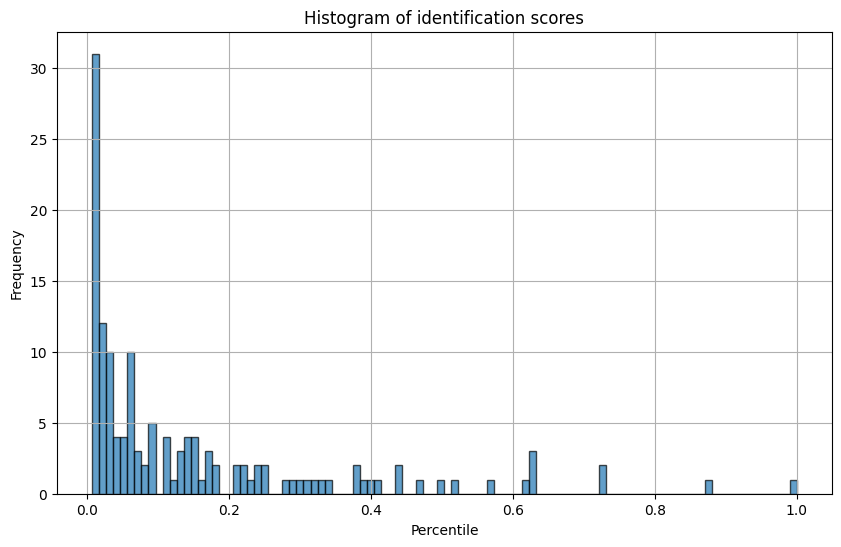

Cosine Similarity: 0.2714
Recall@1: 0.1812
Recall@5: 0.3841
Recall@10: 0.5362
Mean Reciprocal Rank (MRR): 0.2854
Median Rank: 0.0652


In [14]:
import matplotlib.pyplot as plt

import torch
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

device = "mps:0" if torch.backends.mps.is_available() else "cpu"

# Load the default pretrained CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to generate embeddings
def generate_embeddings(model, dataloader, device="cpu"):
    model.eval()
    image_embeddings = []
    text_embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
            image_embeddings.append(outputs.image_embeds.cpu().numpy())
            text_embeddings.append(outputs.text_embeds.cpu().numpy())
    
    return np.vstack(image_embeddings), np.vstack(text_embeddings)

# Generate embeddings for the validation set
val_dataloader = DataLoader(dataset, batch_size=4, collate_fn=custom_collate_fn)
image_embeds, text_embeds = generate_embeddings(model, val_dataloader, device)

# Compute cosine similarities
cos_sim_matrix = cosine_similarity(image_embeds, text_embeds)

# Cosine Similarity Metric
cos_sim_scores = [cos_sim_matrix[i, i] for i in range(len(val_dataset))]

# Accuracy @ k (Recall@k)
def accuracy_at_k(sim_matrix, k):
    top_k_indices = np.argsort(-sim_matrix, axis=1)[:, :k]
    correct = sum(1 for i in range(sim_matrix.shape[0]) if i in top_k_indices[i])
    return correct / sim_matrix.shape[0]

recall_at_1 = accuracy_at_k(cos_sim_matrix, 1)
recall_at_5 = accuracy_at_k(cos_sim_matrix, 5)
recall_at_10 = accuracy_at_k(cos_sim_matrix, 10)

# Mean Reciprocal Rank (MRR)
def mean_reciprocal_rank(sim_matrix):
    ranks = np.argsort(-sim_matrix, axis=1)
    reciprocal_ranks = [1 / (np.where(ranks[i] == i)[0][0] + 1) for i in range(sim_matrix.shape[0])]
    return np.mean(reciprocal_ranks)

mrr = mean_reciprocal_rank(cos_sim_matrix)

# Median Rank
def median_rank(sim_matrix):
    ranks = np.argsort(-sim_matrix, axis=1)
    correct_ranks = [np.where(ranks[i] == i)[0][0] + 1 for i in range(sim_matrix.shape[0])]
    plt.figure(figsize=(10, 6))
    
    plt.hist([a/len(dataset) for a in correct_ranks], bins=100, edgecolor='black', alpha=0.7)
    plt.title('Histogram of identification scores')
    plt.xlabel('Percentile')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    return np.median(correct_ranks)/len(dataset)

median_rank_value = median_rank(cos_sim_matrix)



# Print metrics
print(f'Cosine Similarity: {np.mean(cos_sim_scores):.4f}')
print(f'Recall@1: {recall_at_1:.4f}')
print(f'Recall@5: {recall_at_5:.4f}')
print(f'Recall@10: {recall_at_10:.4f}')
print(f'Mean Reciprocal Rank (MRR): {mrr:.4f}')
print(f'Median Rank: {median_rank_value:.4f}')


In [4]:
from PIL import Image
import torch
import numpy as np
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/Users/aneeshkalla/anaconda3/envs/flava/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def generate_image_embedding(image_path, model, processor, device="cpu"):
    model.eval()
    with torch.no_grad():
        # Convert numpy array to PIL image
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")

        # Move inputs to the specified device
        pixel_values = inputs["pixel_values"].to(device)

        # Generate image embedding
        outputs = model.get_image_features(pixel_values=pixel_values)

        # Return the embedding as a numpy array
        image_embedding = outputs.cpu().numpy()
    
    return image_embedding
    
def generate_text_embedding(text, model, processor, device="cpu"):
    model.eval()
    with torch.no_grad():
        # Preprocess the text
        inputs = processor(text=text, return_tensors="pt")

        # Move inputs to the specified device
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Generate text embedding
        outputs = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

        # Return the embedding as a numpy array
        text_embedding = outputs.cpu().numpy()

    return text_embedding


In [5]:
image_path = "coco_people_v1/000000000016.png"

image_embedding = generate_image_embedding(image_path, model, processor)
image_embedding

array([[ 3.86053830e-01,  2.39590466e-01,  1.55481637e-01,
        -4.88705784e-02,  2.19992369e-01,  2.27973968e-01,
         6.87912107e-03,  2.60867864e-01,  5.12845814e-01,
        -9.10357088e-02,  3.51122558e-01, -4.31026518e-01,
         1.33838177e-01, -5.36533117e-01, -2.55115390e-01,
        -2.18697608e-01,  3.56340170e-01,  1.35775596e-01,
         4.45999622e-01, -2.63151735e-01, -7.71487474e-01,
         7.87151814e-01, -1.88493788e-01, -1.12741664e-01,
         2.17450067e-01,  1.36796385e-01,  1.82241909e-02,
        -2.58443594e-01, -3.14642429e-01,  5.02530217e-01,
         2.90763676e-01,  2.02071667e-01,  1.09957173e-01,
         3.83811593e-01,  4.75916415e-01,  3.66609037e-01,
        -1.31692708e-01,  4.69295681e-01,  4.79776636e-02,
         1.50391972e+00, -3.10165808e-02, -5.45032799e-01,
        -5.09198532e-02, -2.44054586e-01,  4.03929323e-01,
        -1.80057496e-01, -2.47500971e-01,  6.90041065e-01,
         2.23687500e-01,  1.49299845e-01,  9.06555653e-0

In [11]:
len(image_embedding[0])

512

In [13]:
text = "this guy is in his late 50s and has very notably facial deformities"
text_embedding = generate_text_embedding(text, model, processor)
print(text_embedding)


[[-4.12713587e-02 -1.75423637e-01 -2.32043847e-01  3.32224071e-01
   6.77217841e-02 -3.15148234e-01  3.85771662e-01 -1.07882273e+00
   2.97790855e-01 -2.72612333e-01  3.05155218e-01 -2.81259686e-01
  -1.41776890e-01 -1.93127915e-01  3.85488272e-02  3.67531359e-01
   7.38353610e-01  1.94862455e-01 -1.99307397e-01 -3.71847153e-01
   1.29055008e-01  3.76154244e-01 -1.87926471e-01 -3.95415515e-01
  -3.21907103e-01 -2.59223133e-02  1.23263434e-01  3.14379275e-01
   1.99939847e-01 -1.65292740e-01  2.73053288e-01 -3.14157993e-01
   3.38442326e-02  1.14873998e-01  1.78782806e-01  3.56093049e-01
   3.00217420e-03 -6.10750206e-02  1.84492916e-02  2.16035664e-01
  -2.46430755e-01  9.23403949e-02 -2.42604196e-01  1.52701735e-01
   5.36007993e-02  4.69834000e-01 -1.48835897e-01 -5.63897267e-02
  -1.23195097e-01  6.12623021e-02 -7.13832974e-02  2.45018154e-02
  -1.45274103e-02 -8.34257156e-02 -1.26031861e-01  1.54980659e-01
   6.63825721e-02 -3.54900122e-01  1.99647635e-01 -8.20222497e-03
   5.00982

In [15]:
print(len(text_embedding[0]))

512


In [3]:
import faiss
import numpy as np


def initialize_index(embedding_dim):
    index = faiss.IndexFlatL2(embedding_dim)
    return index

# Example usage:
embedding_dim = 512  # Example embedding dimension
index = initialize_index(embedding_dim)

In [10]:
def add_embedding_to_index(index, embedding):
    index.add(embedding)

# Example usage:
new_embedding = np.random.rand(1, embedding_dim).astype(np.float32)  # Example new embedding
add_embedding_to_index(index, new_embedding)

In [11]:
def query_embeddings(index, query_embedding, k=5):
    distances, indices = index.search(query_embedding, k)
    return distances, indices

# Example usage:
# Assume `text_embedding` is a numpy array of shape (1, embedding_dim)
text_embedding = np.random.rand(1, 512)  # Example query
distances, indices = query_embeddings(index, text_embedding)
print("Indices of similar images:", indices)
print("Distances to similar images:", distances)

Indices of similar images: [[5 3 2 0 1]]
Distances to similar images: [[76.37869 80.75256 83.795   84.70528 86.2814 ]]
